<a href="https://colab.research.google.com/github/21016118uhi/21016118_DataAnalytics/blob/main/21016118_assignment_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install required packages
install.packages("GGally")
install.packages("ggfortify")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘Rcpp’, ‘ggstats’, ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘pROC’, ‘recipes’, ‘reshape2’




In [2]:
# load necessary packages
library(tidyverse)
library(GGally)
library(lubridate)
library(broom)
library(patchwork)
library(ggfortify)
library(caret)

# set plot size
options(repr.plot.width = 15, repr.plot.height = 15)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




# Introduction

The emergency services of New York wished to understand if there is a relationship between the number of collisions on any given day and the weather, to help improve their planning. To support this, weather and collision data were reviewed for quality and suitability, supported by some research about New York. Additional relevant data was also identified and added to the dataset, which was then used to test a series of linear regression models to find a model that could most accurately predict the number of collisions.

# Methodology

***Review Dataset***

The preliminary analysis explored the quality and contents of the NYC collision dataset.



```
CREATE VIEW `uhi-project-398119.assignment_part1.collisions_raw_all` AS SELECT * FROM
`bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`;

SELECT COUNT(*) AS number_rows FROM `uhi-project-398119.assignment_part1.collisions_raw_all`;
```



It was noted that there were just over two million rows of data with 28 columns, which could be split into five categories:

1.   Unique collision key - 1 variable
2.   Timestamp - 1 variable
3.   Number of individuals injured or killed, broken down by their mode of transport - 8 variables
4.   Information about up to 5 vehicles involved in each collision - 10 variables
5.   Location information - 8 variables.

The data quality of these five categories was reviewed in order.

> *1. Unique collision key*



```
SELECT COUNT(DISTINCT(unique_key)) AS unique_count, COUNT(unique_key) AS count FROM `uhi-project-398119.assignment_part1.collisions_raw_all`;

SELECT COUNT(*) AS blanks FROM `uhi-project-398119.assignment_part1.collisions_raw_all`WHERE unique_key IS NULL;
```



Every row of data has a unique key with no null values.



```
SELECT LENGTH(CAST(unique_key AS string)) as key_length, EXTRACT(YEAR FROM timestamp) as year, COUNT(unique_key) as occurence FROM `uhi-project-398119.assignment_part1.collisions_raw_all` GROUP BY key_length, year;
```



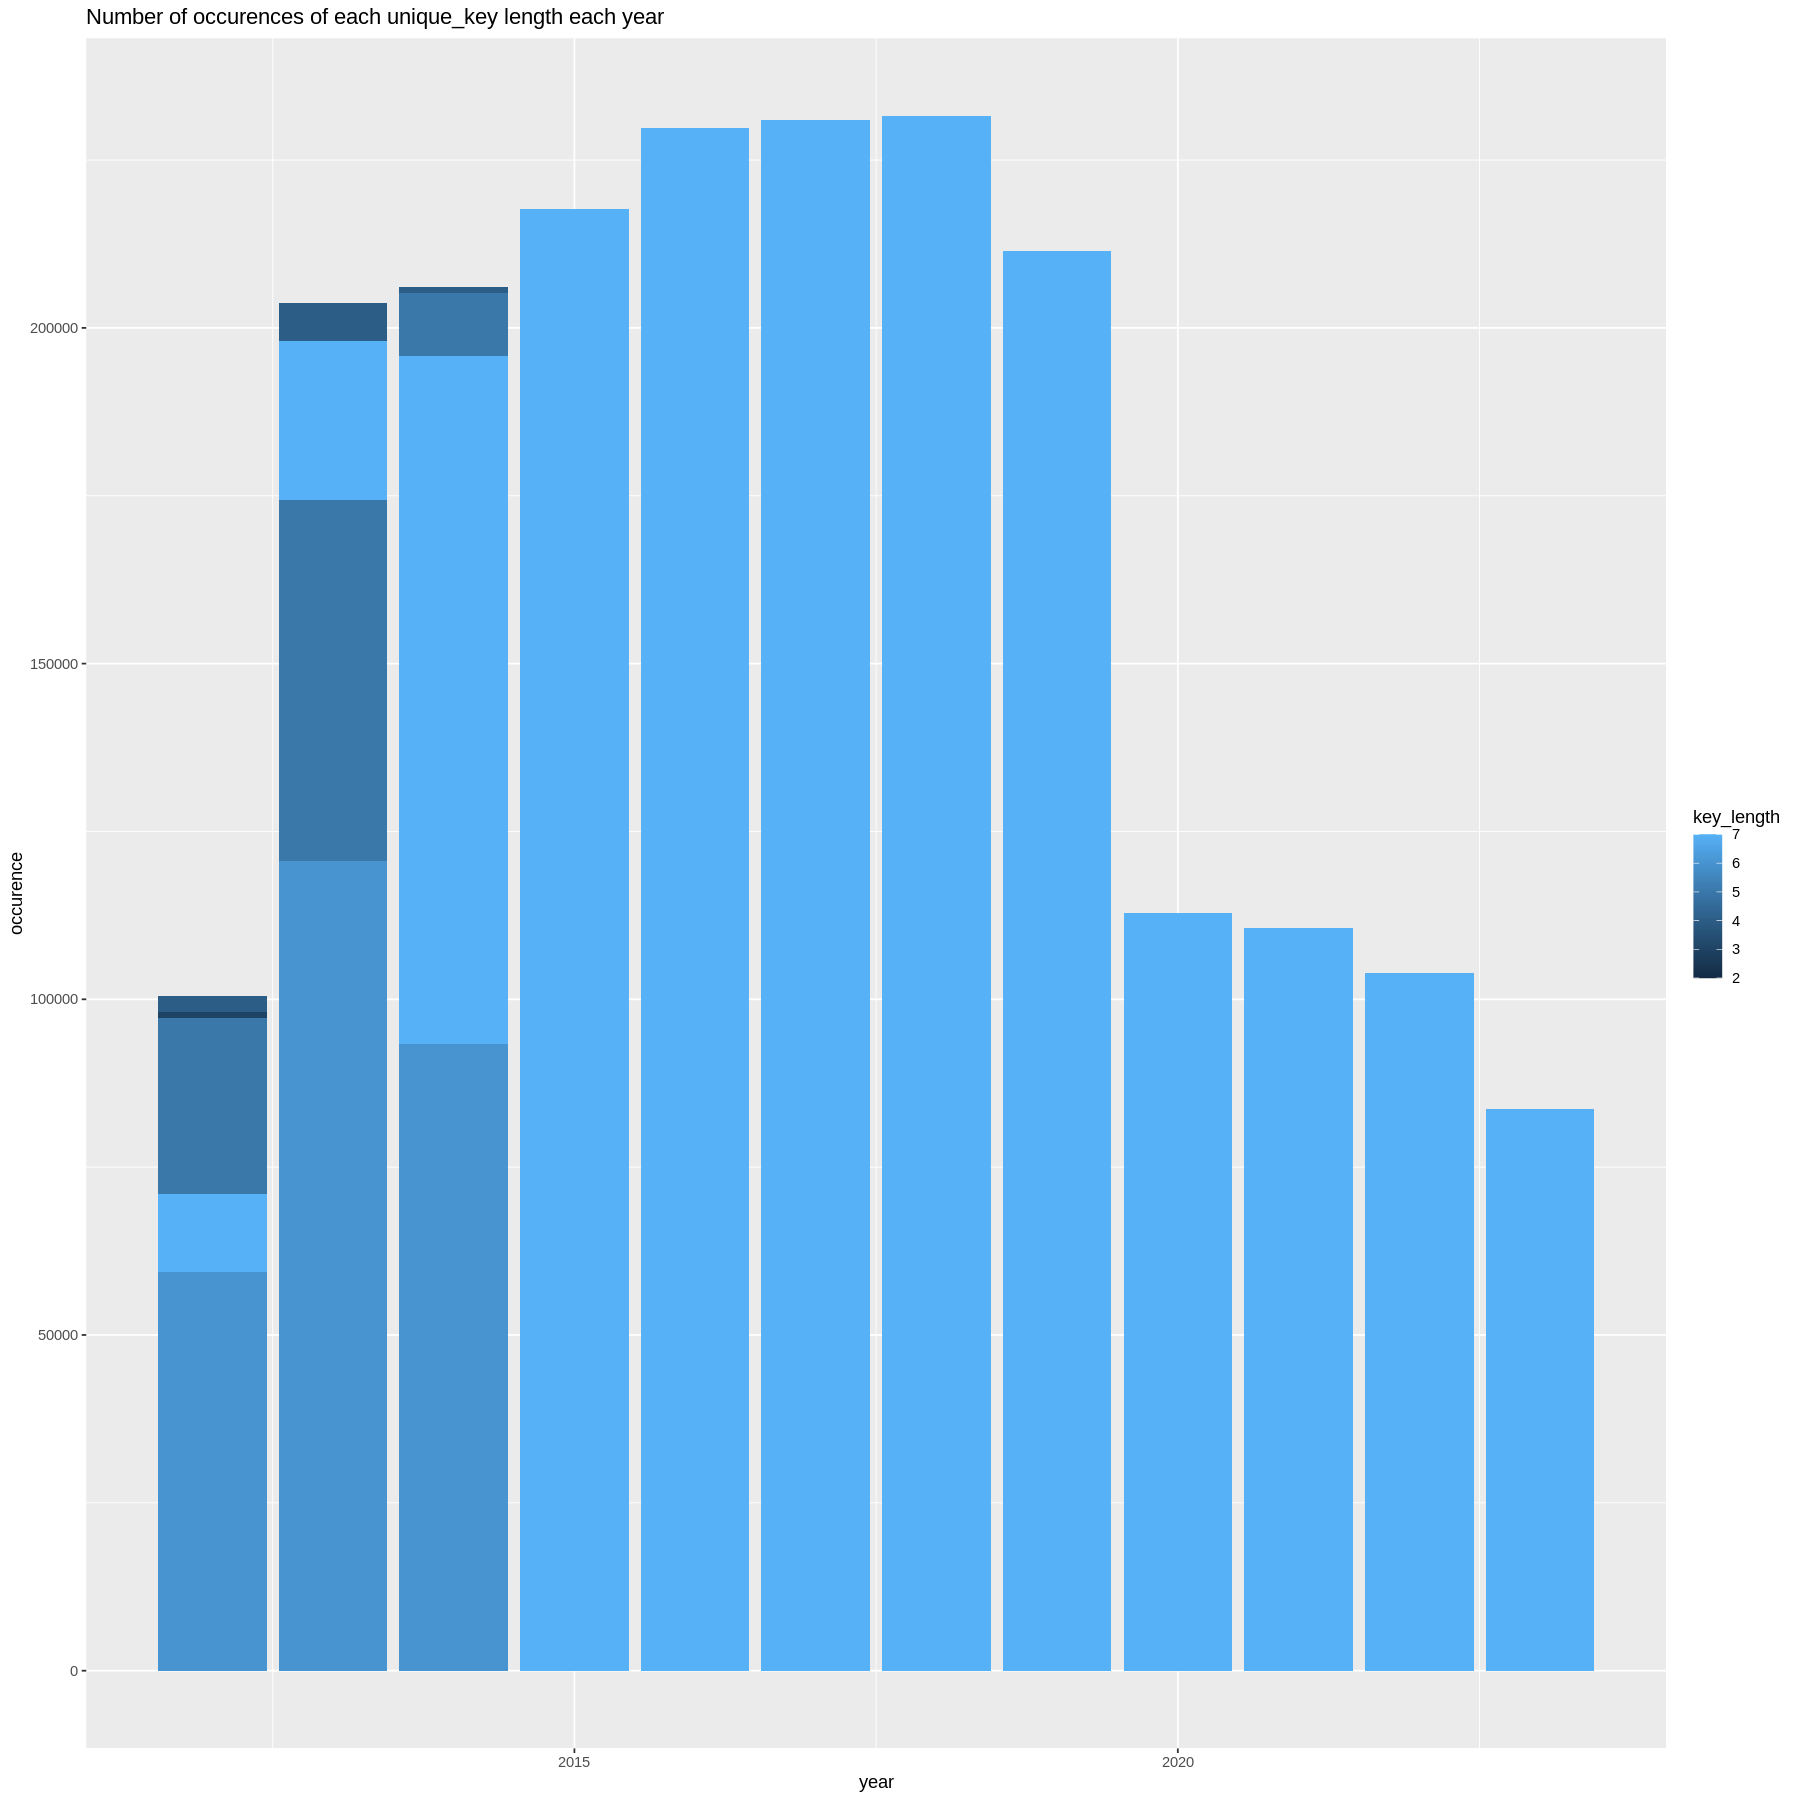

In [3]:
# read in results
collisions_unique_key_length <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/collisions_unique_key_length.csv", show_col_types = FALSE)
# display results as a chart
ggplot(collisions_unique_key_length, aes(x = year, y = occurence, fill = key_length)) +
  geom_col() +
  labs(title = "Number of occurences of each unique_key length each year")

The chart shows a variety of key lengths were used between 2012-2014, but only 7 length keys have been used since 2015, without noticeable change in the total number of occurrences in the years up until 2020 (the year the Covid-19 pandemic started). Therefore, the reason for the variation in lengths will not be considered as the data is too incomplete to be beneficial.



> *2. Timestamp*



As before, every entry has an entry for timestamp so a count of collisions for each month was calculated then plotted.



```
SELECT
  FORMAT_TIMESTAMP("%b %y", timestamp) AS month_date,
  EXTRACT(MONTH FROM timestamp) AS month,
  EXTRACT(YEAR FROM timestamp) AS year,
  MIN(timestamp) AS earliest_timestamp,
  COUNT(unique_key) AS occurences
FROM `uhi-project-398119.assignment_part1.collisions_raw_all`
  GROUP BY month_date, month, year
  ORDER BY year, month
```



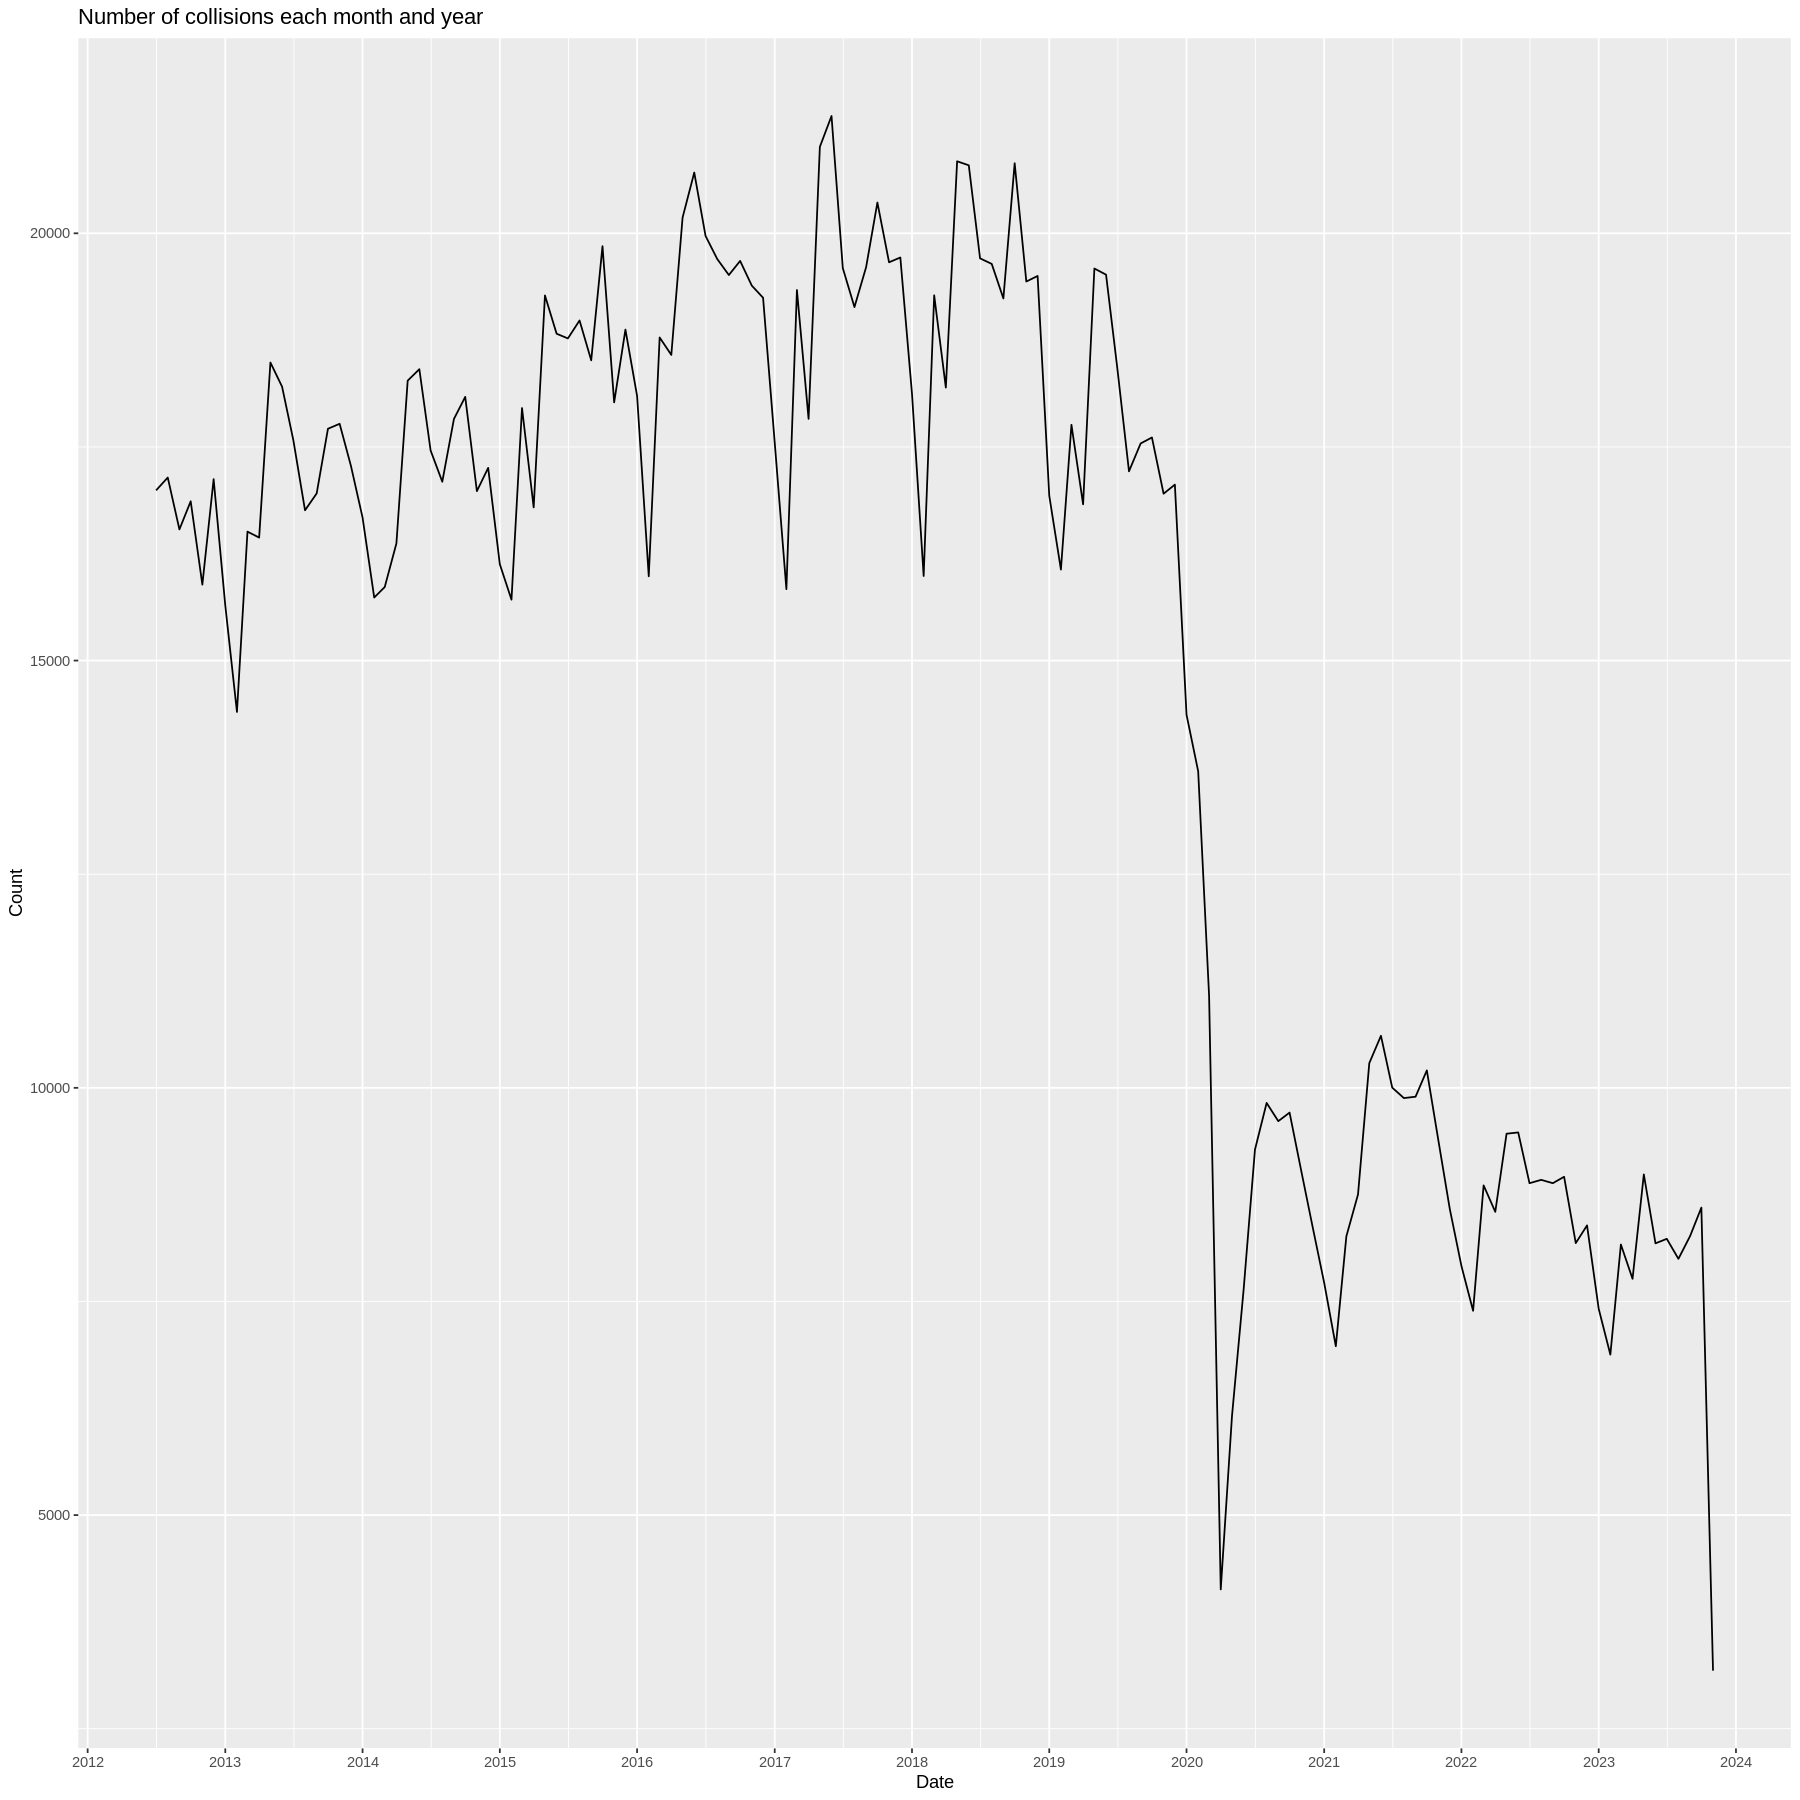

In [4]:
# read in results
collisions_month_date_count <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/collisions_month_date_count.csv", show_col_types = FALSE)
# keep data order
collisions_month_date_count$month_date <- factor(collisions_month_date_count$month_date, levels=collisions_month_date_count$month_date)
# display results as a chart
ggplot(collisions_month_date_count) +
  geom_line(aes(x = earliest_timestamp, y = occurences, group = 1)) +
  scale_x_datetime(date_breaks = "1 year", date_labels = "%Y") +
  labs(title = "Number of collisions each month and year", x = "Date", y = "Count")

The first recorded collision was on 1st July 2012. The chart shows some seasonality in the number of collisions each year, therefore, month will be tested as a significant variable when creating a linear model.

There is a sharp decrease in collisions from 2020 as noted above, but the number of collisions has not returned to pre-pandemic numbers by late 2023, even though the city reopened for business by late 2021 (The New York Times 2022).


> *3. Number of individuals injured or killed*



```
DECLARE total int64;
SET total = (SELECT COUNT(*) FROM `uhi-project-398119.assignment_part1.collisions_raw_all`);

SELECT (number_of_cyclist_injured + number_of_motorist_injured + number_of_pedestrians_injured - number_of_persons_injured) AS total_difference_injured,
  COUNT(*) AS count,
  ROUND((COUNT(*)/total),4) AS percentage
  FROM `uhi-project-398119.assignment_part1.collisions_raw_all`
  GROUP BY total_difference_injured
  ORDER BY total_difference_injured;

SELECT (number_of_cyclist_killed + number_of_motorist_killed + number_of_pedestrians_killed - number_of_persons_killed) AS total_difference_killed,
  COUNT(*) AS count,
  ROUND((COUNT(*)/total),4) AS percentage
  FROM `uhi-project-398119.assignment_part1.collisions_raw_all`
  GROUP BY total_difference_killed
  ORDER BY total_difference_killed;
```



All entries in all columns contained a number, but checking the total number of people injured versus the breakdown of cyclists, motorists and pedestrians revealed a 99.65% accuracy. The accuracy of total number of people killed was practically 100%. It was decided to exclude entries that had rows that had inaccurate numbers of injured or killed people as the reason for the error is unknown but the impact on the dataset should be marginal.



```
CREATE VIEW `uhi-project-398119.assignment_part1.collisions_wo_num_errors` AS
  SELECT * FROM `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
  WHERE number_of_cyclist_killed + number_of_motorist_killed + number_of_pedestrians_killed = number_of_persons_killed
    AND
  number_of_cyclist_injured + number_of_motorist_injured + number_of_pedestrians_injured = number_of_persons_injured;
```





> *4. Number of vehicles involved in the collision*





```
DECLARE total int64;
SET total = (SELECT COUNT(*) FROM `uhi-project-398119.assignment_part1.collisions_wo_num_errors`);

SELECT COUNT(contributing_factor_vehicle_1)/total AS perc_cfv_1,
  COUNT(contributing_factor_vehicle_2)/total AS perc_cfv_2,
  COUNT(contributing_factor_vehicle_3)/total AS perc_cfv_3,
  COUNT(contributing_factor_vehicle_4)/total AS perc_cfv_4,
  COUNT(contributing_factor_vehicle_5)/total AS perc_cfv_5,
  COUNT(vehicle_type_code1)/total AS perc_vc_1,
  COUNT(vehicle_type_code2)/total AS perc_vc_2,
  COUNT(vehicle_type_code_3)/total AS perc_vc_3,
  COUNT(vehicle_type_code_4)/total AS perc_vc_4,
  COUNT(vehicle_type_code_5)/total AS perc_vc_5
  FROM `uhi-project-398119.assignment_part1.collisions_wo_num_errors`;
```



Overall the contributing factors are more populated than the vehicle codes. Vehicle 1 data was up to 99.7% populated compared to vehicle 5 data at 0.4% populated. It was concluded that there are adequate reasons why both a contributing factor and code might not be populated for a vehicle, so it is assumed that a vehicle is present if either field is populated.


An additional column was calculated with the total number of vehicles involved. It was then concluded that the 78 instances that reported an injured or killed motorist but did not include vehicle information contained erroneous data and where also excluded from the analysis.



```
CREATE VIEW `uhi-project-398119.assignment_part1.collisions_wo_vehicle_errors` AS
  SELECT
  IF(contributing_factor_vehicle_1 is not null or vehicle_type_code1 is not null, 1, 0) +
  IF(contributing_factor_vehicle_2 is not null or vehicle_type_code2 is not null, 1, 0) +
  IF(contributing_factor_vehicle_3 is not null or vehicle_type_code_3 is not null, 1, 0) +
  IF(contributing_factor_vehicle_4 is not null or vehicle_type_code_4 is not null, 1, 0) +
  IF(contributing_factor_vehicle_5 is not null or vehicle_type_code_5 is not null, 1, 0) as number_vehicles_involved,
  CASE
    WHEN contributing_factor_vehicle_1 IN ('Passenger Distraction', 'Other Electronic Device', 'Cell Phone (hand-Held)',
      'Cell Phone (hands-free)', 'Using On Board Navigation Device', 'Eating or Drinking', 'Cell Phone (hand-held)',
      'Texting', 'Listening/Using Headphones') THEN 'Driver Inattention/Distraction'
    WHEN contributing_factor_vehicle_1 IN ('Fatigued/Drowsy', 'Lost Consciousness', 'Alcohol Involvement',
      'Prescription Medication', 'Fell Asleep', 'Illness', 'Illnes', 'Drugs (illegal)', 'Drugs (Illegal)') THEN 'Driver Unwell / Medical'
    WHEN contributing_factor_vehicle_1 IN ('Other Vehicular', 'Brakes Defective', 'Steering Failure', 'Tire Failure/Inadequate',
      'Accelerator Defective', 'Tow Hitch Defective', 'Headlights Defective', 'Windshield Inadequate') THEN 'Vehicle Failure'
    WHEN contributing_factor_vehicle_1 IN ('Pavement Slippery', 'Pavement Defective', 'Lane Marking Improper/Inadequate',
      'Traffic Control Device Improper/Non-Working', 'Driverless/Runaway Vehicle', 'Vehicle Vandalism',
      'Shoulders Defective/Improper') THEN 'Environmental Defect / Failure'
    WHEN contributing_factor_vehicle_1 IN ('View Obstructed/Limited', 'Outside Car Distraction', 'Obstruction/Debris', 'Glare',
      'Other Lighting Defects', 'Tinted Windows') THEN 'Visual Distraction / Obstruction'
    WHEN contributing_factor_vehicle_1 IN ('Passing Too Closely' ,'Unsafe Lane Changing') THEN 'Passing or Lane Usage Improper'
    WHEN contributing_factor_vehicle_1 IN ('80' ,'1') THEN 'Unspecified'
    WHEN contributing_factor_vehicle_1 = 'Reaction to Other Uninvolved Vehicle' THEN 'Reaction to Uninvolved Vehicle'
    ELSE contributing_factor_vehicle_1
  END AS contributing_factor_vehicle_1_c,
  CASE
    WHEN contributing_factor_vehicle_2 IN ('Passenger Distraction', 'Other Electronic Device', 'Cell Phone (hand-Held)',
      'Cell Phone (hands-free)', 'Using On Board Navigation Device', 'Eating or Drinking', 'Cell Phone (hand-held)',
      'Texting', 'Listening/Using Headphones') THEN 'Driver Inattention/Distraction'
    WHEN contributing_factor_vehicle_2 IN ('Fatigued/Drowsy', 'Lost Consciousness', 'Alcohol Involvement',
      'Prescription Medication', 'Fell Asleep', 'Illness', 'Illnes', 'Drugs (illegal)', 'Drugs (Illegal)') THEN 'Driver Unwell / Medical'
    WHEN contributing_factor_vehicle_2 IN ('Other Vehicular', 'Brakes Defective', 'Steering Failure', 'Tire Failure/Inadequate',
      'Accelerator Defective', 'Tow Hitch Defective', 'Headlights Defective', 'Windshield Inadequate') THEN 'Vehicle Failure'
    WHEN contributing_factor_vehicle_2 IN ('Pavement Slippery', 'Pavement Defective', 'Lane Marking Improper/Inadequate',
      'Traffic Control Device Improper/Non-Working', 'Driverless/Runaway Vehicle', 'Vehicle Vandalism',
      'Shoulders Defective/Improper') THEN 'Environmental Defect / Failure'
    WHEN contributing_factor_vehicle_2 IN ('View Obstructed/Limited', 'Outside Car Distraction', 'Obstruction/Debris', 'Glare',
      'Other Lighting Defects', 'Tinted Windows') THEN 'Visual Distraction / Obstruction'
    WHEN contributing_factor_vehicle_2 IN ('Passing Too Closely' ,'Unsafe Lane Changing') THEN 'Passing or Lane Usage Improper'
    WHEN contributing_factor_vehicle_2 IN ('80' ,'1') THEN 'Unspecified'
    WHEN contributing_factor_vehicle_2 = 'Reaction to Other Uninvolved Vehicle' THEN 'Reaction to Uninvolved Vehicle'
    ELSE contributing_factor_vehicle_2
  END AS contributing_factor_vehicle_2_c,
  CASE
    WHEN contributing_factor_vehicle_3 IN ('Passenger Distraction', 'Other Electronic Device', 'Cell Phone (hand-Held)',
      'Cell Phone (hands-free)', 'Using On Board Navigation Device', 'Eating or Drinking', 'Cell Phone (hand-held)',
      'Texting', 'Listening/Using Headphones') THEN 'Driver Inattention/Distraction'
    WHEN contributing_factor_vehicle_3 IN ('Fatigued/Drowsy', 'Lost Consciousness', 'Alcohol Involvement',
      'Prescription Medication', 'Fell Asleep', 'Illness', 'Illnes', 'Drugs (illegal)', 'Drugs (Illegal)') THEN 'Driver Unwell / Medical'
    WHEN contributing_factor_vehicle_3 IN ('Other Vehicular', 'Brakes Defective', 'Steering Failure', 'Tire Failure/Inadequate',
      'Accelerator Defective', 'Tow Hitch Defective', 'Headlights Defective', 'Windshield Inadequate') THEN 'Vehicle Failure'
    WHEN contributing_factor_vehicle_3 IN ('Pavement Slippery', 'Pavement Defective', 'Lane Marking Improper/Inadequate',
      'Traffic Control Device Improper/Non-Working', 'Driverless/Runaway Vehicle', 'Vehicle Vandalism',
      'Shoulders Defective/Improper') THEN 'Environmental Defect / Failure'
    WHEN contributing_factor_vehicle_3 IN ('View Obstructed/Limited', 'Outside Car Distraction', 'Obstruction/Debris', 'Glare',
      'Other Lighting Defects', 'Tinted Windows') THEN 'Visual Distraction / Obstruction'
    WHEN contributing_factor_vehicle_3 IN ('Passing Too Closely' ,'Unsafe Lane Changing') THEN 'Passing or Lane Usage Improper'
    WHEN contributing_factor_vehicle_3 IN ('80' ,'1') THEN 'Unspecified'
    WHEN contributing_factor_vehicle_3 = 'Reaction to Other Uninvolved Vehicle' THEN 'Reaction to Uninvolved Vehicle'
    ELSE contributing_factor_vehicle_3
  END AS contributing_factor_vehicle_3_c,
  CASE
    WHEN contributing_factor_vehicle_4 IN ('Passenger Distraction', 'Other Electronic Device', 'Cell Phone (hand-Held)',
      'Cell Phone (hands-free)', 'Using On Board Navigation Device', 'Eating or Drinking', 'Cell Phone (hand-held)',
      'Texting', 'Listening/Using Headphones') THEN 'Driver Inattention/Distraction'
    WHEN contributing_factor_vehicle_4 IN ('Fatigued/Drowsy', 'Lost Consciousness', 'Alcohol Involvement',
      'Prescription Medication', 'Fell Asleep', 'Illness', 'Illnes', 'Drugs (illegal)', 'Drugs (Illegal)') THEN 'Driver Unwell / Medical'
    WHEN contributing_factor_vehicle_4 IN ('Other Vehicular', 'Brakes Defective', 'Steering Failure', 'Tire Failure/Inadequate',
      'Accelerator Defective', 'Tow Hitch Defective', 'Headlights Defective', 'Windshield Inadequate') THEN 'Vehicle Failure'
    WHEN contributing_factor_vehicle_4 IN ('Pavement Slippery', 'Pavement Defective', 'Lane Marking Improper/Inadequate',
      'Traffic Control Device Improper/Non-Working', 'Driverless/Runaway Vehicle', 'Vehicle Vandalism',
      'Shoulders Defective/Improper') THEN 'Environmental Defect / Failure'
    WHEN contributing_factor_vehicle_4 IN ('View Obstructed/Limited', 'Outside Car Distraction', 'Obstruction/Debris', 'Glare',
      'Other Lighting Defects', 'Tinted Windows') THEN 'Visual Distraction / Obstruction'
    WHEN contributing_factor_vehicle_4 IN ('Passing Too Closely' ,'Unsafe Lane Changing') THEN 'Passing or Lane Usage Improper'
    WHEN contributing_factor_vehicle_4 IN ('80' ,'1') THEN 'Unspecified'
    WHEN contributing_factor_vehicle_4 = 'Reaction to Other Uninvolved Vehicle' THEN 'Reaction to Uninvolved Vehicle'
    ELSE contributing_factor_vehicle_4
  END AS contributing_factor_vehicle_4_c,
  CASE
    WHEN contributing_factor_vehicle_5 IN ('Passenger Distraction', 'Other Electronic Device', 'Cell Phone (hand-Held)',
      'Cell Phone (hands-free)', 'Using On Board Navigation Device', 'Eating or Drinking', 'Cell Phone (hand-held)',
      'Texting', 'Listening/Using Headphones') THEN 'Driver Inattention/Distraction'
    WHEN contributing_factor_vehicle_5 IN ('Fatigued/Drowsy', 'Lost Consciousness', 'Alcohol Involvement',
      'Prescription Medication', 'Fell Asleep', 'Illness', 'Illnes', 'Drugs (illegal)', 'Drugs (Illegal)') THEN 'Driver Unwell / Medical'
    WHEN contributing_factor_vehicle_5 IN ('Other Vehicular', 'Brakes Defective', 'Steering Failure', 'Tire Failure/Inadequate',
      'Accelerator Defective', 'Tow Hitch Defective', 'Headlights Defective', 'Windshield Inadequate') THEN 'Vehicle Failure'
    WHEN contributing_factor_vehicle_5 IN ('Pavement Slippery', 'Pavement Defective', 'Lane Marking Improper/Inadequate',
      'Traffic Control Device Improper/Non-Working', 'Driverless/Runaway Vehicle', 'Vehicle Vandalism',
      'Shoulders Defective/Improper') THEN 'Environmental Defect / Failure'
    WHEN contributing_factor_vehicle_5 IN ('View Obstructed/Limited', 'Outside Car Distraction', 'Obstruction/Debris', 'Glare',
      'Other Lighting Defects', 'Tinted Windows') THEN 'Visual Distraction / Obstruction'
    WHEN contributing_factor_vehicle_5 IN ('Passing Too Closely' ,'Unsafe Lane Changing') THEN 'Passing or Lane Usage Improper'
    WHEN contributing_factor_vehicle_5 IN ('80' ,'1') THEN 'Unspecified'
    WHEN contributing_factor_vehicle_5 = 'Reaction to Other Uninvolved Vehicle' THEN 'Reaction to Uninvolved Vehicle'
    ELSE contributing_factor_vehicle_5
  END AS contributing_factor_vehicle_5_c,
  borough, cross_street_name, timestamp, latitude, longitude, location, number_of_cyclist_injured, number_of_cyclist_killed, number_of_motorist_injured,
  number_of_motorist_killed, number_of_pedestrians_injured, number_of_pedestrians_killed, number_of_persons_injured, number_of_persons_killed,
  off_street_name, on_street_name, unique_key, vehicle_type_code1, vehicle_type_code2, vehicle_type_code_3, vehicle_type_code_4, vehicle_type_code_5, zip_code
  FROM `uhi-project-398119.assignment_part1.collisions_wo_num_errors`
  WHERE
    number_of_motorist_injured + number_of_motorist_killed = 0
      OR
    IF(contributing_factor_vehicle_1 is not null or vehicle_type_code1 is not null, 1, 0) +
    IF(contributing_factor_vehicle_2 is not null or vehicle_type_code2 is not null, 1, 0) +
    IF(contributing_factor_vehicle_3 is not null or vehicle_type_code_3 is not null, 1, 0) +
    IF(contributing_factor_vehicle_4 is not null or vehicle_type_code_4 is not null, 1, 0) +
    IF(contributing_factor_vehicle_5 is not null or vehicle_type_code_5 is not null, 1, 0) > 0;
```





```
CREATE VIEW `uhi-project-398119.assignment_part1.contributing_factor_count` AS
SELECT contributing_factor_vehicle_1 AS contributing_factor, count(contributing_factor_vehicle_1) AS count
  FROM `uhi-project-398119.assignment_part1.collisions_wo_vehicle_errors` GROUP BY contributing_factor_vehicle_1
UNION ALL
SELECT contributing_factor_vehicle_2 AS contributing_factor, count(contributing_factor_vehicle_2) AS count
  FROM `uhi-project-398119.assignment_part1.collisions_wo_vehicle_errors` GROUP BY contributing_factor_vehicle_2
UNION ALL
SELECT contributing_factor_vehicle_3 AS contributing_factor, count(contributing_factor_vehicle_3) AS count
  FROM `uhi-project-398119.assignment_part1.collisions_wo_vehicle_errors` GROUP BY contributing_factor_vehicle_3
UNION ALL
SELECT contributing_factor_vehicle_4 AS contributing_factor, count(contributing_factor_vehicle_4) AS count
  FROM `uhi-project-398119.assignment_part1.collisions_wo_vehicle_errors` GROUP BY contributing_factor_vehicle_4
UNION ALL
SELECT contributing_factor_vehicle_5 AS contributing_factor, count(contributing_factor_vehicle_5) AS count
  FROM `uhi-project-398119.assignment_part1.collisions_wo_vehicle_errors` GROUP BY contributing_factor_vehicle_5
ORDER BY
  contributing_factor;
```



Combining the contributing factors gives a list of 62 values, which, after review, were grouped into twenty factors detailed below. A column combining the contributing factors was also created for ease of analysis later.

In [5]:
# read in results
contributing_factors_table <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/contributing_factors.csv", show_col_types = FALSE)
# display results as a table
contributing_factors_table

contributing_factor                                   number_collisions
1  Unspecified                                           2327997          
2  Driver Inattention/Distraction                         501203          
3  Failure to Yield Right-of-Way                          137390          
4  Following Too Closely                                  130026          
5  Other Vehicular                                         98482          
6  Backing Unsafely                                        83785          
7  Passing or Lane Usage Improper                          68982          
8  Passing Too Closely                                     59357          
9  Fatigued/Drowsy                                         59262          
10 Turning Improperly                                      59096          
11 Unsafe Lane Changing                                    46882          
12 Traffic Control Disregarded                             43015          
13 Driver Inexperience                                     38546          
14 Unsafe Speed                                            33017          
15 Lost Consciousness                                      25698          
16 Pavement Slippery                                       23995          
17 Alcohol Involvement                                     23826          
18 Reaction to Uninvolved Vehicle                          23319          
19 Prescription Medication                                 18454          
20 View Obstructed/Limited                                 16508          
21 Outside Car Distraction                                 15483          
22 Oversized Vehicle                                       14737          
23 Physical Disability                                     11573          
24 Pedestrian/Bicyclist/Other Pedestrian Error/Confusion   11482          
25 Aggressive Driving/Road Rage                            11214          
26 Passenger Distraction                                    9456          
27 Brakes Defective                                         7269          
28 Fell Asleep                                              6163          
29 Obstruction/Debris                                       4999          
30 Glare                                                    4549          
⋮  ⋮                                                     ⋮                
33 Steering Failure                                      2948             
34 Pavement Defective                                    2618             
35 Tire Failure/Inadequate                               2615             
36 Illness                                               2604             
37 Reaction to Other Uninvolved Vehicle                  1714             
38 Illnes                                                1682             
39 Animals Action                                        1616             
40 Lane Marking Improper/Inadequate                      1522             
41 Traffic Control Device Improper/Non-Working           1351             
42 Driverless/Runaway Vehicle                            1338             
43 Accelerator Defective                                 1152             
44 Drugs (illegal)                                        902             
45 Cell Phone (hand-Held)                                 573             
46 Drugs (Illegal)                                        543             
47 Cell Phone (hands-free)                                318             
48 Tow Hitch Defective                                    243             
49 Other Lighting Defects                                 241             
50 Tinted Windows                                         205             
51 Headlights Defective                                   189             
52 Using On Board Navigation Device                       163             
53 Vehicle Vandalism                                      147             
54 Eating or Drinking       



```
CREATE VIEW `uhi-project-398119.assignment_part1.collisions_w_factors` AS
  SELECT
    *,
    CONCAT(contributing_factor_vehicle_1_c, contributing_factor_vehicle_2_c, contributing_factor_vehicle_3_c,
      contributing_factor_vehicle_4_c, contributing_factor_vehicle_5_c) AS contributing_factors
  FROM `uhi-project-398119.assignment_part1.collisions_wo_vehicle_errors`
```





> *5. Location*



A quick analysis of the data reveals that a handful of latitude and longitude values have been erroneously populated as 0. These were replaced with blanks. A varying number of decimal points had been used so these were all changed to 5 points (as a 0.00001 degree difference is approximately one metre, which was felt would be sufficient granularity).

Three street name addresses are potentially populated: on_street_name, off_street_name and cross_street_name. Only one street address is potentially required for the analysis, so these were merged into one column selecting the first populated address in the above order as the address the collision occurred on is most relevant, then the street it occurred off of, and finally the street that runs across is least relevant.



```
CREATE VIEW `uhi-project-398119.assignment_part1.collisions_wo_location_errors` AS
SELECT borough, zip_code, timestamp, number_of_cyclist_injured,
  number_of_cyclist_killed, number_of_motorist_injured, number_of_motorist_killed,
  number_of_pedestrians_injured, number_of_pedestrians_killed, number_of_persons_injured,
  number_of_persons_killed, unique_key, vehicle_type_code1,
  vehicle_type_code2, vehicle_type_code_3, vehicle_type_code_4,
  vehicle_type_code_5, contributing_factor_vehicle_1_c, contributing_factor_vehicle_2_c,
  contributing_factor_vehicle_3_c, contributing_factor_vehicle_4_c, contributing_factor_vehicle_5_c,
  number_vehicles_involved, contributing_factors,
  CASE
    WHEN latitude = 0 THEN null
      ELSE ROUND(latitude,5)
  END as latitude_c,
  CASE
    WHEN longitude = 0 THEN null
      ELSE ROUND(longitude,5)
  END as longitude_c,
  CASE
    WHEN latitude = 0 or longitude = 0 THEN null
    WHEN latitude IS NULL OR longitude IS NULL THEN null
      ELSE CONCAT('(',CAST(ROUND(latitude,5) as STRING),',',CAST(ROUND(longitude,5) as STRING),')')
  END as location_c,
  CASE
    WHEN on_street_name is not null THEN on_street_name
    WHEN off_street_name is not null THEN off_street_name
    ELSE cross_street_name
  END AS street_name
FROM `uhi-project-398119.assignment_part1.collisions_w_factors`;
```



Upon further inspection, street name is the most complete field with 95.5% of records having some information, however, the ability to translate this into a location is likely limited given the spacing and spelling mistakes and varying use of abbreviations. Of the uncleaned data 0.9% street names appear against multiple boroughs, so the data cannot be reliably used to populate the missing boroughs. 88.5% of the longitude and latitude points are specified but only 68.9% of the boroughs and zip codes are populated.



```
DECLARE total int64;
SET total = (SELECT COUNT(*) FROM `uhi-project-398119.assignment_part1.collisions_wo_location_errors`);

SELECT COUNT(borough)/total AS borough_perc,
  COUNT(latitude_c)/total AS latitude_perc,
  COUNT(longitude_c)/total AS longitude_perc,
  COUNT(location_c)/total AS location_perc,
  COUNT(zip_code)/total AS zip_code_perc,
  COUNT(street_name)/total AS street_name_perc
FROM `uhi-project-398119.assignment_part1.collisions_wo_location_errors`
```



As the task is to investigate the relationship between weather and the number of traffic collisions on a particular day and the location data is sparingly and questionably accurately populated, it will be excluded from the model for now, although is an interesting area to consider for future analysis.

An aggregated view was created with the year, month, date and day of week from the timestamp, along with summary information about the number of individuals and vehicles involved and the total number of accidents split by contributing factor. A date column was also added for ease of joining the data to other tables.





```
CREATE VIEW `uhi-project-398119.assignment_part1.collisions_summary` AS
SELECT EXTRACT(YEAR FROM timestamp) AS year,
  EXTRACT(MONTH FROM timestamp) AS month,
  EXTRACT(DAY FROM timestamp) AS day,
  EXTRACT(DAYOFWEEK FROM timestamp) AS day_of_week,
  EXTRACT(DATE FROM timestamp) as date,
  SUM(number_of_cyclist_injured) AS total_cyclist_injured,
  SUM(number_of_cyclist_killed) AS total_cyclist_killed,
  SUM(number_of_motorist_injured) AS total_motorist_injured,
  SUM(number_of_motorist_killed) AS total_motorist_killed,
  SUM(number_of_pedestrians_injured) AS total_pedestrians_injured,
  SUM(number_of_pedestrians_killed) AS total_pedestrians_killed,
  SUM(number_of_persons_injured) AS total_persons_injured,
  SUM(number_of_persons_killed) AS total_persons_killed,
  SUM(number_vehicles_involved) AS total_vehicles_involved,
  COUNT(unique_key) AS total_collisions,
  COUNTIF(contributing_factors LIKE '%Aggressive Driving/Road Rage%') AS aggressive_driving_road_rage,
  COUNTIF(contributing_factors LIKE '%Animals Action%') AS animals_action,
  COUNTIF(contributing_factors LIKE '%Backing Unsafely%') AS backing_unsafely,
  COUNTIF(contributing_factors LIKE '%Driver Inattention/Distraction%') AS driver_inattention_distraction,
  COUNTIF(contributing_factors LIKE '%Driver Inexperience%') AS driver_inexperience,
  COUNTIF(contributing_factors LIKE '%Driver Unwell / Medical%') AS driver_unwell_medical,
  COUNTIF(contributing_factors LIKE '%Environmental Defect / Failure%') AS environmental_defect_failure,
  COUNTIF(contributing_factors LIKE '%Failure to Keep Right%') AS failure_to_keep_right,
  COUNTIF(contributing_factors LIKE '%Failure to Yield Right-of-Way%') AS failure_to_yield_right_of_way,
  COUNTIF(contributing_factors LIKE '%Following Too Closely%') AS following_too_closely,
  COUNTIF(contributing_factors LIKE '%Oversized Vehicle%') AS oversized_vehicle,
  COUNTIF(contributing_factors LIKE '%Passing or Lane Usage Improper%') AS passing_or_lane_usage_improper,
  COUNTIF(contributing_factors LIKE '%Pedestrian/Bicyclist/Other Pedestrian Error/Confusion%') AS pedestrian_bicyclist_other_pedestrian_error_confusion,
  COUNTIF(contributing_factors LIKE '%Physical Disability%') AS physical_disability,
  COUNTIF(contributing_factors LIKE '%Reaction to Uninvolved Vehicle%') AS reaction_to_uninvolved_vehicle,
  COUNTIF(contributing_factors LIKE '%Traffic Control Disregarded%') AS traffic_control_disregarded,
  COUNTIF(contributing_factors LIKE '%Turning Improperly%') AS turning_improperly,
  COUNTIF(contributing_factors LIKE '%Unsafe Speed%') AS unsafe_speed,
  COUNTIF(contributing_factors LIKE '%Vehicle Failure%') AS vehicle_failure,
  COUNTIF(contributing_factors LIKE '%Visual Distraction / Obstruction%') AS visual_distraction_obstruction
FROM `uhi-project-398119.assignment_part1.collisions_wo_location_errors`
  GROUP BY year, month, day, day_of_week, date
```



Next the weather data for each day for the years 2012 to 2023 was collated into a single view. The year, month, day, wdsp, mxpsd, are incorrectly stored as strings so these were corrected. A date column was also added so the data can later be more easily collated.



```
CREATE VIEW `uhi-project-398119.assignment_part1.weather_2012_to_2023` AS
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog  
  FROM `bigquery-public-data.noaa_gsod.gsod2012` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2013` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2014` WHERE stn = '725060' AND wban = '14756'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2015` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2016` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2017` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2018` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2019` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2020` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2021` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2022` WHERE stn = '725060'
UNION ALL
  SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as date,
    CAST(year AS INT64) as year, CAST(mo AS INT64) as mo, CAST(da AS INT64) as da,
    temp, dewp, slp, visib, CAST(wdsp AS FLOAT64) as wdsp, CAST(mxpsd AS FLOAT64) as mxpsd,
    gust, max, min, prcp, sndp, fog
  FROM `bigquery-public-data.noaa_gsod.gsod2023` WHERE stn = '725060'
ORDER BY year, mo, da;
```





> *5. Additional data points*



To explore the relationship between weather and the number of collisions, additional information about the levels of traffic were also reviewed.

The automated traffic volumes for New York city data contains 27.4M rows so needed to be aggregated before being exported from NYC OpenData (New York City Department of Transportation 2023) and then uploaded into BigQuery. The data was grouped by year, month, day, hour and minute, and then the total volume of recordings was added to the table, resulting in 2,803 rows. If the model would need to be refreshed moving forwards, a way to connect to the data directly would be required.

The data is recordings of traffic volumes at various points across the city every fifteen minutes. Each snapshot gives a glimpse of how much traffic is in the city, which fluctuates throughout the data. However, it would be near impossible to calculate the total number of vehicles that travelled through the city as every vehicle that travels for more than fifteen minutes will have been counted twice.

Therefore, a maximum volume, minimum volume and average volume columns were created for each day, plus a data column for ease of joining later.



```
CREATE VIEW `uhi-project-398119.assignment_part1.Daily_traffic_volumes` AS
SELECT Yr, M, D,
  DATE(Yr, M, D) AS date,
  ROUND(AVG(Vol),0) AS avg_vol,
  MIN(Vol) AS min_vol,
  MAX(Vol) AS max_vol
  FROM `uhi-project-398119.assignment_part1.Automated_traffic_volume`
  GROUP BY Yr, M, D, date;
```



The collision, weather and traffic volume data were then combined. Using only inner joins ensured only dates that appear in all three files were combined thus removing missing rows. It is not possible to know at this stage, if missing rows have no data because nothing was recorded or there was nothing to record.



```
CREATE TABLE `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v1` AS
  SELECT collisions.year, collisions.month, collisions.day, day_of_week,
    collisions.date, total_cyclist_injured, total_cyclist_killed,
    total_motorist_injured, total_motorist_killed, total_pedestrians_injured, total_pedestrians_killed,
    total_persons_injured, total_persons_killed, total_vehicles_involved,
    total_collisions, aggressive_driving_road_rage, animals_action, backing_unsafely,
    driver_inattention_distraction, driver_inexperience, driver_unwell_medical,
    environmental_defect_failure, failure_to_keep_right, failure_to_yield_right_of_way,
    following_too_closely, oversized_vehicle, passing_or_lane_usage_improper,
    pedestrian_bicyclist_other_pedestrian_error_confusion, physical_disability,
    reaction_to_uninvolved_vehicle, traffic_control_disregarded, turning_improperly,
    unsafe_speed, vehicle_failure, visual_distraction_obstruction,
    temp, dewp, slp, visib, wdsp, mxpsd, gust, max, min, prcp, sndp, fog,
    avg_vol, min_vol, max_vol
  FROM `uhi-project-398119.assignment_part1.collisions_summary` AS collisions
  INNER JOIN `uhi-project-398119.assignment_part1.weather_2012_to_2023` AS weather ON collisions.date = weather.date
  INNER JOIN `uhi-project-398119.assignment_part1.Daily_traffic_volumes` AS traffic on weather.date = traffic.date
  ORDER BY date;
```



***Initial analysis***

The data was exported and read into the notebook:

In [6]:
# read in data
cwt1 <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/combined_collisions_weather_traffic_v1.csv", show_col_types = FALSE)
head(cwt1)

year month day day_of_week date       total_cyclist_injured
1 2012 7     1   1           2012-07-01  9                   
2 2012 7     2   2           2012-07-02 27                   
3 2012 7     3   3           2012-07-03 16                   
4 2012 7     4   4           2012-07-04  9                   
5 2012 7     5   5           2012-07-05 14                   
6 2012 7     6   6           2012-07-06 14                   
  total_cyclist_killed total_motorist_injured total_motorist_killed
1 0                    127                    0                    
2 0                    118                    1                    
3 0                    158                    1                    
4 0                    127                    0                    
5 0                     96                    0                    
6 0                    131                    0                    
  total_pedestrians_injured ⋯ mxpsd gust  max  min  prcp  sndp  fog avg_vol
1 30                        ⋯  9.9   18.1 93.0 66.0  0.00 999.9 0   2797   
2 30                        ⋯ 15.0  999.9 88.0 66.9  0.00 999.9 0   2885   
3 36                        ⋯ 12.0  999.9 88.0 63.0  0.00 999.9 0   2782   
4 20                        ⋯ 11.1  999.9 91.0 68.0  0.06 999.9 0    602   
5 28                        ⋯ 15.0  999.9 93.9 70.0 99.99 999.9 0    450   
6 34                        ⋯  9.9  999.9 91.0 66.9  0.00 999.9 0    429   
  min_vol max_vol
1 1545    3514   
2  968    3975   
3  901    3920   
4  148    2599   
5  123     789   
6   84     721

The number of days each year with data was calculated.

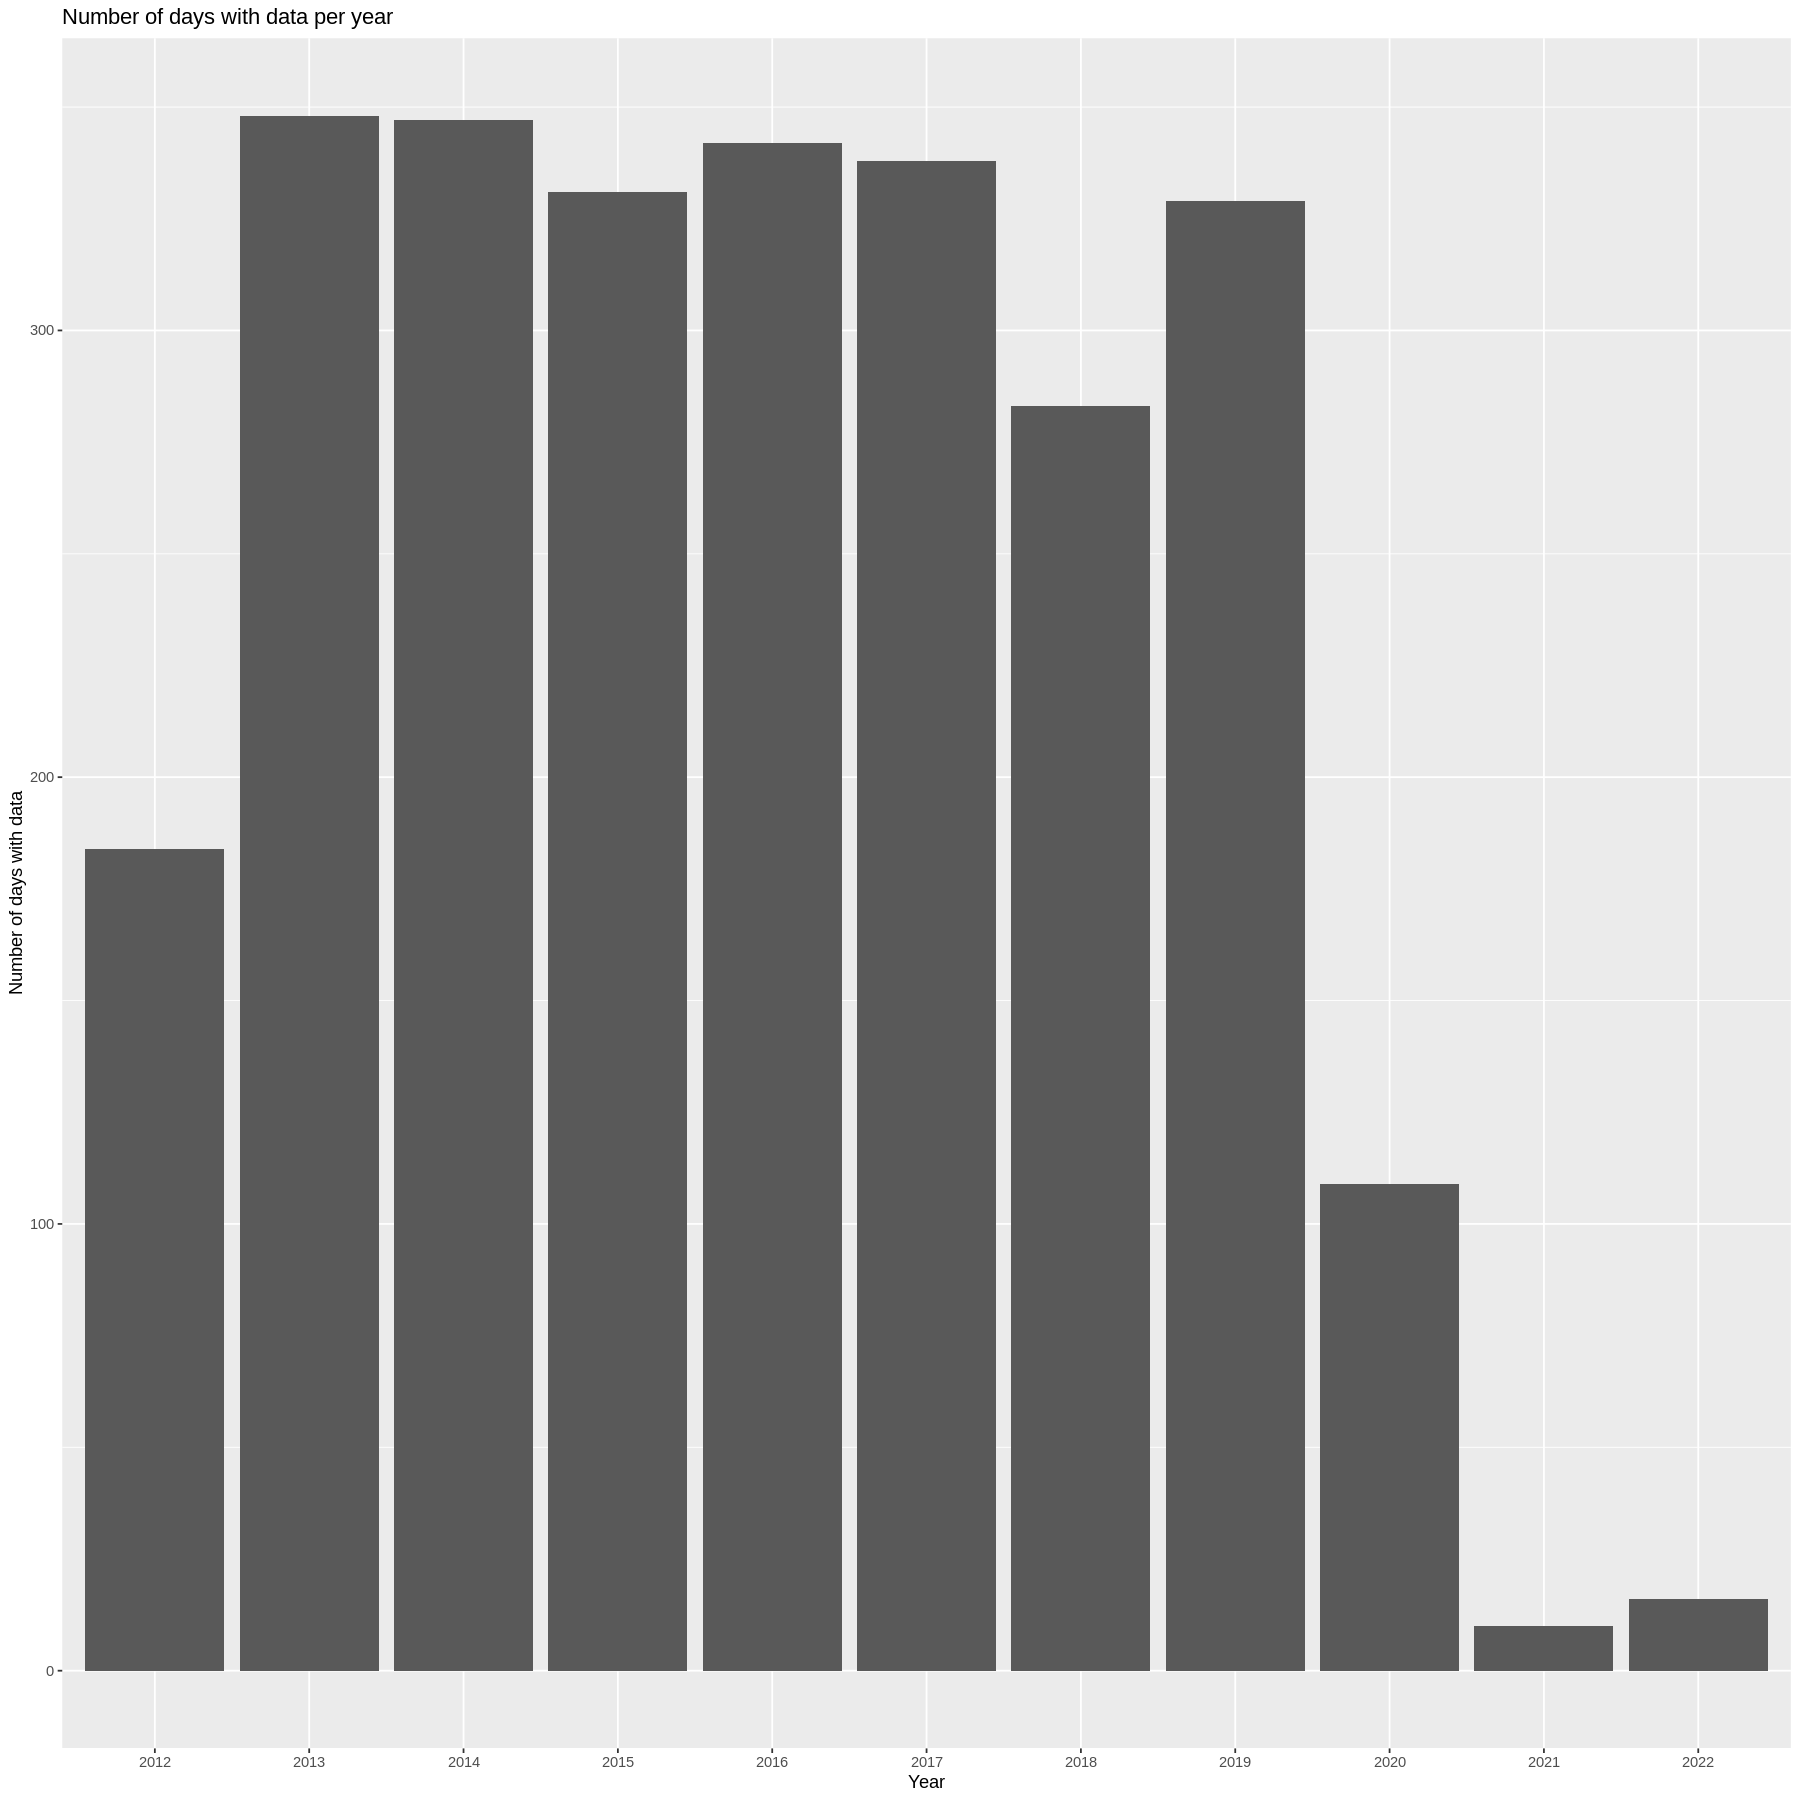

In [7]:
# count number of days
cwt1 %>%
  group_by(year) %>%
  summarise(days_with_data = n()) %>%
  # plot counts
  ggplot(aes(x = as.factor(year), y = days_with_data)) +
  geom_col() +
  labs(x = "Year", y = "Number of days with data",
        title = "Number of days with data per year")

Keeping only rows with data in all three datasets means that the pandemic period has very little data. Earlier it was noted that the number of collisions reduced considerable during the covid pandemic and was yet to recover. Without data for this period, this could be challenging to determine. Therefore, it was proposed to compare the number of collisions to average traffic volumes each day. As the traffic volumes contains a handful of exceedingly large values, a logarithmic scale was adopted.

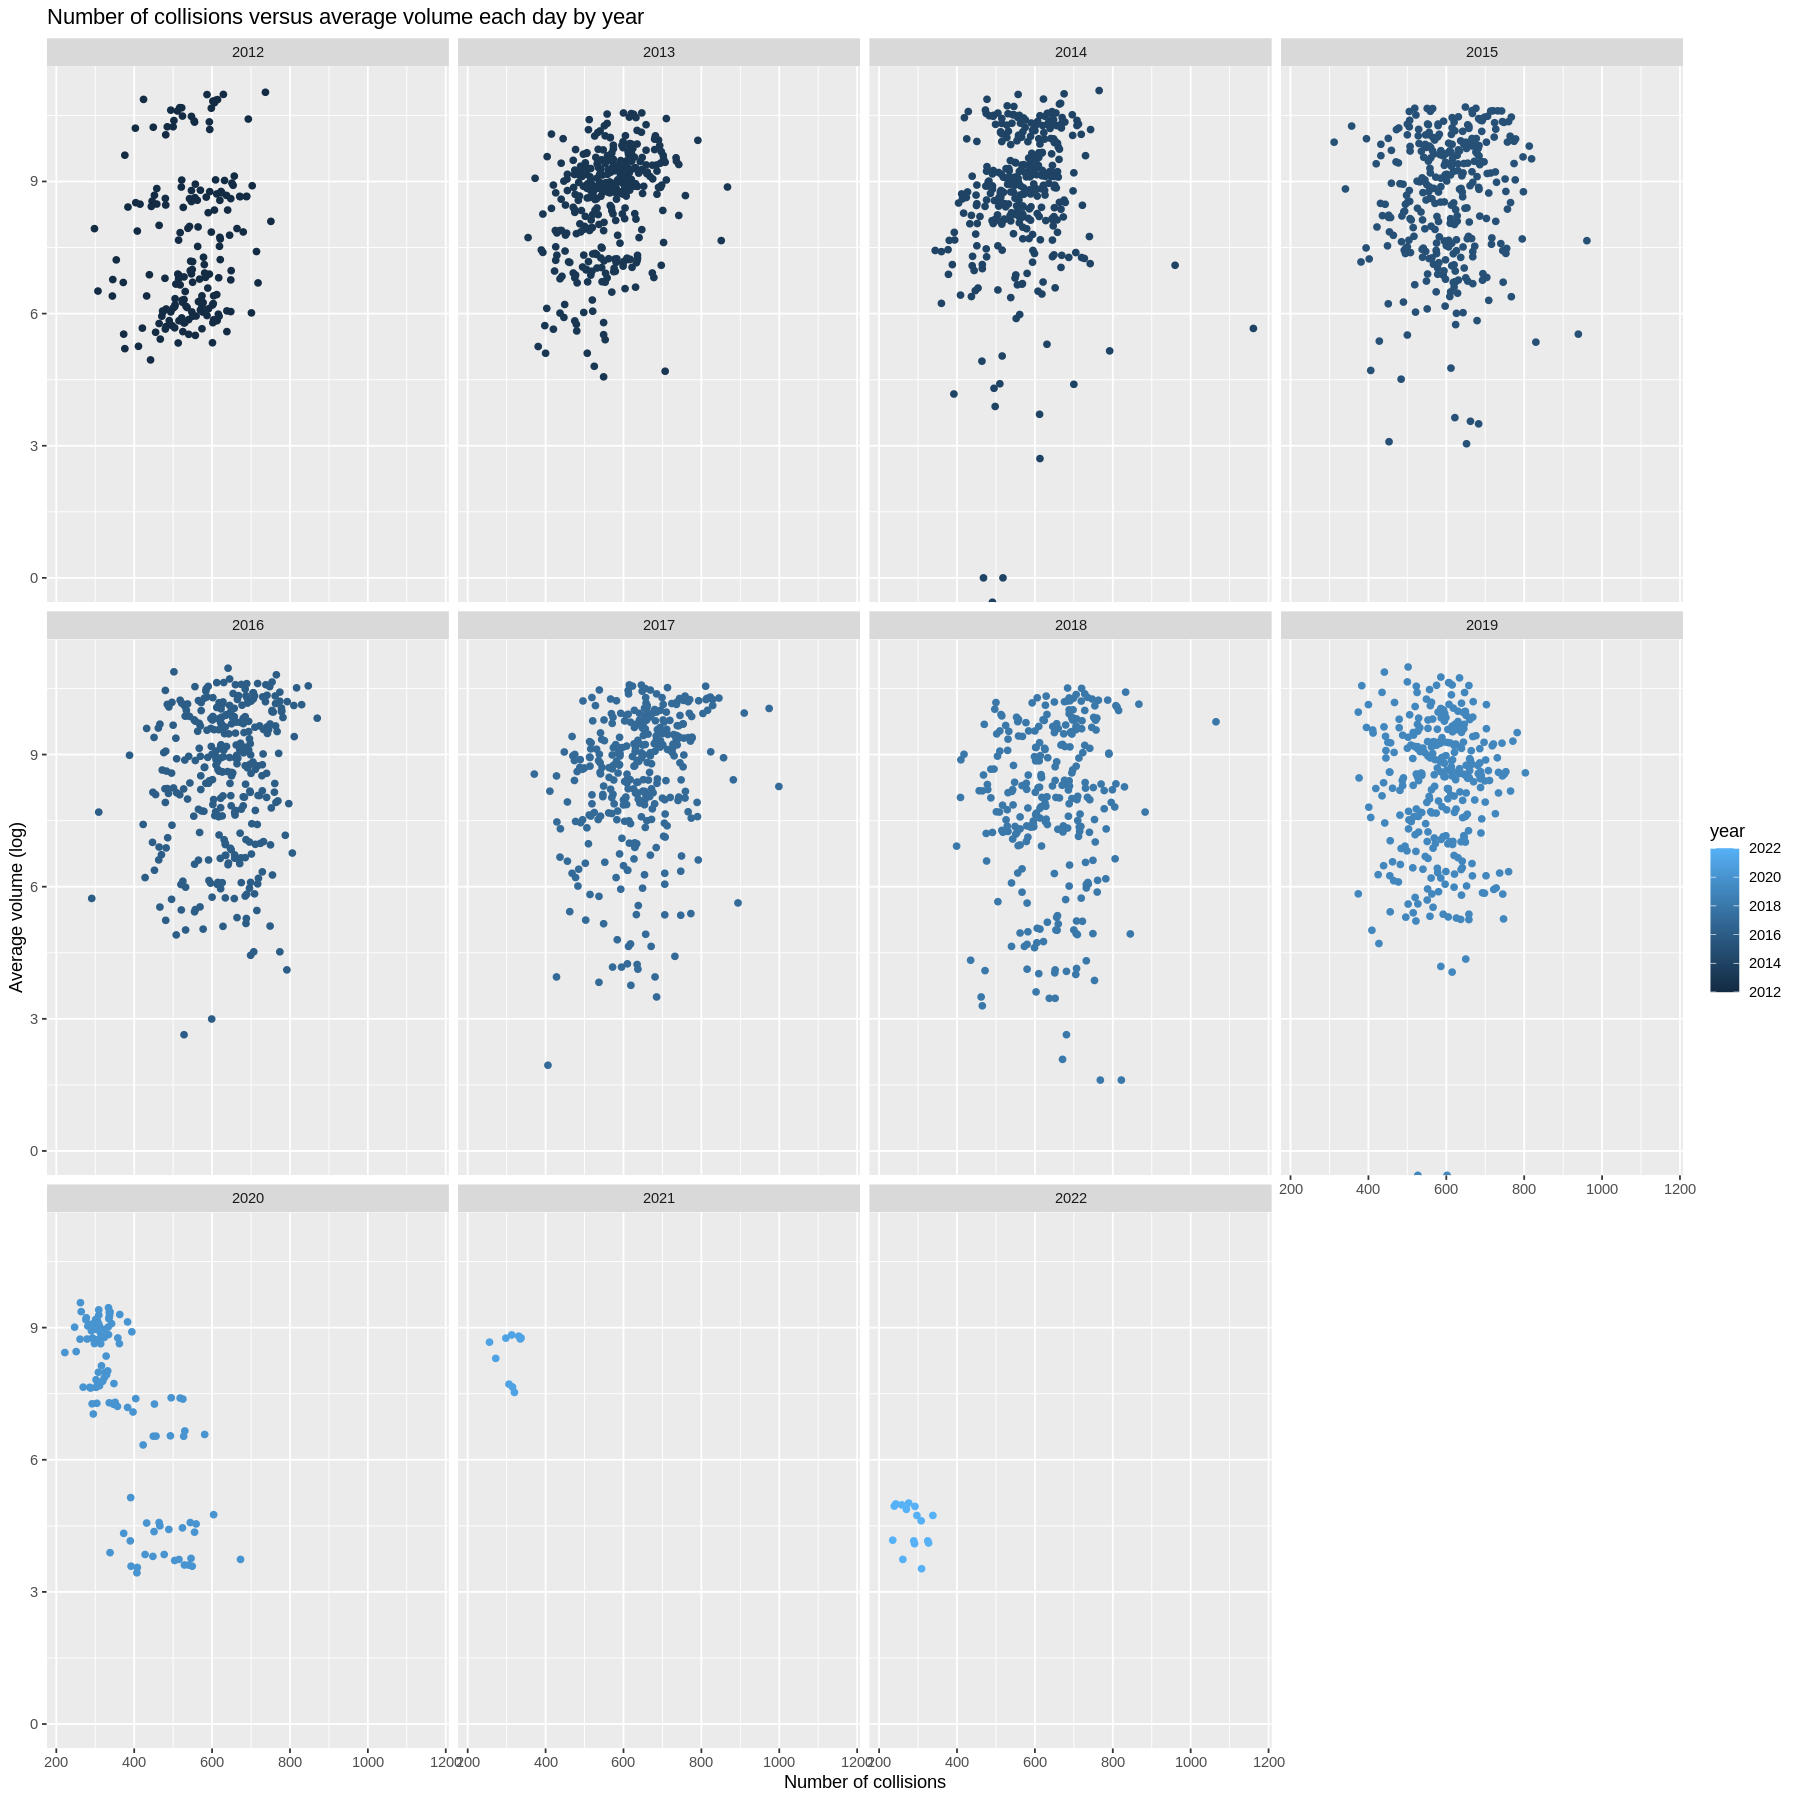

In [8]:
# display results as a chart
cwt1 %>%
  ggplot(aes(x = total_collisions, y = log(avg_vol), colour = year)) +
    geom_point() +
    facet_wrap(~year) +
  labs(x = "Number of collisions", y = "Average volume (log)",
        title = "Number of collisions versus average volume each day by year")

Visually there does not appear to be a correlation between traffic volumes and the number of collisions. This was tested statistically.

In [9]:
# overall correlation
cor(cwt1$total_collisions, cwt1$avg_vol)

# pre-pandemic correlation
cwt1_PP <- filter(cwt1, year < 2020)
cor(cwt1_PP$total_collisions, cwt1_PP$avg_vol)

[1] 0.1769408

[1] 0.1458712

A correlation of 0.18 suggests that there likely is not any correlation between traffic volumes and number of collisions. This worsens to 0.15 when the pandemic data is excluded. This is surprising, however, a possible explanation might be drivers' perception of traffic volumes and the level of risk they are prepared to take. For example, potentially when drivers expect there to be less traffic, they are more likely to take a risk resulting in a collision.

It was considered whether the aggregation to calculate the daily volumes was obfuscating some of the correlation.

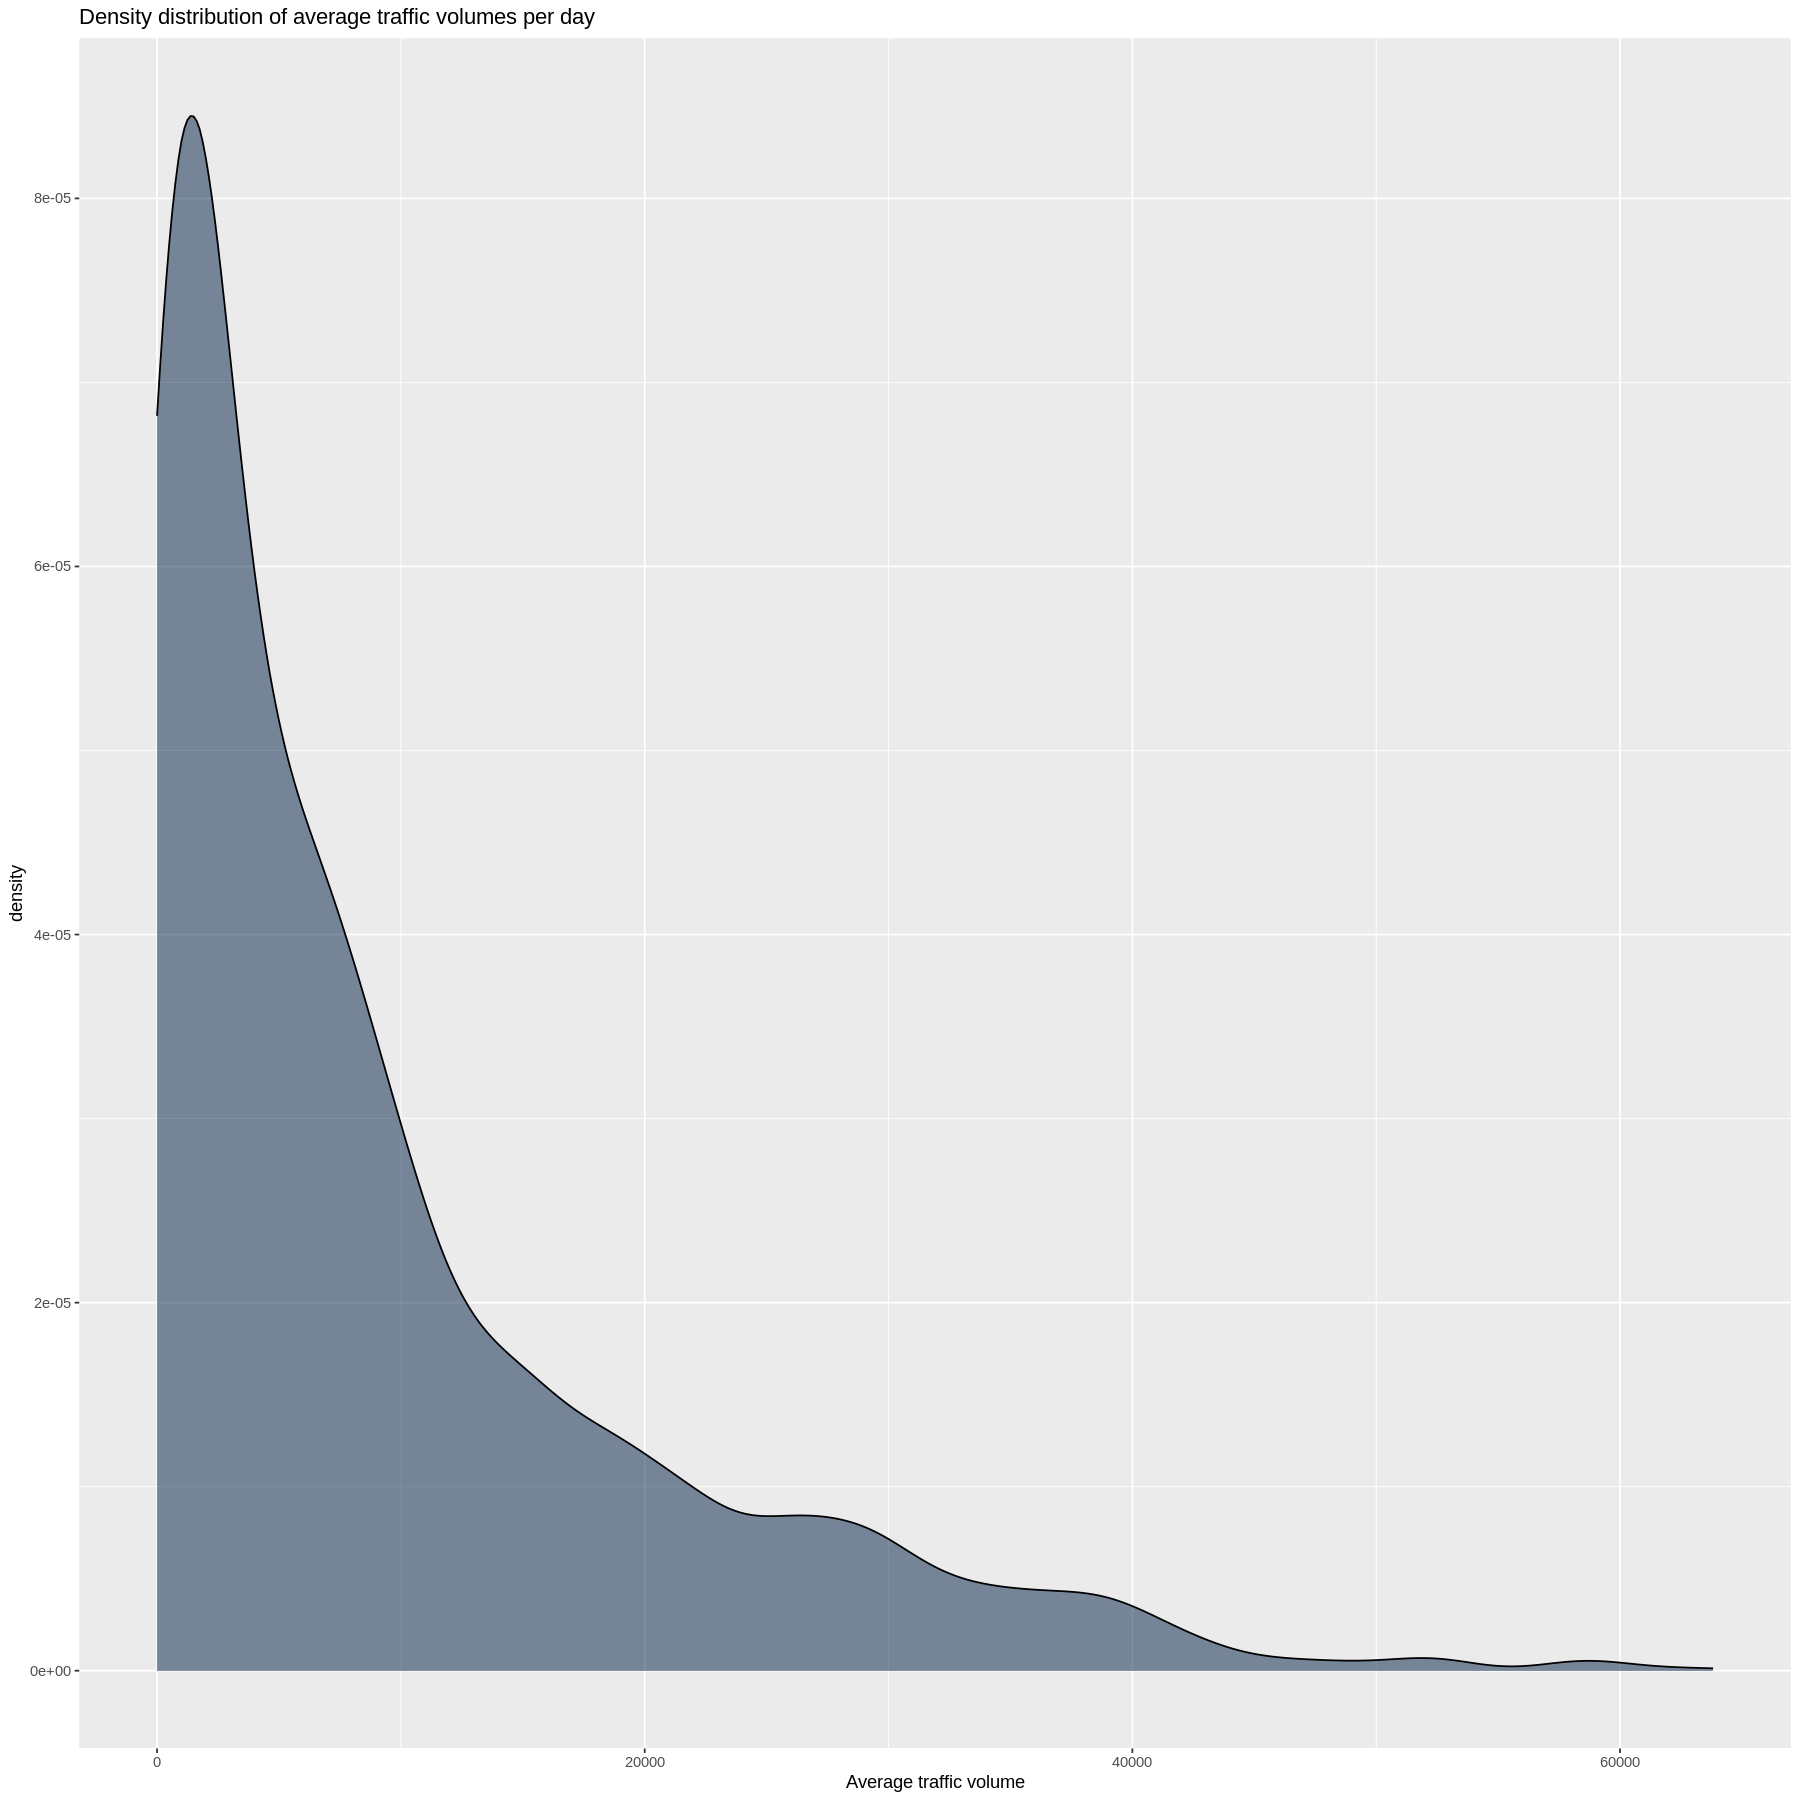

In [10]:
cwt1 %>%
  ggplot() +
  geom_density(aes(x = avg_vol), fill = "#011E45", alpha = 0.5) +
  labs(x = "Average traffic volume",
        title = "Density distribution of average traffic volumes per day")

The average traffic volume is considerably left skewed and a significant number of days reporting 0 vehicles. This seems erroneous, although not impossible.

Given the questions around the quality of the traffic data and its effectiveness to help predict the number of collisions, it was decided not to include it as part of the dataset to build the model.

Before the data was recalculated the quality of the weather dataset was examined.

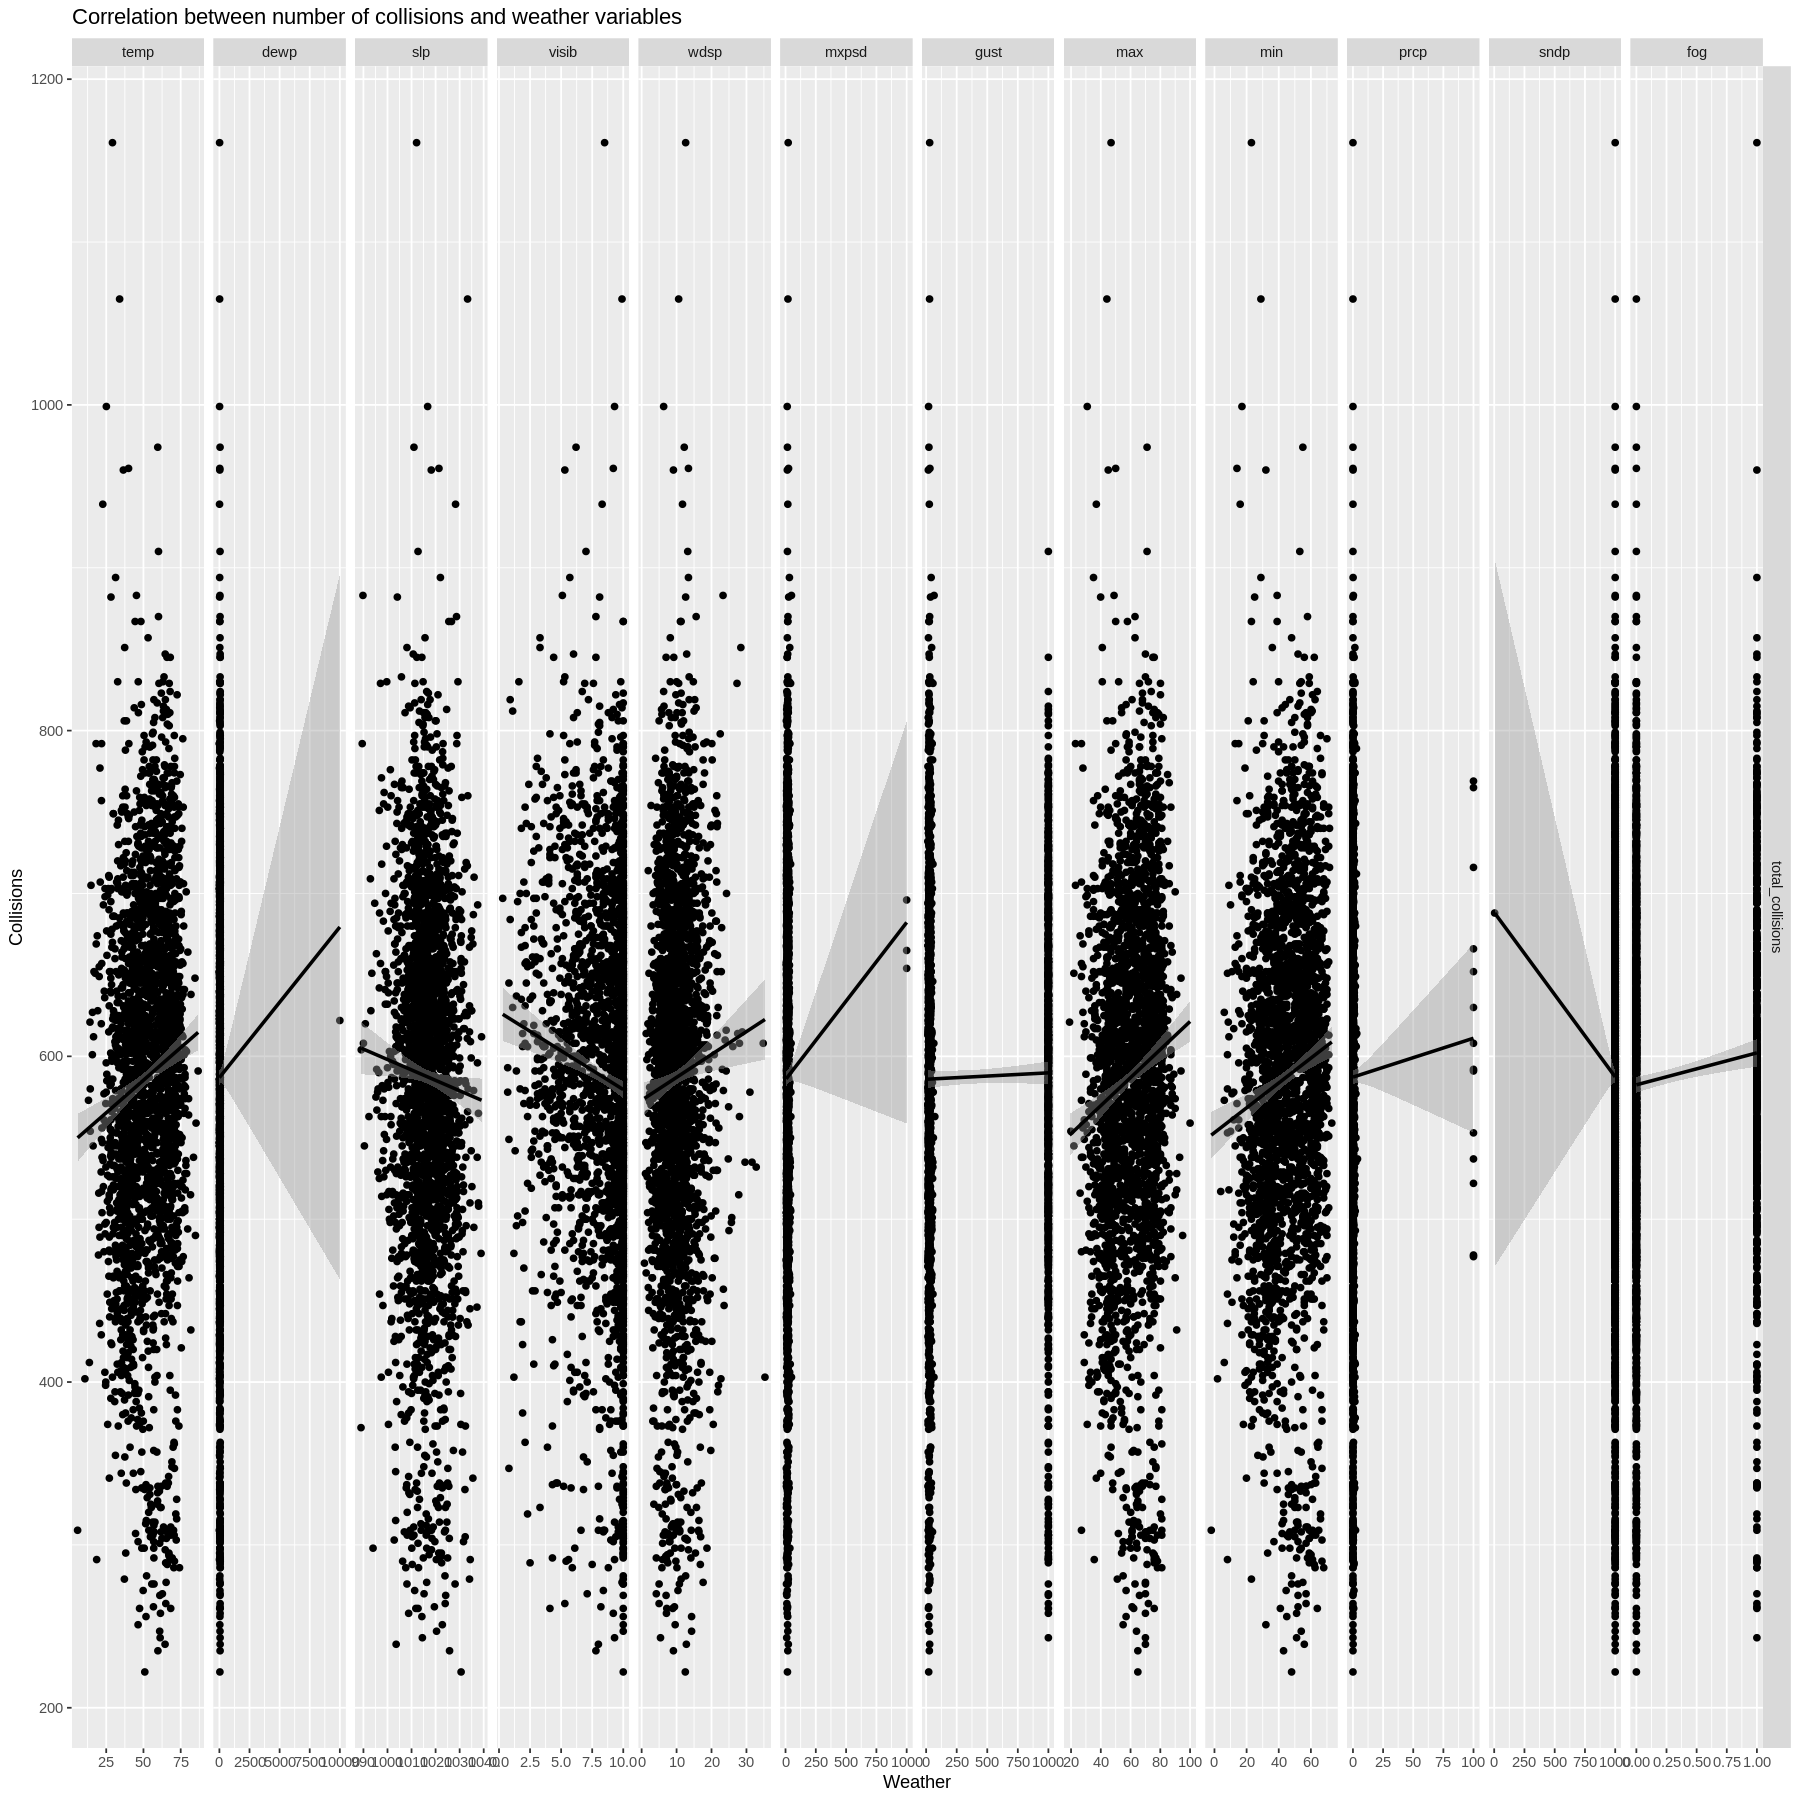

In [11]:
# create list of weather variables
weather_variables <- c("temp", "dewp", "slp", "visib", "wdsp", "mxpsd", "gust",
  "max", "min", "prcp", "sndp", "fog")

# create list of collision counts
collisions <- c("total_collisions")

# plot weather list by collision count list
ggduo(
  cwt1, weather_variables, collisions,
  types = list(continuous = "smooth_lm"),
  title = "Correlation between number of collisions and weather variables",
  xlab = "Weather",
  ylab = "Collisions"
)

Immediately noticeable is some weather variables have exceptionally large values. These are missing entries, marked as 9999.9, 999.9 or 99.99, so these were replaced with nulls. Fog is also incorrectly stored as a string in the raw data, which was missed previously so was also corrected and the dataset recalculated with the updated changes.



```
CREATE VIEW `uhi-project-398119.assignment_part1.weather_2012_to_2023_wo_missing` AS
  SELECT date, year, mo, da,
    NULLIF(temp, 9999.9) as temp_c,
    NULLIF(dewp, 9999.9) as dewp_c,
    NULLIF(slp, 9999.9) as slp_c,
    NULLIF(visib, 999.9) as visib_c,
    NULLIF(wdsp, 999.9) as wdsp_c,
    NULLIF(mxpsd, 999.9) as mxpsd_c,
    NULLIF(gust, 999.9) as gust_c,
    NULLIF(max, 9999.9) as max_c,
    NULLIF(min, 9999.9) as min_c,
    NULLIF(prcp,99.99) as prcp_c,
    NULLIF(sndp, 999.9) as sndp_c,
    CAST(fog AS INT64) as fog_c  
  FROM `uhi-project-398119.assignment_part1.weather_2012_to_2023`;

CREATE TABLE `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v2` AS
  SELECT collisions.year, collisions.month, collisions.day, collisions.day_of_week,
    collisions.date, total_cyclist_injured, total_cyclist_killed,
    total_motorist_injured, total_motorist_killed, total_pedestrians_injured, total_pedestrians_killed,
    total_persons_injured, total_persons_killed, total_vehicles_involved,
    total_collisions, aggressive_driving_road_rage, animals_action, backing_unsafely,
    driver_inattention_distraction, driver_inexperience, driver_unwell_medical,
    environmental_defect_failure, failure_to_keep_right, failure_to_yield_right_of_way,
    following_too_closely, oversized_vehicle, passing_or_lane_usage_improper,
    pedestrian_bicyclist_other_pedestrian_error_confusion, physical_disability,
    reaction_to_uninvolved_vehicle, traffic_control_disregarded, turning_improperly,
    unsafe_speed, vehicle_failure, visual_distraction_obstruction,
    temp_c, dewp_c, slp_c, visib_c, wdsp_c, mxpsd_c, gust_c, max_c, min_c,
    prcp_c, sndp_c, fog_c
  FROM `uhi-project-398119.assignment_part1.collisions_summary` AS collisions
  INNER JOIN `uhi-project-398119.assignment_part1.weather_2012_to_2023_wo_missing` AS weather ON collisions.date = weather.date
  WHERE collisions.year < 2020
  ORDER BY date;

SELECT * FROM `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v2`;
```



Earlier it was noted that there was some seasonality each year.

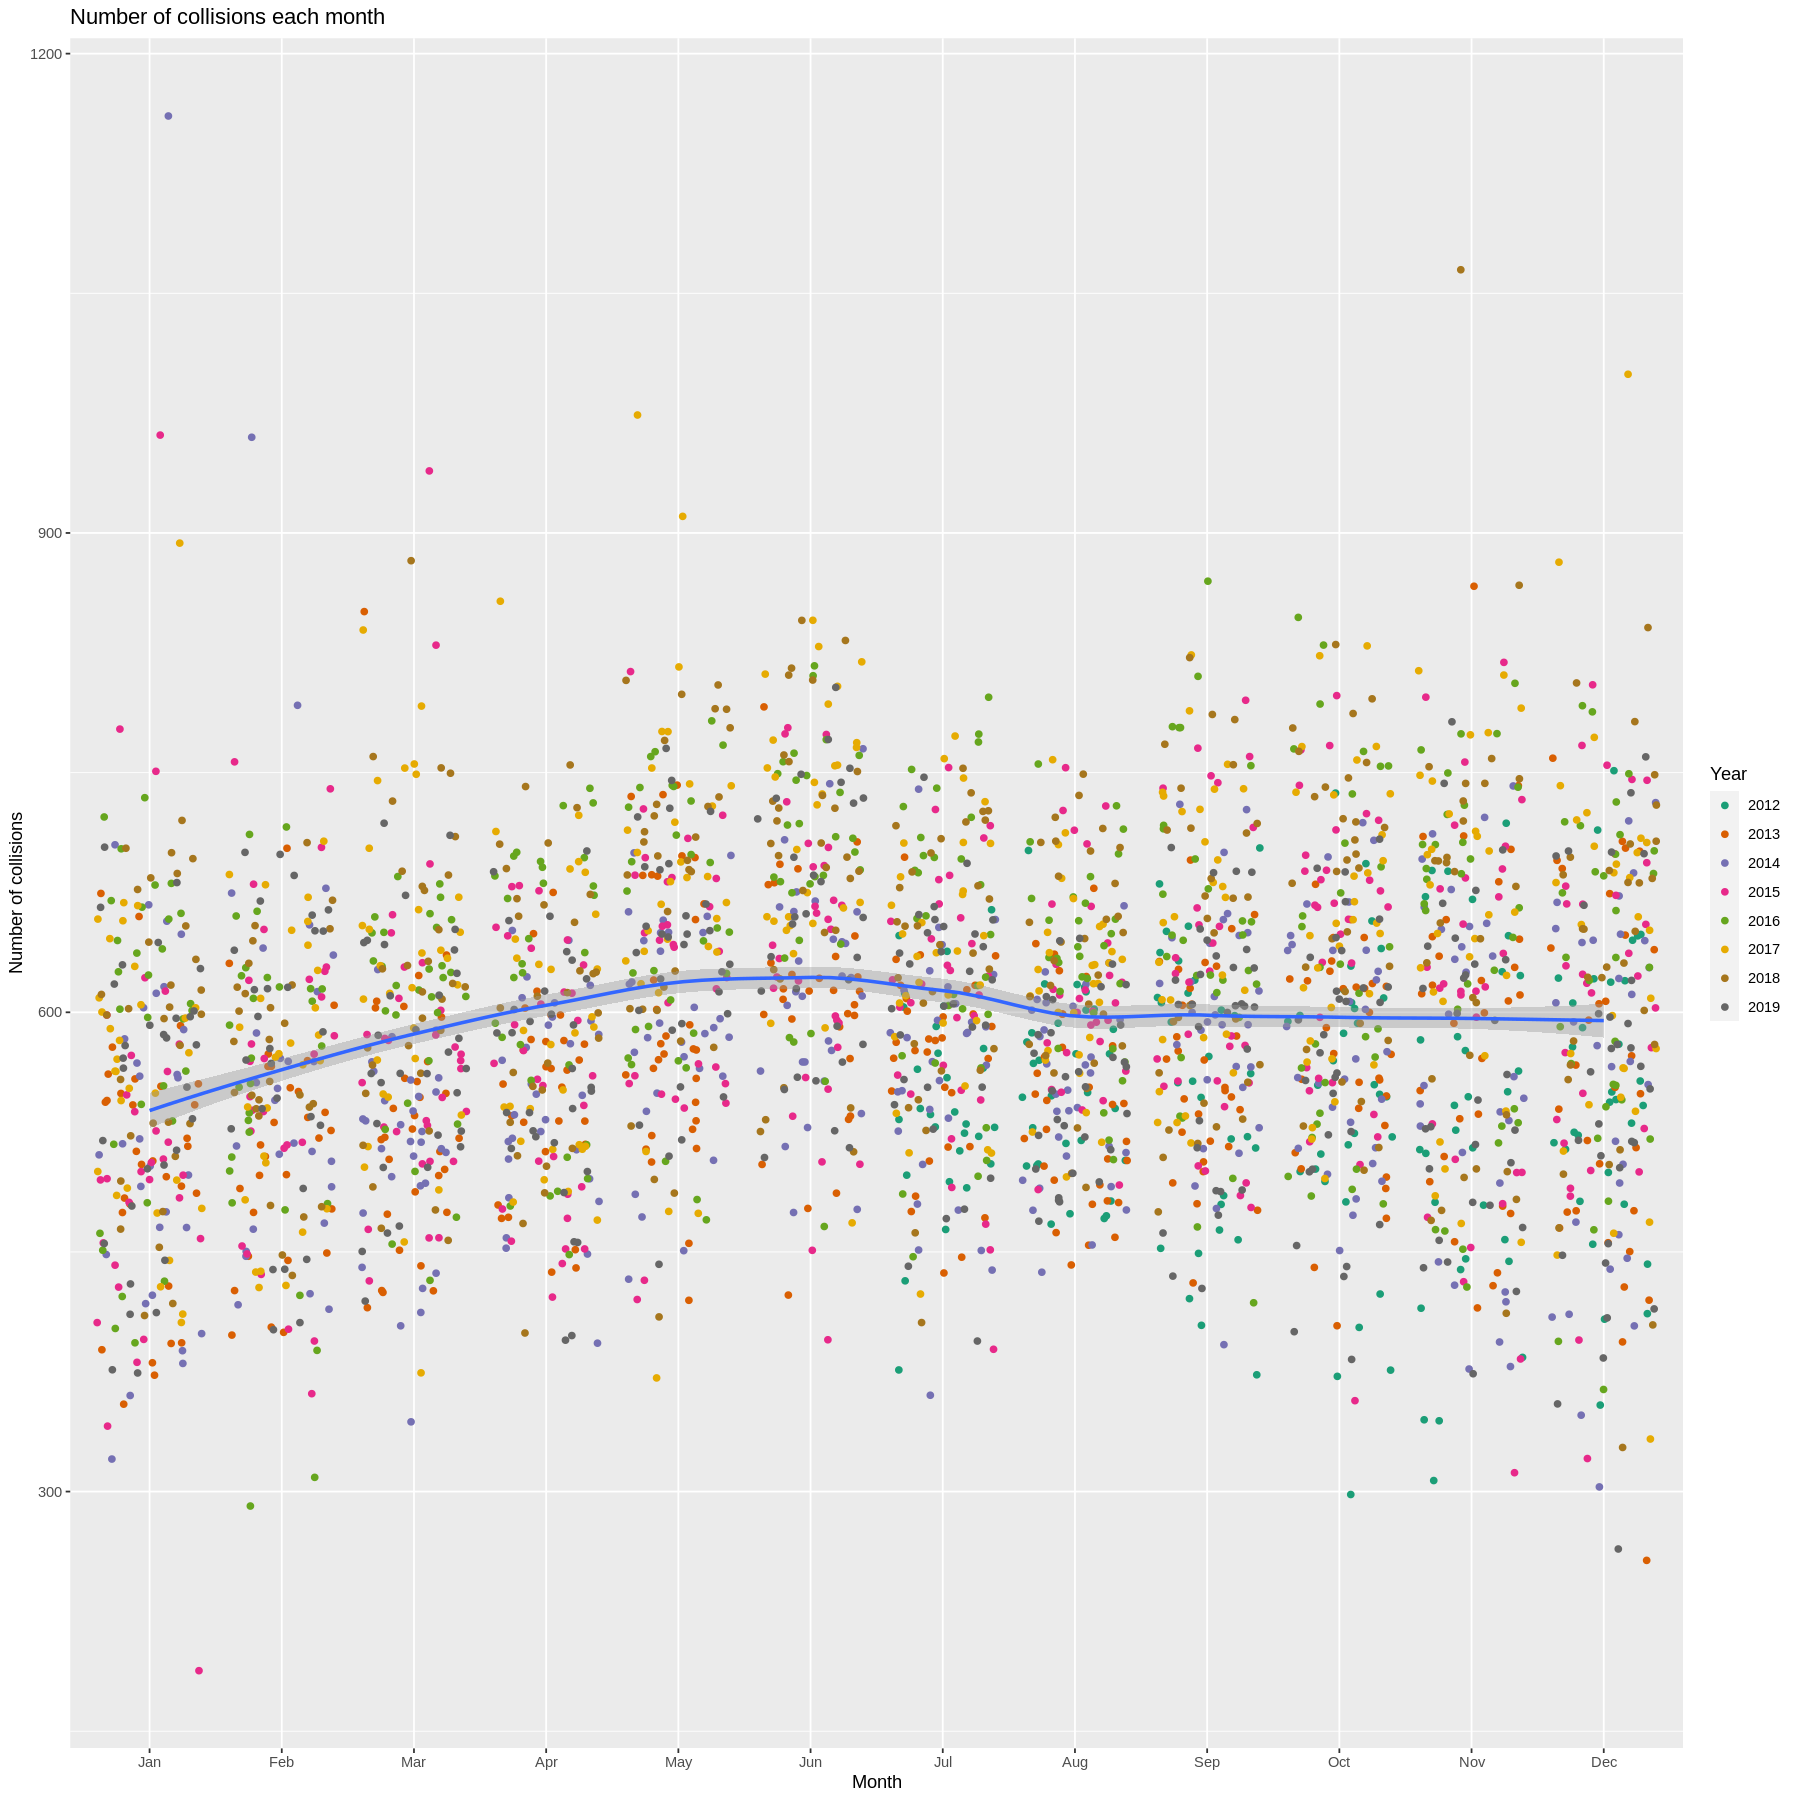

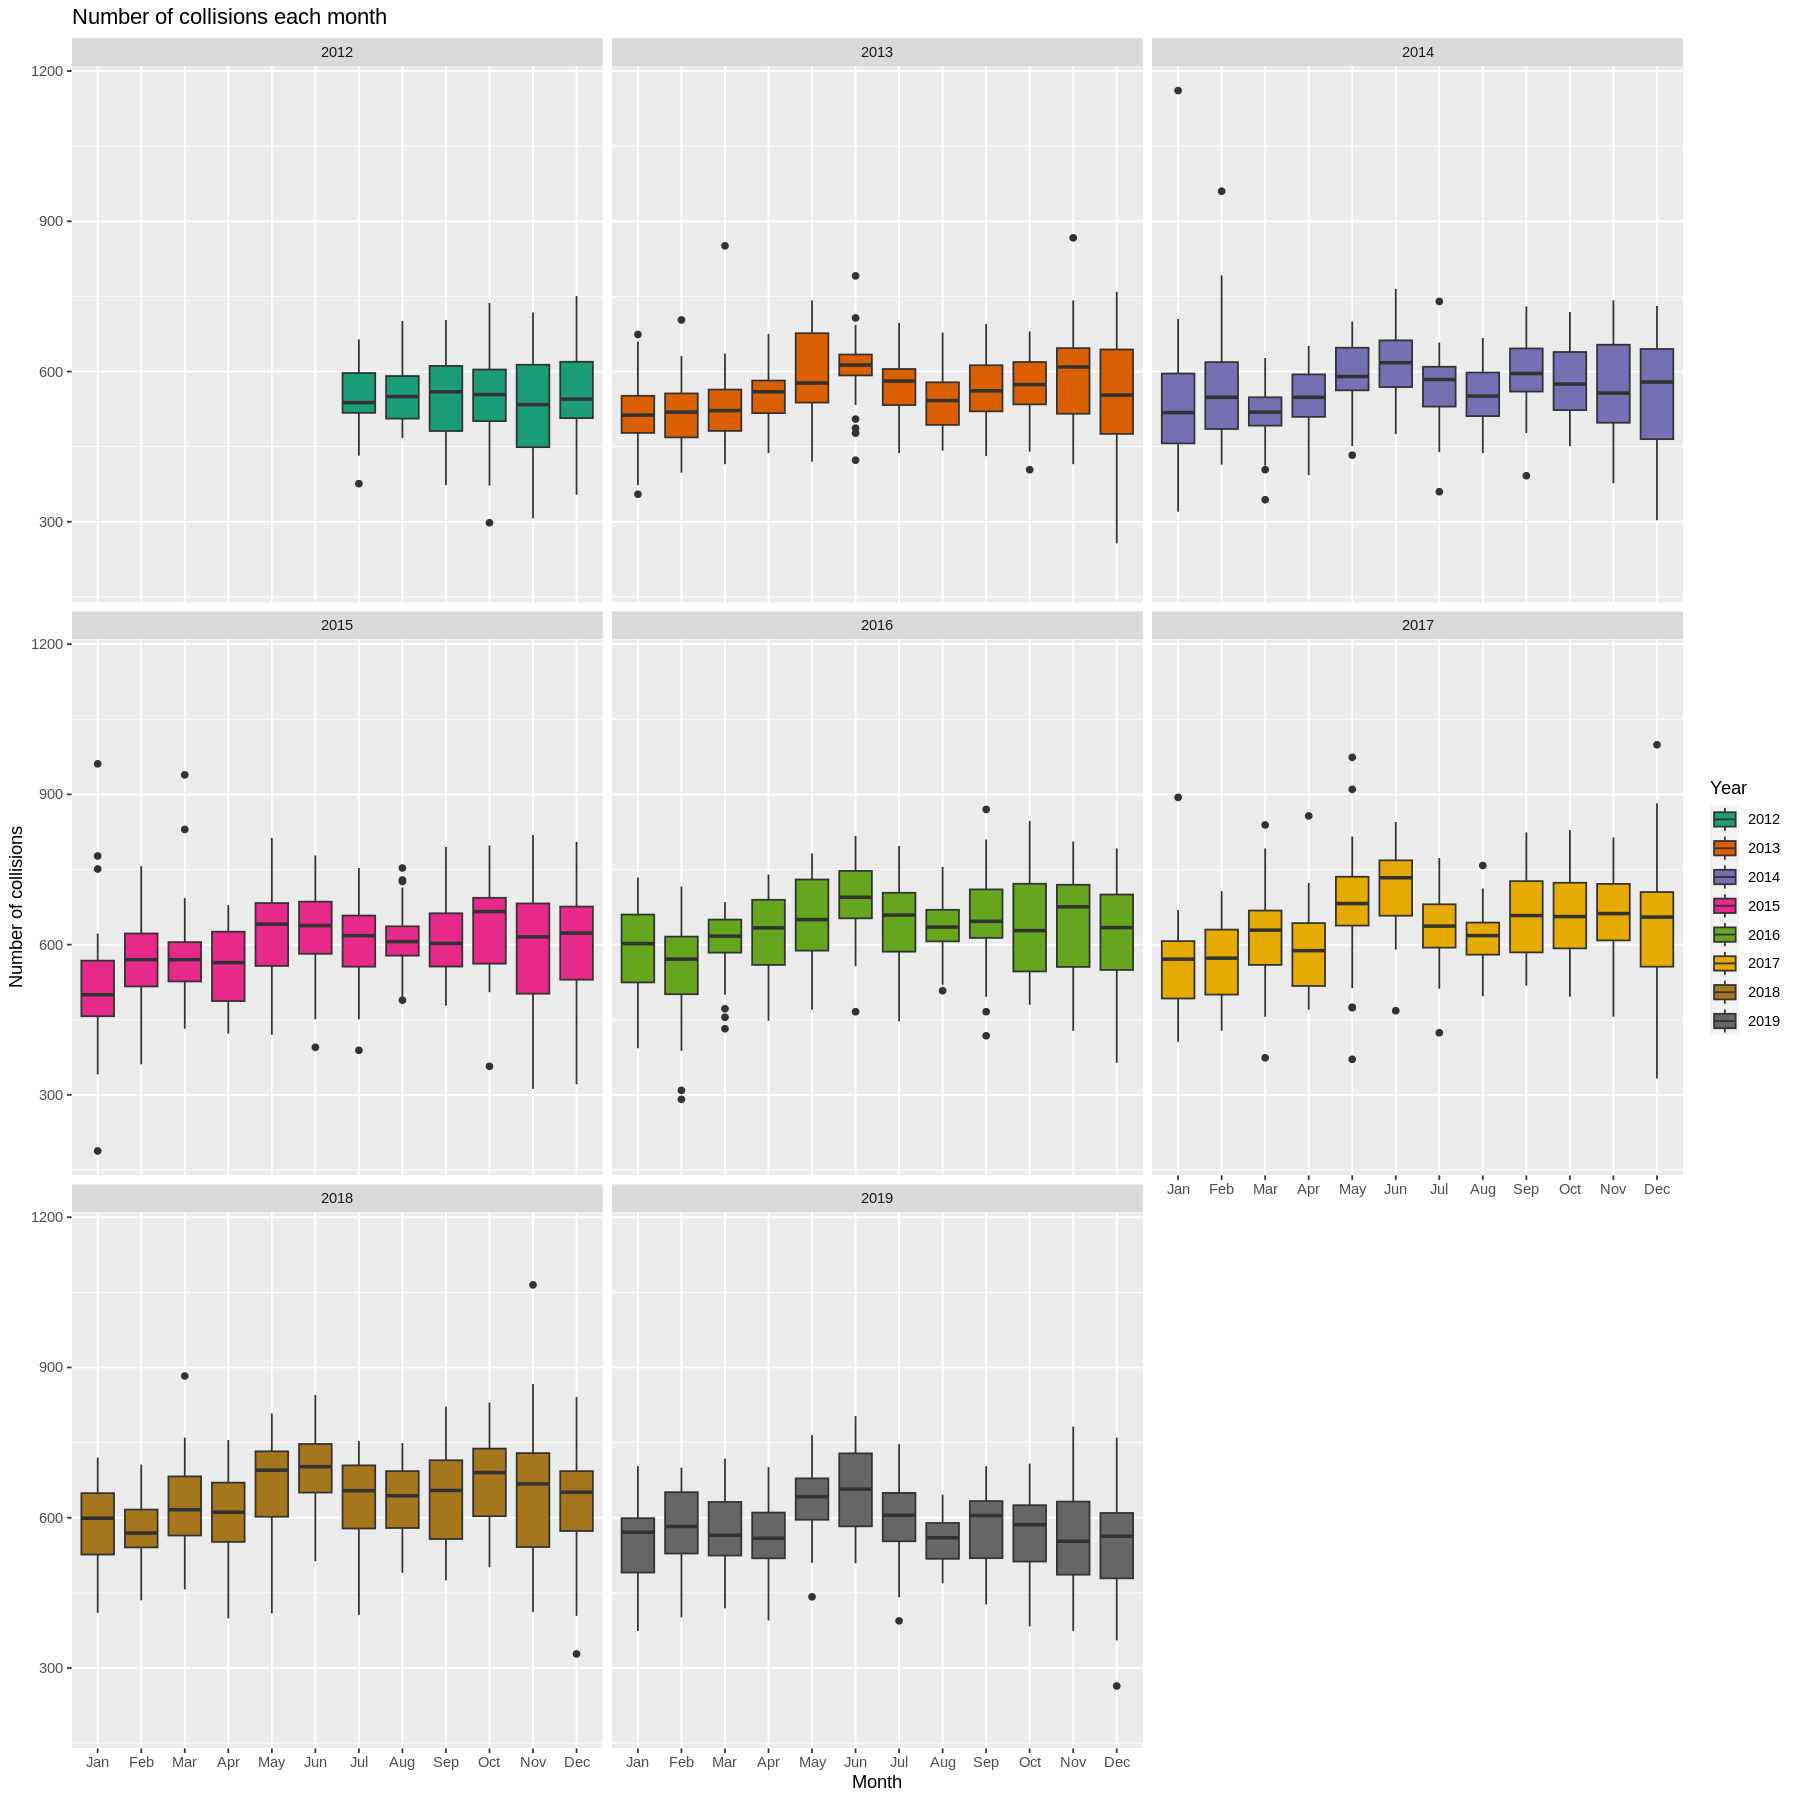

In [12]:
# read in data
cwt2 <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/combined_collisions_weather_traffic_v2.csv",
                  # specify column types to avoid parsing errors
                  col_type = list(.default = col_integer(), date = col_date(),
                    temp_c = col_double(), dewp_c = col_double(),
                    slp_c = col_double(), visib_c = col_double(),
                    wdsp_c = col_double(), mxpsd_c = col_double(),
                    gust_c = col_double(), max_c = col_double(),
                    min_c = col_double(), prcp_c = col_double(),
                    sndp_c = col_double())
                    )

# plot showing collisions per month with year by colour
cwt2 %>%
  ggplot() +
  scale_colour_brewer(palette = "Dark2") +
  geom_point(aes(x = as.factor(month), y = total_collisions, colour = as.factor(year)), position = "jitter") +
  scale_x_discrete(labels = month.abb) +
  geom_smooth(aes(x = month, y = total_collisions), method = "loess", formula = "y ~ x") +
  labs(x = "Month", y = "Number of collisions",
        title = "Number of collisions each month",
        colour = "Year")

# plot showing collisions per month with year by facet
cwt2 %>%
  ggplot(aes(x = as.factor(month), y = total_collisions, fill = as.factor(year))) +
  scale_fill_brewer(palette = "Dark2") +
  geom_boxplot() +
  scale_x_discrete(labels = month.abb) +
  facet_wrap(~year) +
  labs(x = "Month", y = "Number of collisions",
        title = "Number of collisions each month",
        fill = "Year")

The plots suggest the pattern between month and the total number of collisions each year is broadly the same. This might be due to weather changes each season. It is not a direct linear relationship, with the number of collisions increasing and decreasing throughout the year.

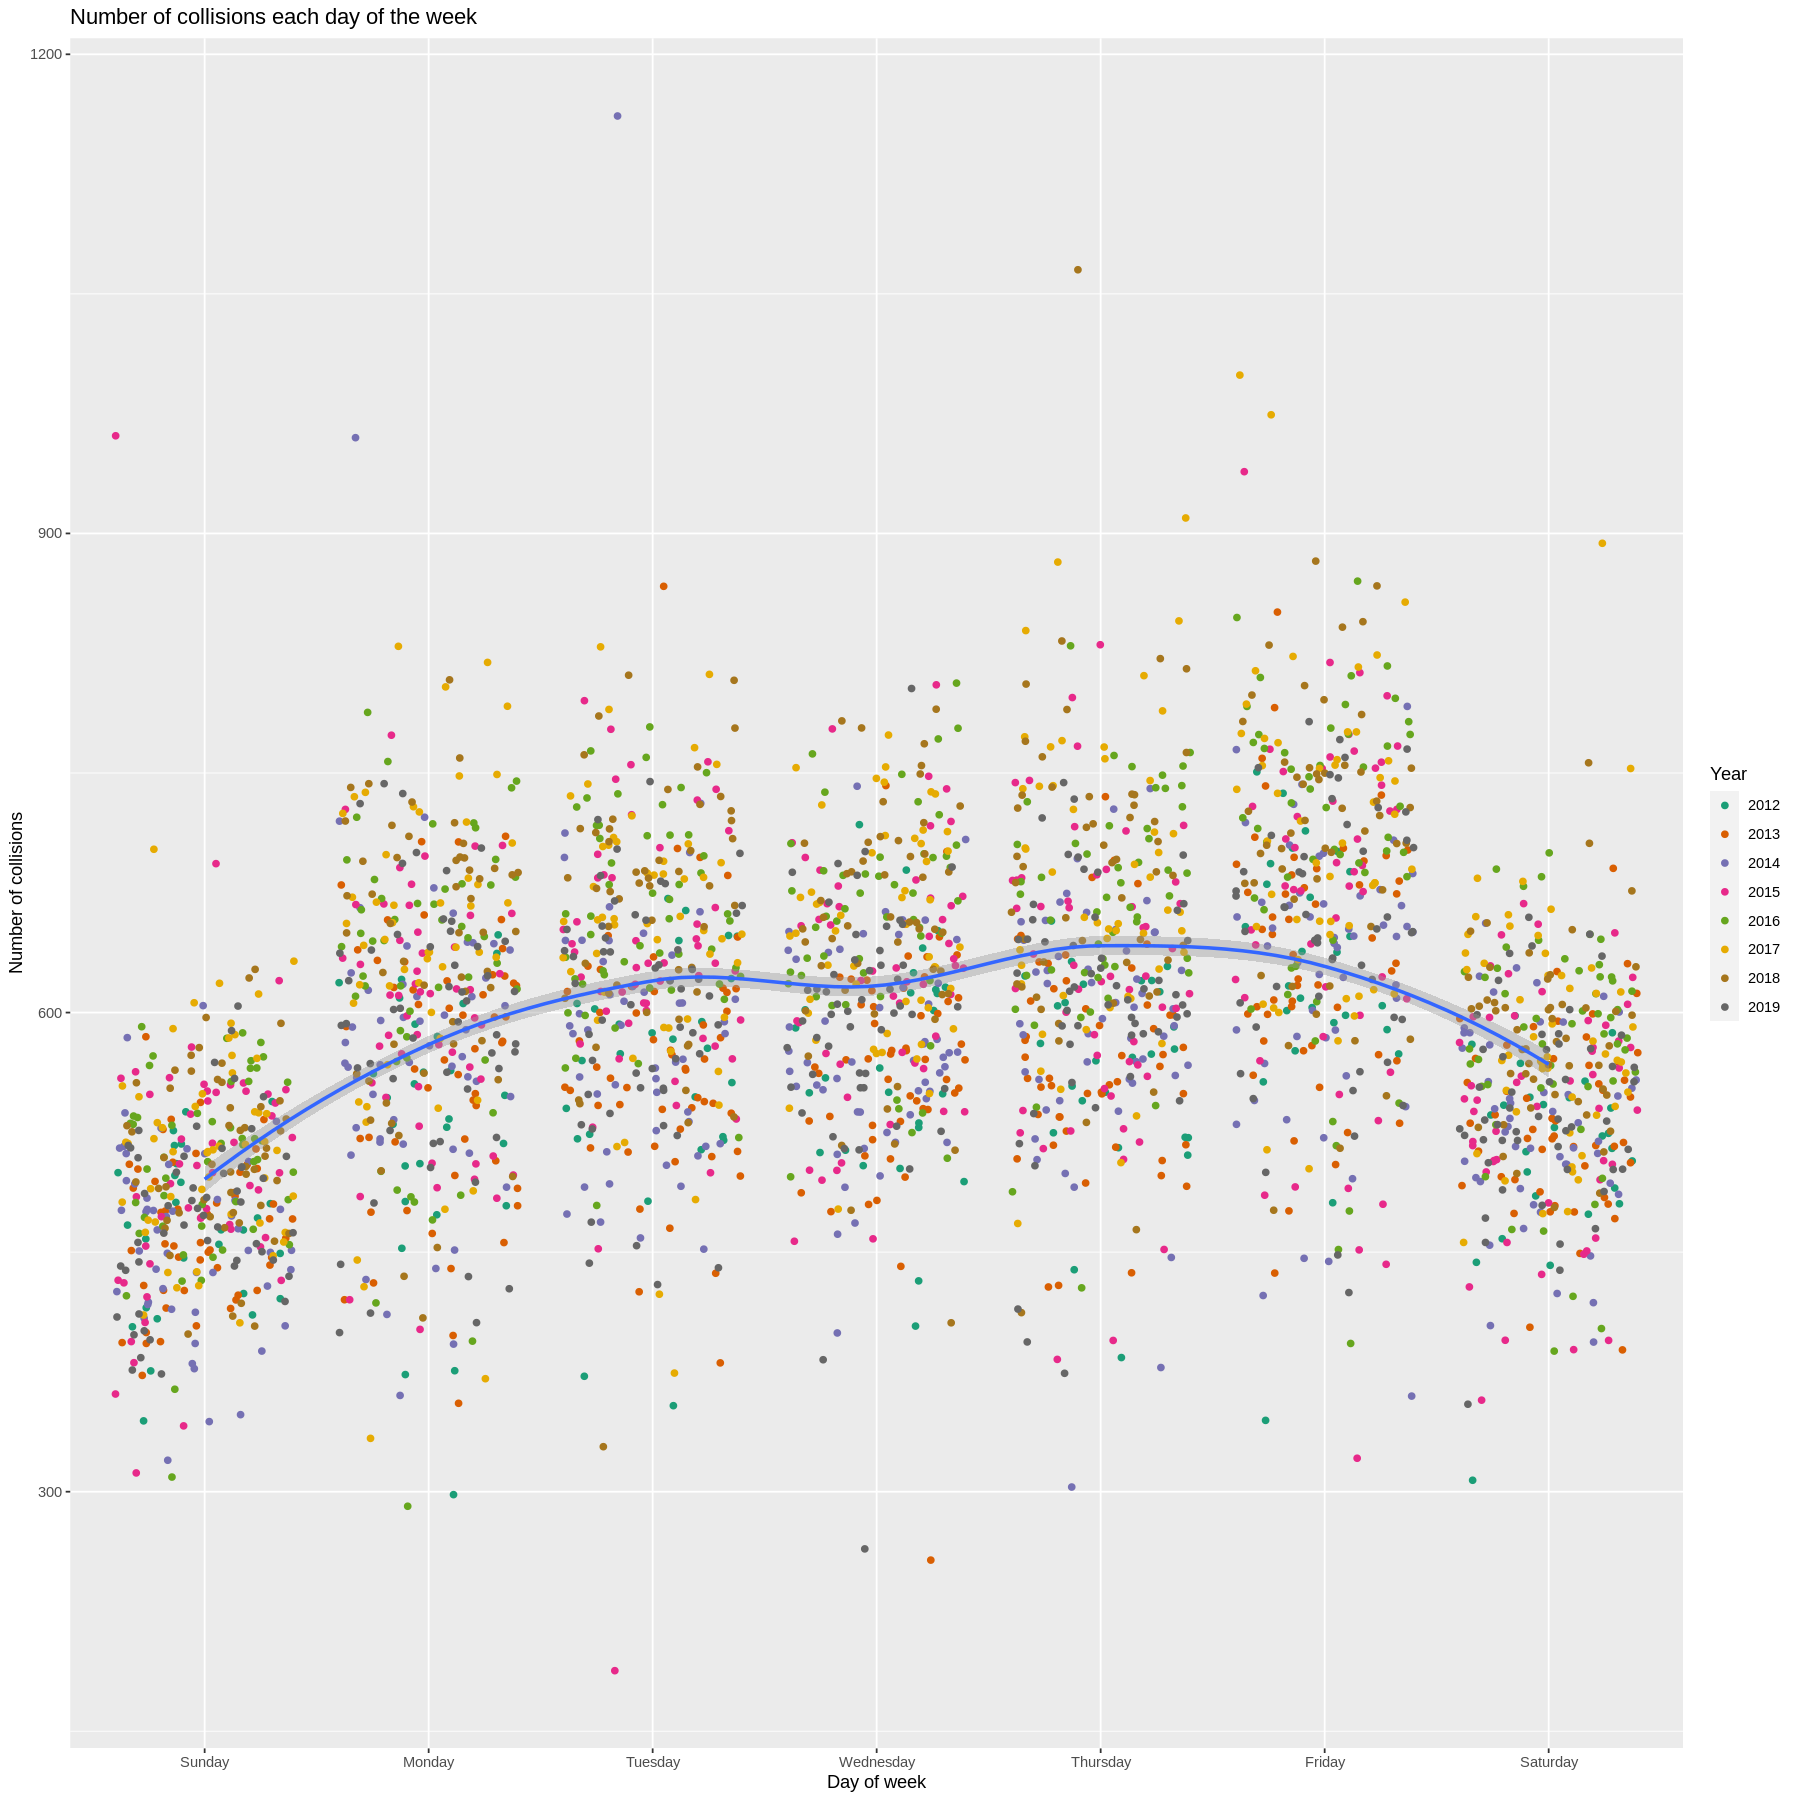

In [13]:
# plot showing collisions per year by colour
cwt2 %>%
  ggplot() +
  scale_colour_brewer(palette = "Dark2") +
  geom_point(aes(x = as.factor(day_of_week), y = total_collisions, colour = as.factor(year)), position = "jitter") +
  scale_x_discrete(labels = c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")) +
  geom_smooth(aes(x = day_of_week, y = total_collisions), method = "loess", formula = "y ~ x") +
  labs(x = "Day of week", y = "Number of collisions",
        title = "Number of collisions each day of the week",
        colour = "Year")

However, this plot suggests there is also a link between the number of collisions and the day of the week, with more collisions occurring during weekdays than weekends. This suggests that weather cannot be the only related factor.

The traffic volume data trialled before was not deemed to be of good enough quality to be useful. However, NYC also has a traffic speeds dataset (New York City Department of Transportation 2024). Unlike the volume count, it also includes a link (ID = 4616228) that was in use for nearly the whole of the specified period. This was compared to the mean results of the rest of the data to understand how much variation exists across the city. The link is on the I-87 in Bronx.



```
CREATE VIEW `uhi-project-398119.assignment_part1.traffic_speeds_comparison` AS
SELECT
  all_traffic.date,
  all_traffic.avg_speed AS avg_speed_all,
  i87_traffic.avg_speed AS avg_speed_i87,
  all_traffic.min_speed AS min_speed_all,
  i87_traffic.min_speed AS min_speed_i87,
  all_traffic.max_speed AS max_speed_all,
  i87_traffic.max_speed AS max_speed_i87,
  FROM `uhi-project-398119.assignment_part1.DOT_traffic_speeds_all` AS all_traffic
  INNER JOIN `uhi-project-398119.assignment_part1.Avg_Traffic_Speeds_4616228` AS i87_traffic
    ON all_traffic.date = i87_traffic.date;
```



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


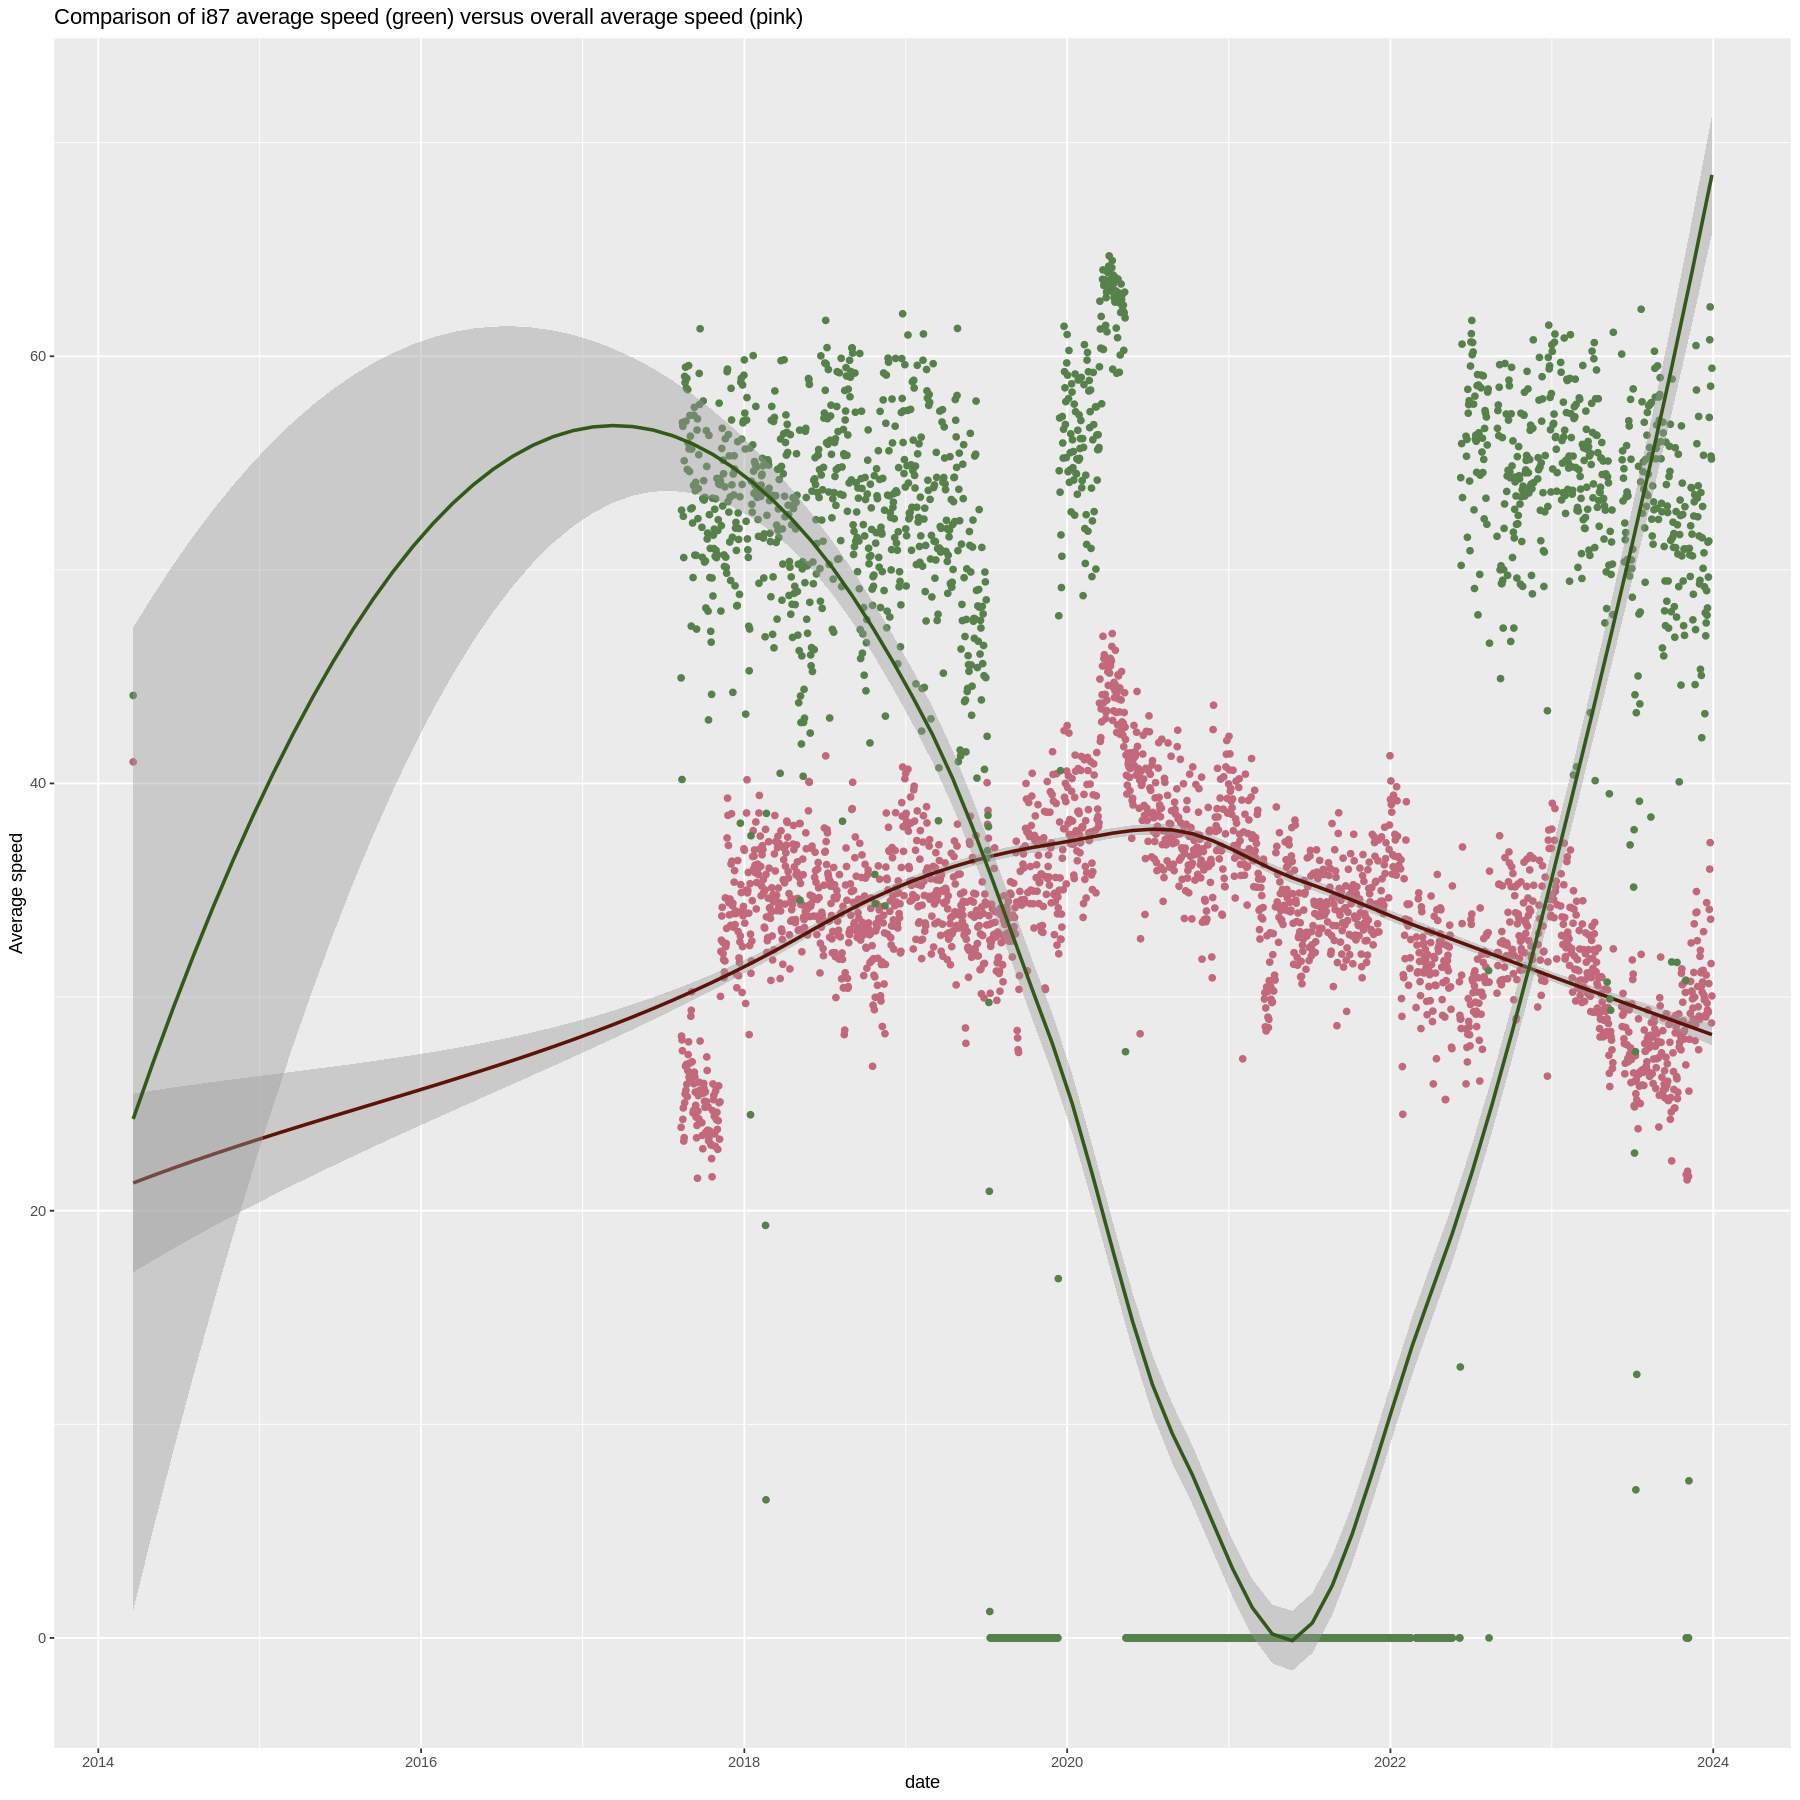

In [14]:
# read in data
tsc <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/traffic_speeds_comparison.csv", show_col_types = FALSE)

# plot data
tsc %>%
  ggplot() +
  geom_point(aes(x = date, y = avg_speed_all), colour = "#c3687a") +
  geom_smooth(aes(x = date, y = avg_speed_all), colour = "#5c1409", method = "loess") +
  geom_point(aes(x = date, y = avg_speed_i87), colour = "#57814a") +
  geom_smooth(aes(x = date, y = avg_speed_i87), colour = "#325917", method = "loess") +
  labs(x = "date", y = "Average speed", title = "Comparison of i87 average speed (green) versus overall average speed (pink)")

Observed from the chart, the i87 tracker did not record any vehicle speeds during parts of the pandemic, however, other cameras across the city were still in operation and data has been captured consistently since the start of 2018. The two sets of data were compared, ignoring any values of 0.

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


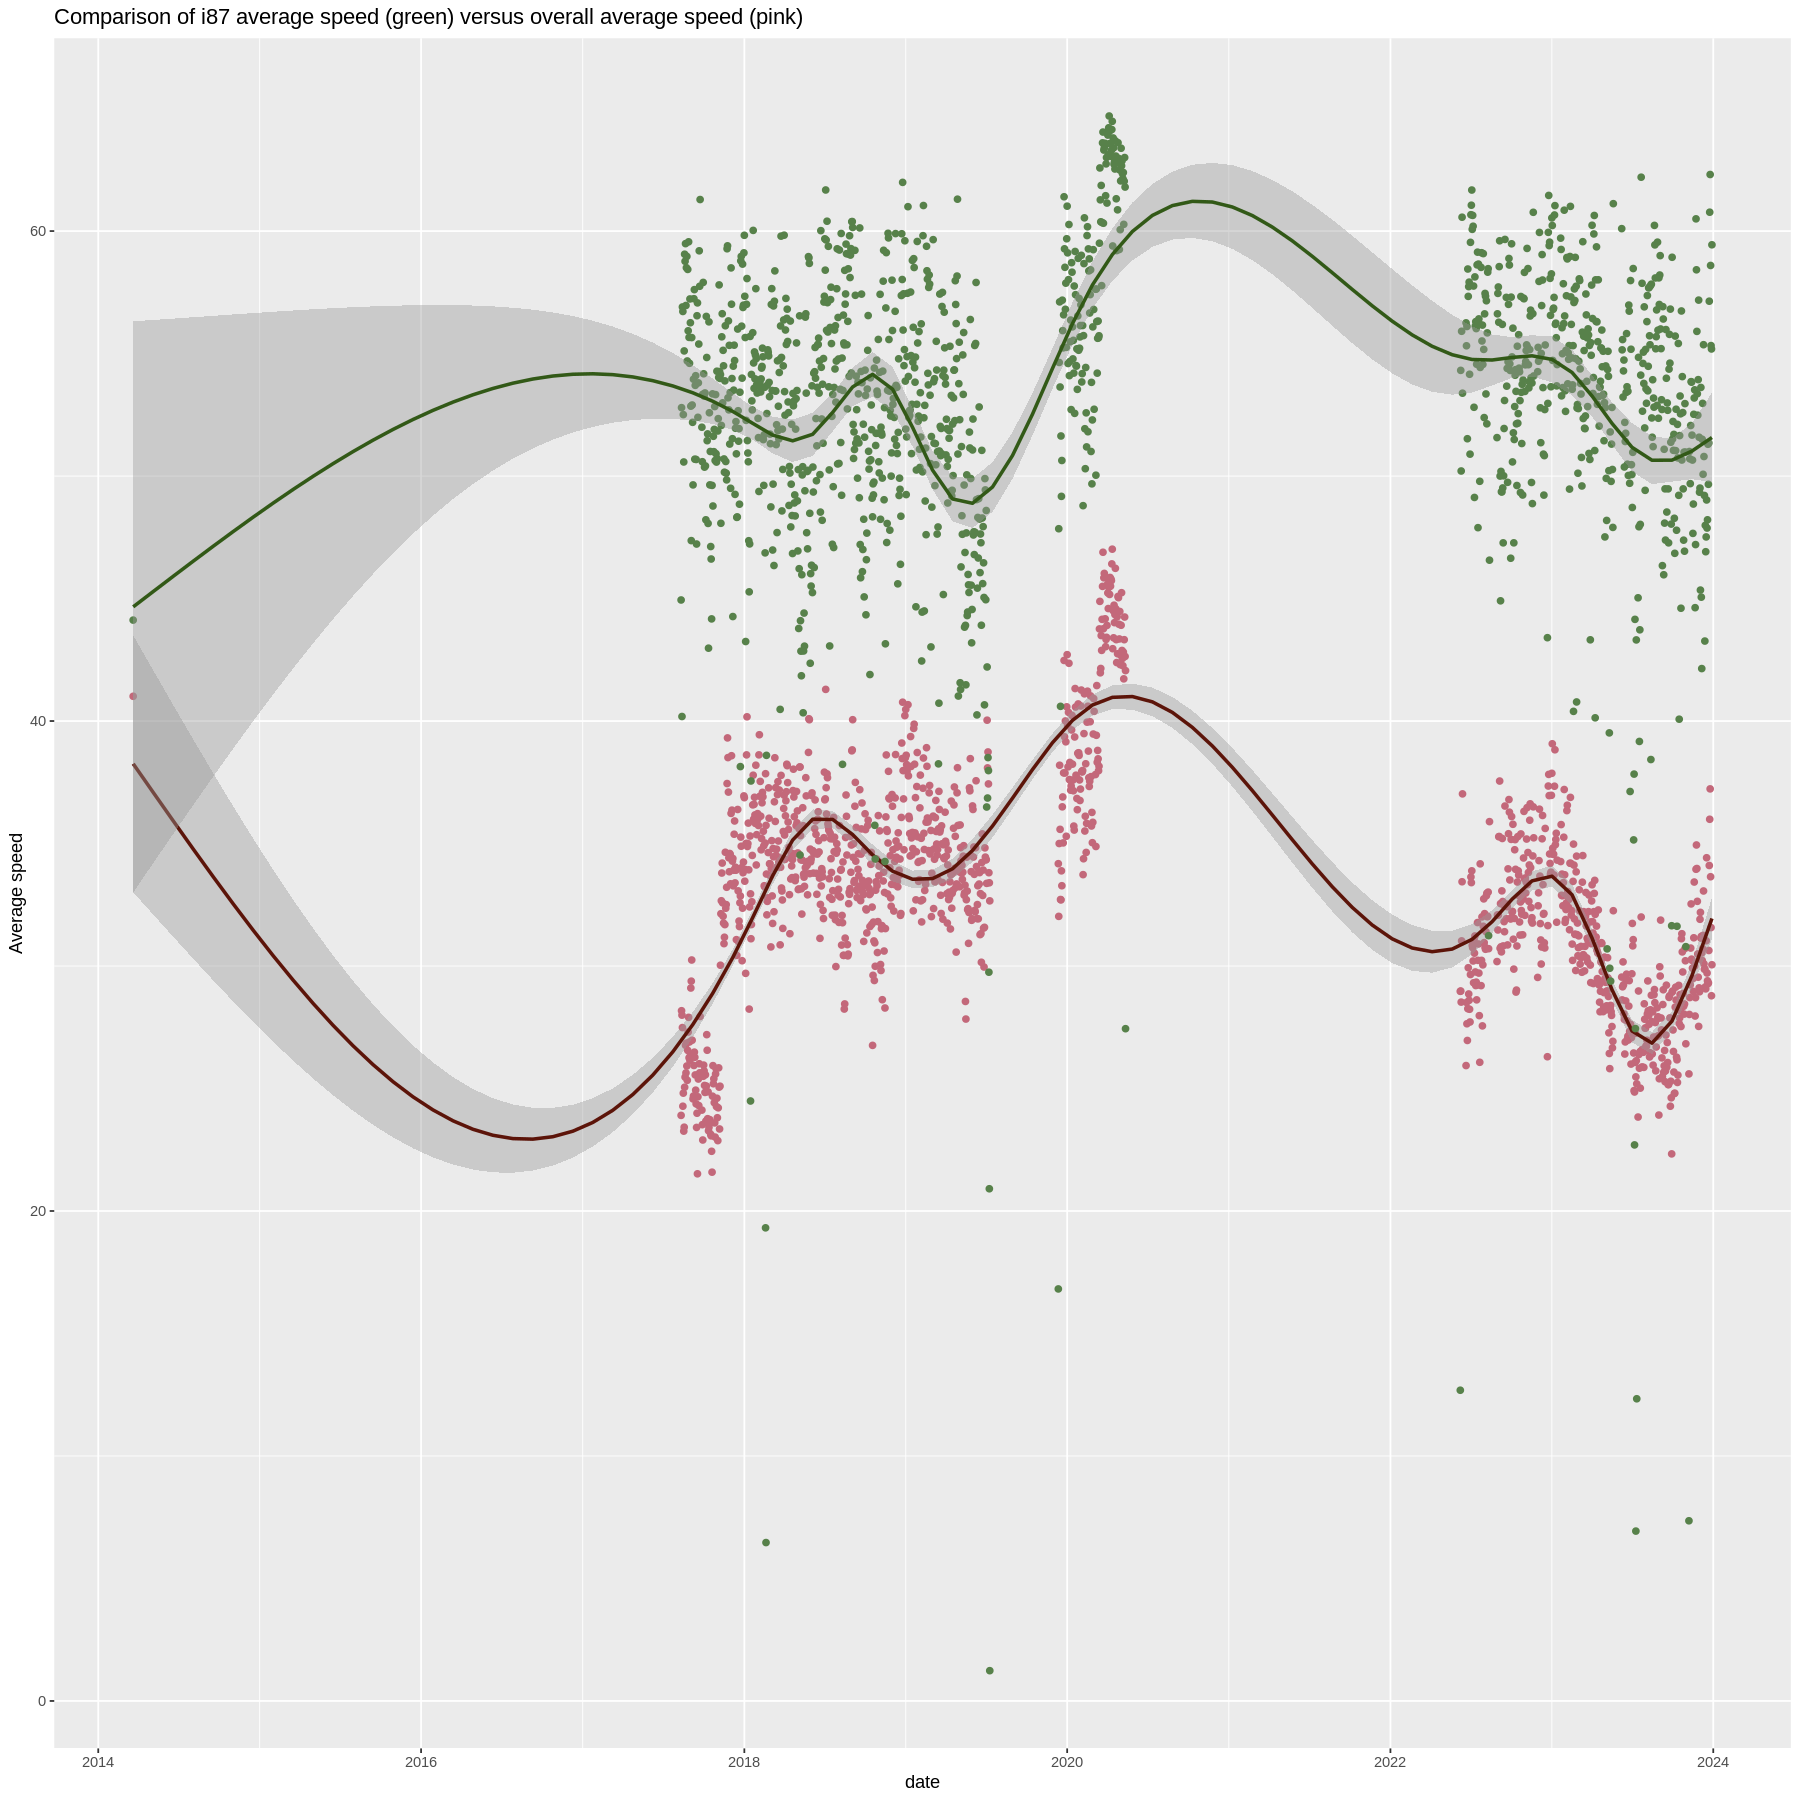

In [15]:
# redraw plot without 0 values
tsc %>%
  filter(avg_speed_all > 0, avg_speed_i87 > 0) %>%
  ggplot() +
  geom_point(aes(x = date, y = avg_speed_all), colour = "#c3687a") +
  geom_smooth(aes(x = date, y = avg_speed_all), colour = "#5c1409", method = "gam") +
  geom_point(aes(x = date, y = avg_speed_i87), colour = "#57814a") +
  geom_smooth(aes(x = date, y = avg_speed_i87), colour = "#325917", method = "gam") +
  labs(x = "date", y = "Average speed", title = "Comparison of i87 average speed (green) versus overall average speed (pink)")

Both datasets seem to display a similar pattern over time since late 2017.

In [16]:
# select data to test for correlation
tsc_mod <-
  mutate(tsc, year = year(date)) %>%
    filter(avg_speed_all > 0, avg_speed_i87 > 0, year >= 2018)

# test correlation
cor(tsc_mod$avg_speed_all, tsc_mod$avg_speed_i87)

[1] 0.4052022

The averages are reasonably correlated with each other (0.41), suggesting that traffic speed across the whole city is reasonably consistent. If it slows down in one location, there is also a general slowing down of traffic in other regions as well as the inverse. Obviously the data is not perfect, as the cameras are likely located on high traffic areas, but it is reasonable to assume that collisions are more likely to occur in high traffic areas. Both of these fields were added to the dataset and the year filter updated to exclude the single 2014 recordings.



```
CREATE TABLE `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v3` AS
  SELECT collisions.year, collisions.month, collisions.day, collisions.day_of_week,
    collisions.date, total_cyclist_injured, total_cyclist_killed,
    total_motorist_injured, total_motorist_killed, total_pedestrians_injured, total_pedestrians_killed,
    total_persons_injured, total_persons_killed, total_vehicles_involved,
    total_collisions, aggressive_driving_road_rage, animals_action, backing_unsafely,
    driver_inattention_distraction, driver_inexperience, driver_unwell_medical,
    environmental_defect_failure, failure_to_keep_right, failure_to_yield_right_of_way,
    following_too_closely, oversized_vehicle, passing_or_lane_usage_improper,
    pedestrian_bicyclist_other_pedestrian_error_confusion, physical_disability,
    reaction_to_uninvolved_vehicle, traffic_control_disregarded, turning_improperly,
    unsafe_speed, vehicle_failure, visual_distraction_obstruction,
    temp_c, dewp_c, slp_c, visib_c, wdsp_c, mxpsd_c, gust_c, max_c, min_c,
    prcp_c, sndp_c, fog_c, avg_speed_all, avg_speed_i87
  FROM `uhi-project-398119.assignment_part1.collisions_summary` AS collisions
  INNER JOIN `uhi-project-398119.assignment_part1.weather_2012_to_2023_wo_missing` AS weather ON collisions.date = weather.date
  INNER JOIN `uhi-project-398119.assignment_part1.traffic_speeds_comparison` AS traffic ON collisions.date = traffic.date
  WHERE collisions.year > 2014
  ORDER BY date;

SELECT * FROM `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v3`;
```



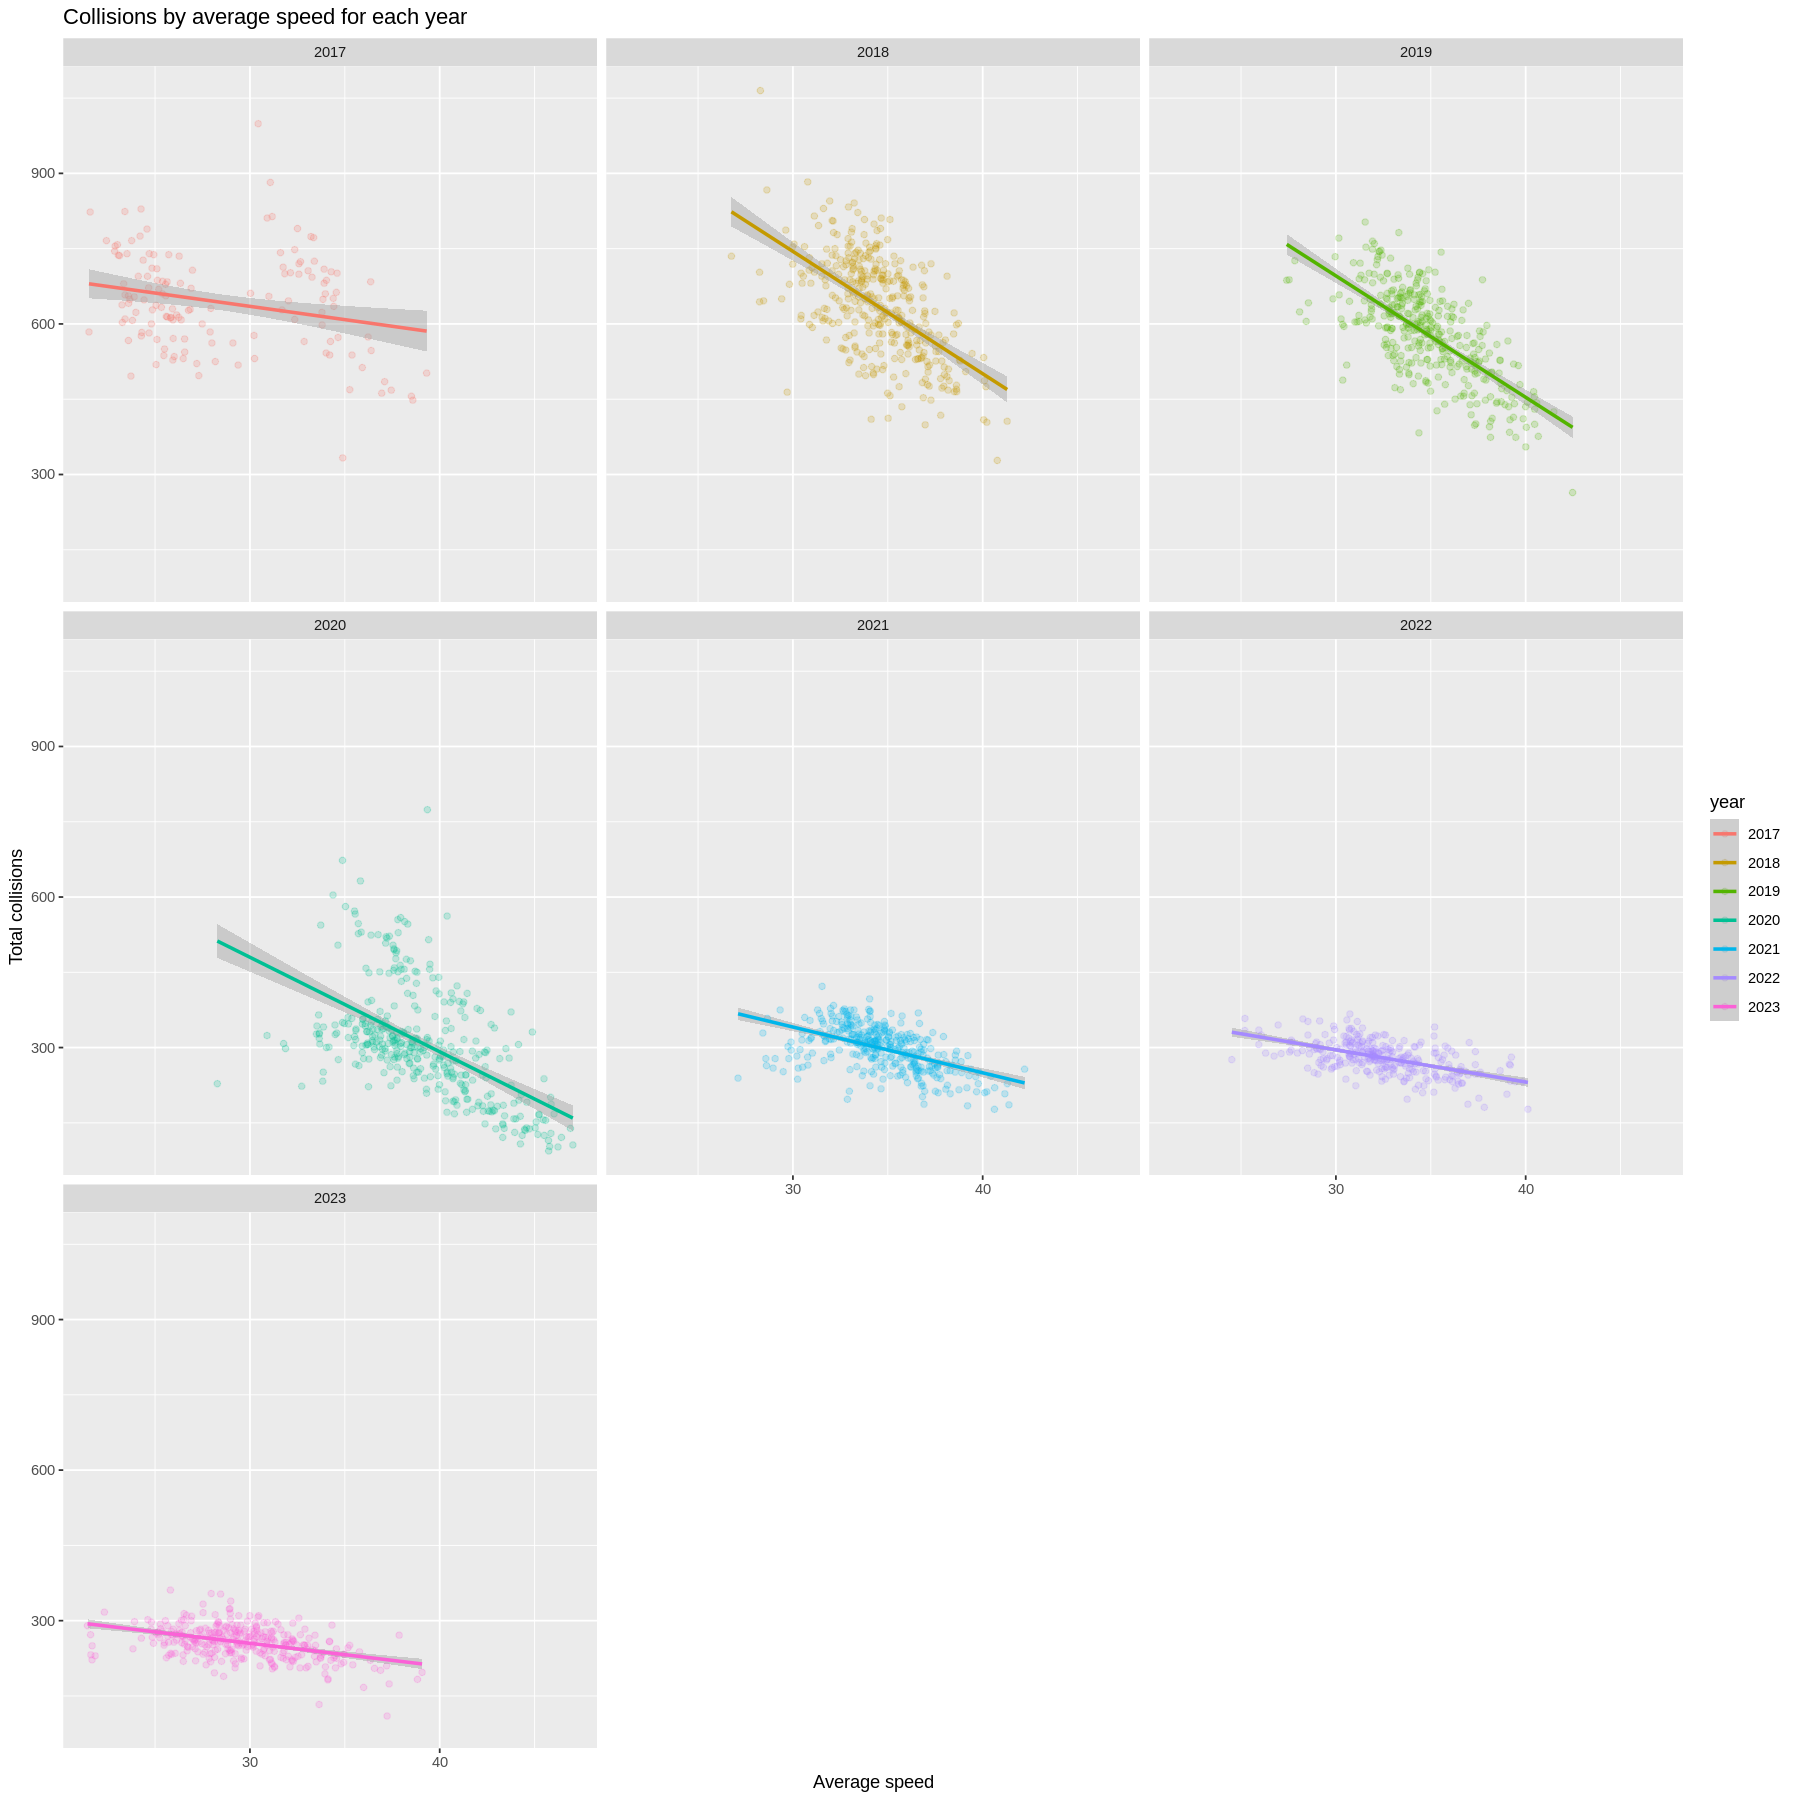

In [17]:
# read in data
cwt3 <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/combined_collisions_weather_traffic_v3.csv",
                  show_col_types = FALSE)

# plot average speed versus total collisions each year
cwt3 %>%
  mutate(year = as.factor(year)) %>%
  ggplot(aes(x = avg_speed_all, y = total_collisions, colour = year)) +
  geom_point(alpha = 0.2) +
  geom_smooth(method = "lm", formula = y ~ x) +
  facet_wrap(~year) +
  labs(x = "Average speed", y = "Total collisions",
    title = "Collisions by average speed for each year")

The charts clearly show that there is a negative correlation between the variables, meaning as the average speed decreases, the number of collisions increases. It is easy to acknowledge that a decrease in average speed could be an indicator of an increase in traffic, but collisions may close parts of the city meaning the same amount of traffic is now forced into fewer routes which would also decrease the speed.

In [18]:
cwt3_2017 <- filter(cwt3, year == 2017)
cwt3_2018 <- filter(cwt3, year == 2018)
cwt3_2019 <- filter(cwt3, year == 2019)
cwt3_2020 <- filter(cwt3, year == 2020)
cwt3_2021 <- filter(cwt3, year == 2021)
cwt3_2022 <- filter(cwt3, year == 2022)
cwt3_2023 <- filter(cwt3, year == 2023)

cor(cwt3_2017$avg_speed_all, cwt3_2017$total_collisions)
cor(cwt3_2018$avg_speed_all, cwt3_2018$total_collisions)
cor(cwt3_2019$avg_speed_all, cwt3_2019$total_collisions)
cor(cwt3_2020$avg_speed_all, cwt3_2020$total_collisions)
cor(cwt3_2021$avg_speed_all, cwt3_2021$total_collisions)
cor(cwt3_2022$avg_speed_all, cwt3_2022$total_collisions)
cor(cwt3_2023$avg_speed_all, cwt3_2023$total_collisions)

[1] -0.2496607

[1] -0.5715564

[1] -0.689601

[1] -0.5490316

[1] -0.5219317

[1] -0.5579928

[1] -0.4350711

Also striking is the variation between years. 2017 has the weakest correlation (-0.25), although it was noted before that there were some doubts about the average speed data in this year. 2017 data will, therefore, be excluded from building the model. 2019 has the strongest correlation (-0.69), which is the year before the pandemic. But post pandemic the level of collisions has not been matched with 2022 and 2023 having correlations of -0.56 and -0.44 respectively. Nevertheless, average speed will be trialled in building the model.

Next the number of collisions was tested against the number of vehicles involved.

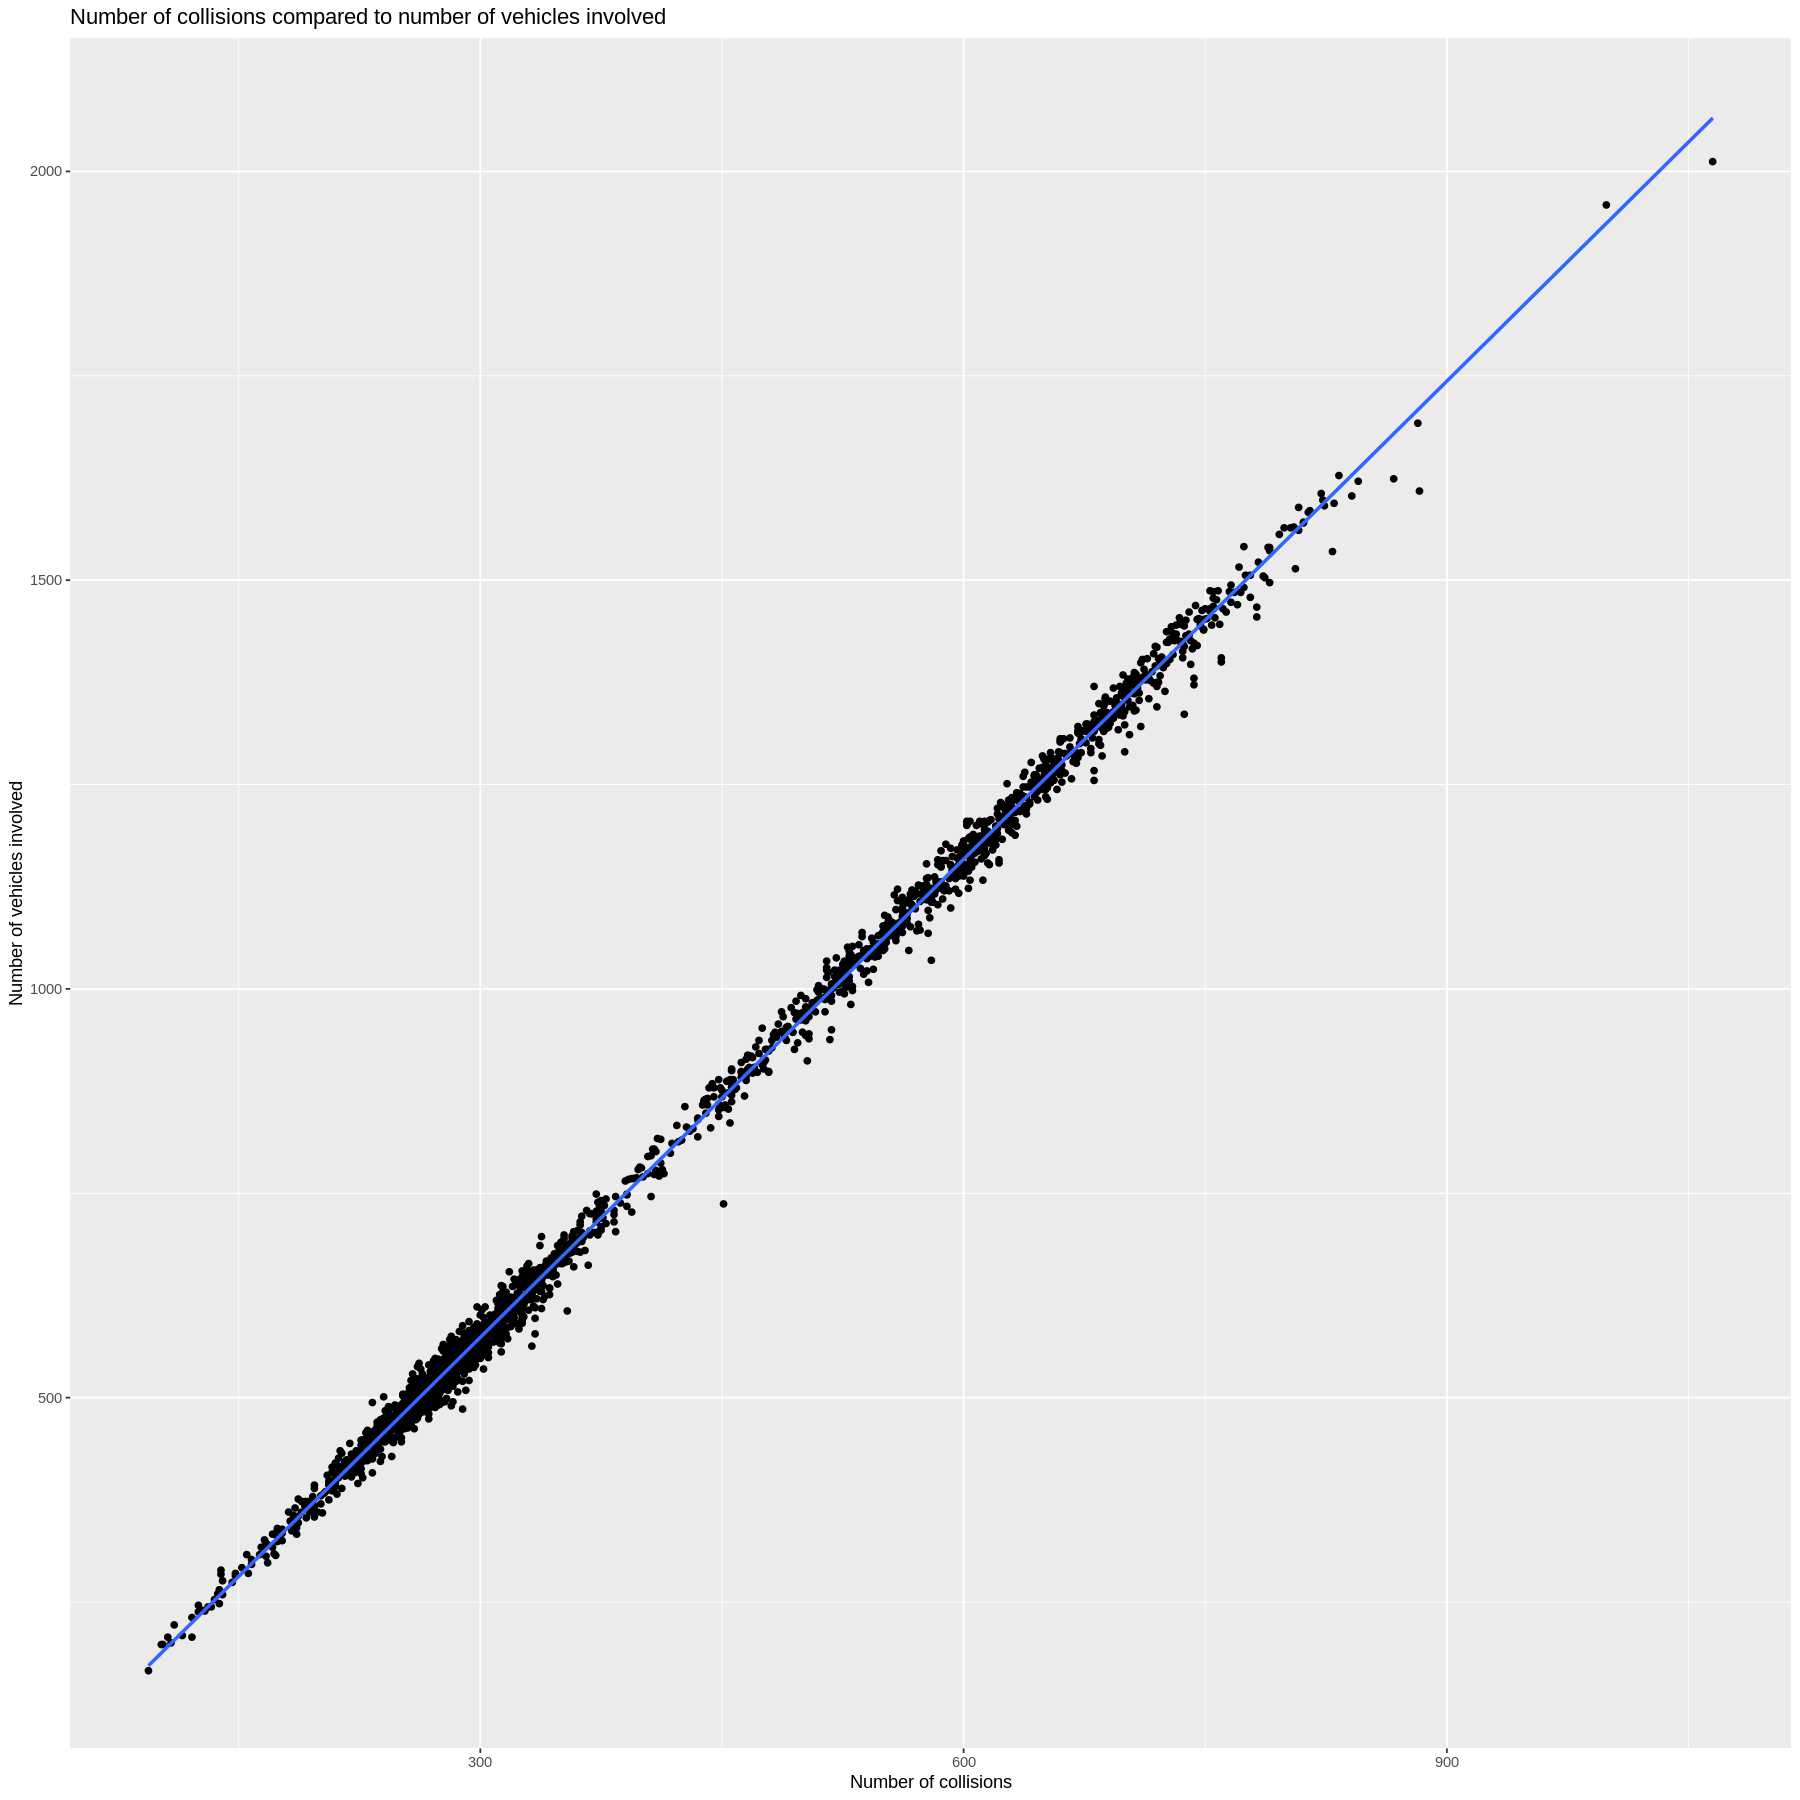

In [19]:
# plot data
cwt3 %>%
  ggplot(aes(x = total_collisions, y = total_vehicles_involved)) +
    geom_point() +
    geom_smooth(method = "lm", formula = y ~ x) +
    labs(title = "Number of collisions compared to number of vehicles involved",
          x = "Number of collisions",
          y = "Number of vehicles involved")

There is a clear correlation between the number of collisions and the number of vehicles involved.

In [20]:
cor(cwt3$total_collisions, cwt3$total_vehicles_involved)

[1] 0.9988154

In fact they are almost perfectly correlated with each other (0.9988). This variable will be excluded from the final dataset for modelling. This figure will not be known in advance, but if it is possible to calculate the number of vehicles involved each day from data other than traffic data, then it must also be possible to calculate the number of collisions, because of their close correlation.

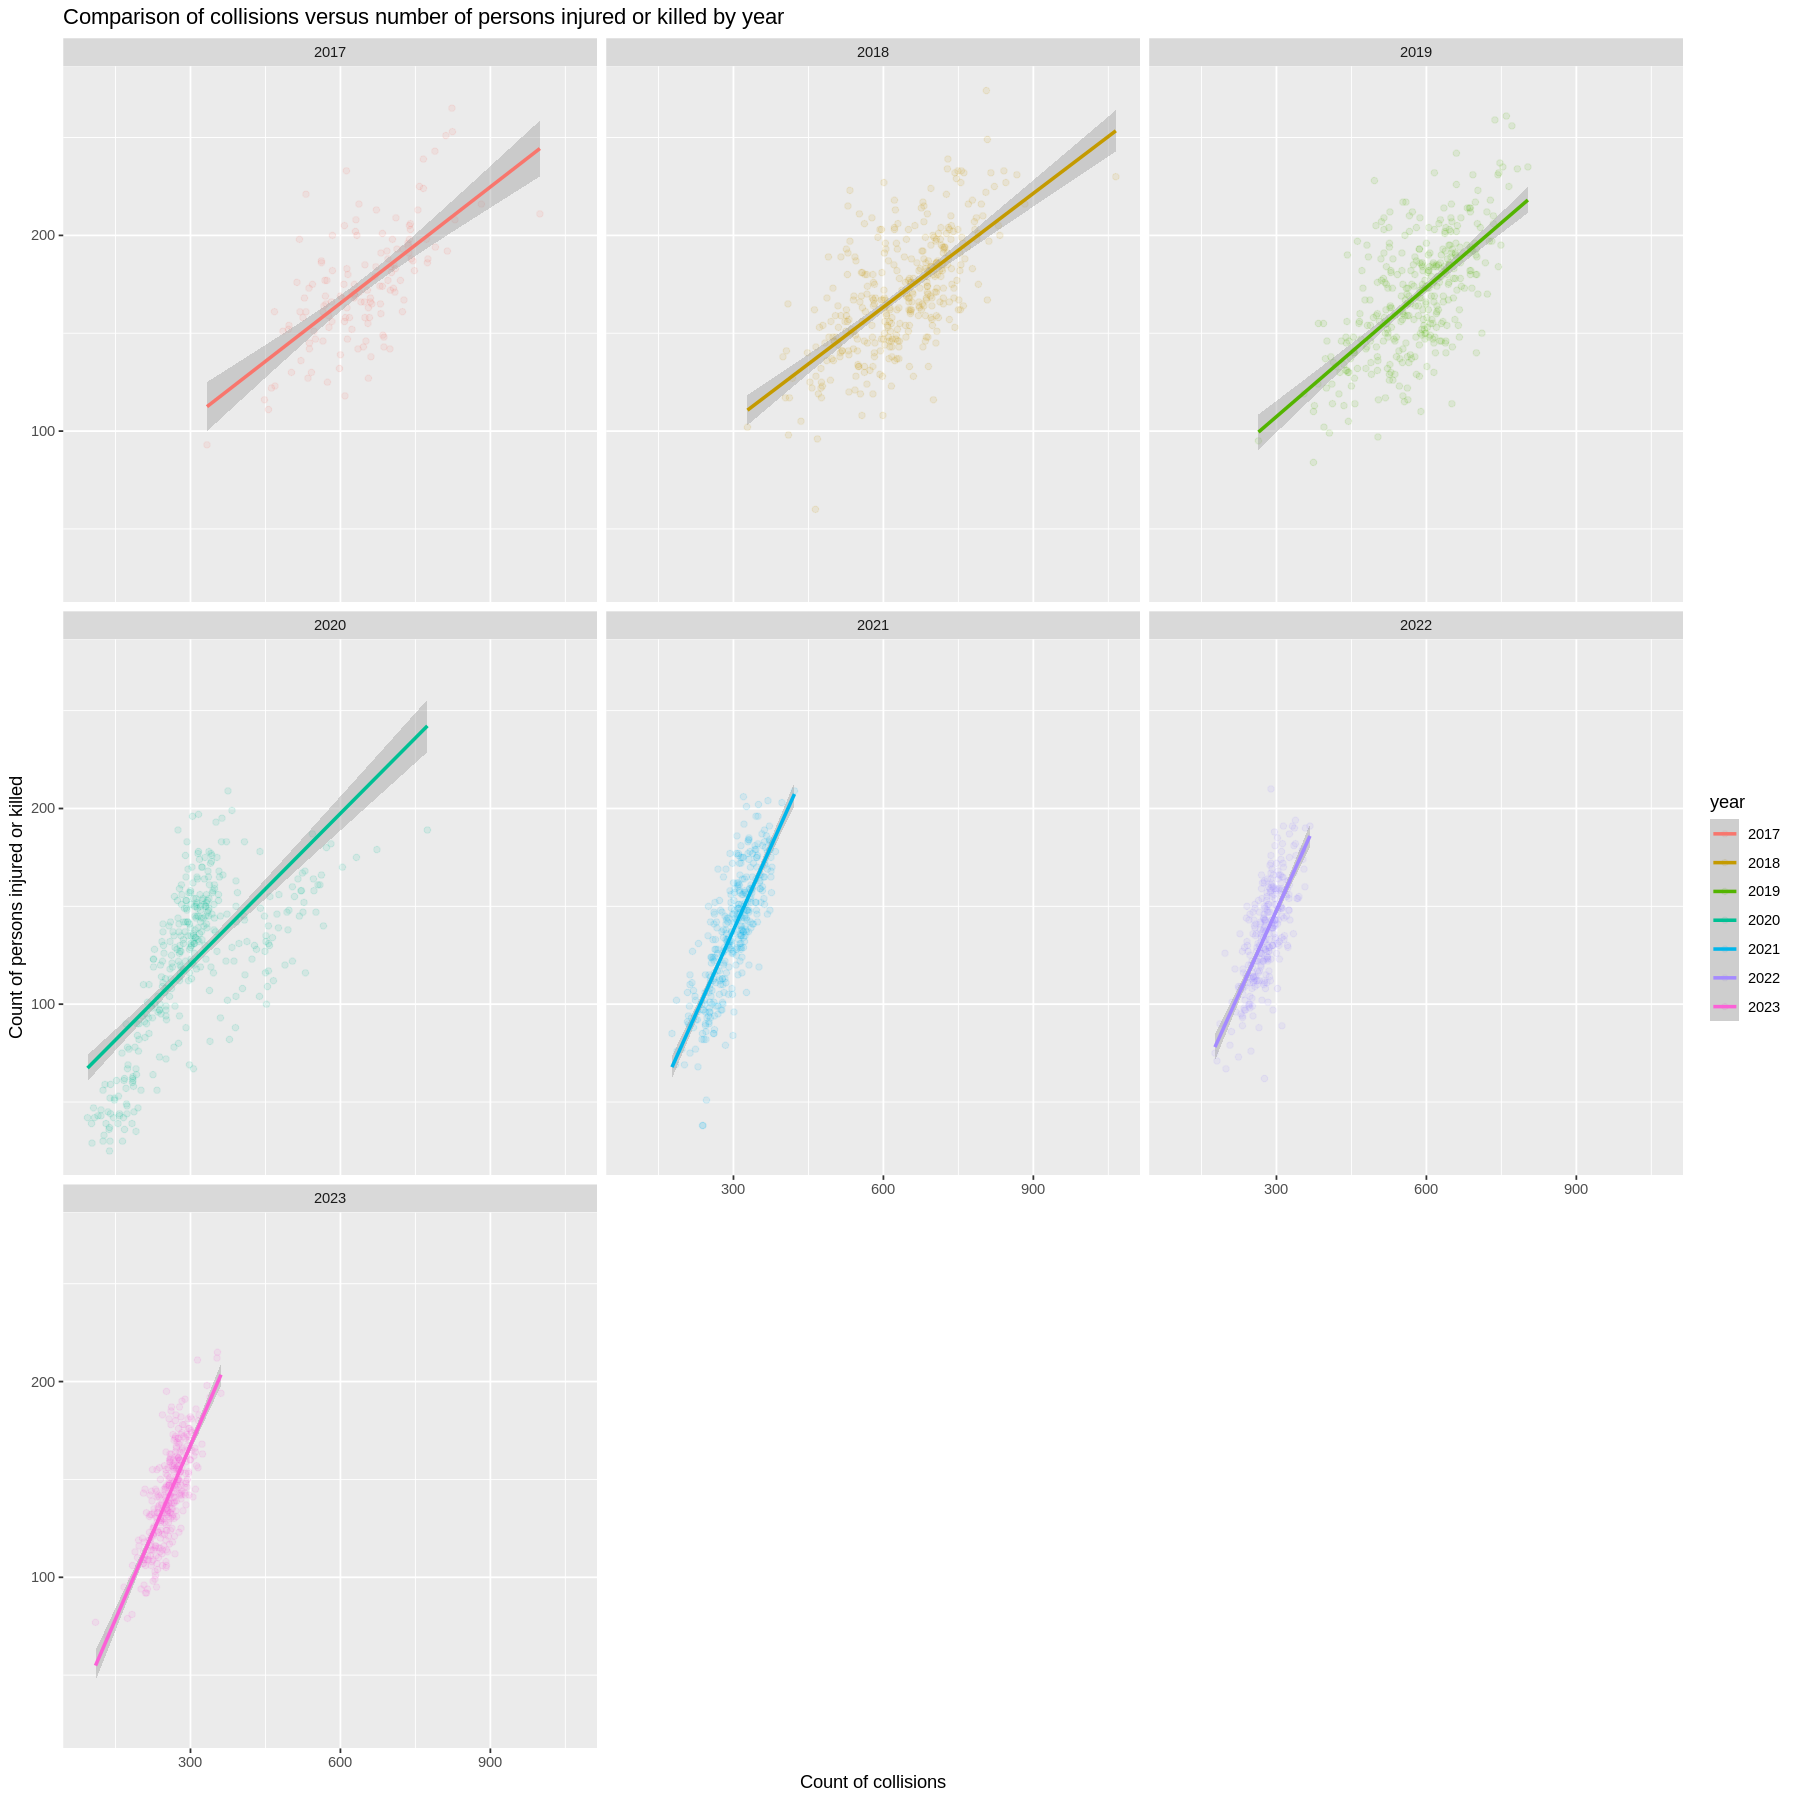

In [21]:
cwt3 %>%
  mutate(total_persons_involved = total_persons_injured + total_persons_killed,
          year = as.factor(year)) %>%
  ggplot(aes(x = total_collisions, total_persons_involved, colour = year)) +
  geom_point(alpha = 0.1) +
  geom_smooth(method = "lm", formula = y ~ x) +
  facet_wrap(~year) +
  labs(x = "Count of collisions", y = "Count of persons injured or killed",
    title = "Comparison of collisions versus number of persons injured or killed by year")

In [22]:
cor(cwt3$total_collisions, (cwt3$total_persons_injured + cwt3$total_persons_killed))

[1] 0.6670519

The total number of people injured or killed is also correlated with the number of collisions, but not as strongly. The correlation is not surprising, but a weaker correlation suggests a higher frequency of collisions where no individuals were injured and a stronger correlation suggests a lower frequency. Being able to predict that trend would also be beneficial for planning purposes. Not calculated previously is the number of collisions each day that resulted in a person being injured or killed. This will be added.

Finally, it was important to establish whether any of the weather variables were dependent on each other.

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 row that contained a missing value”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 29 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 919 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 32 rows containing missing values”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 row that contained a missing value”
Warning message in ggally_statistic(data = data, mapping 

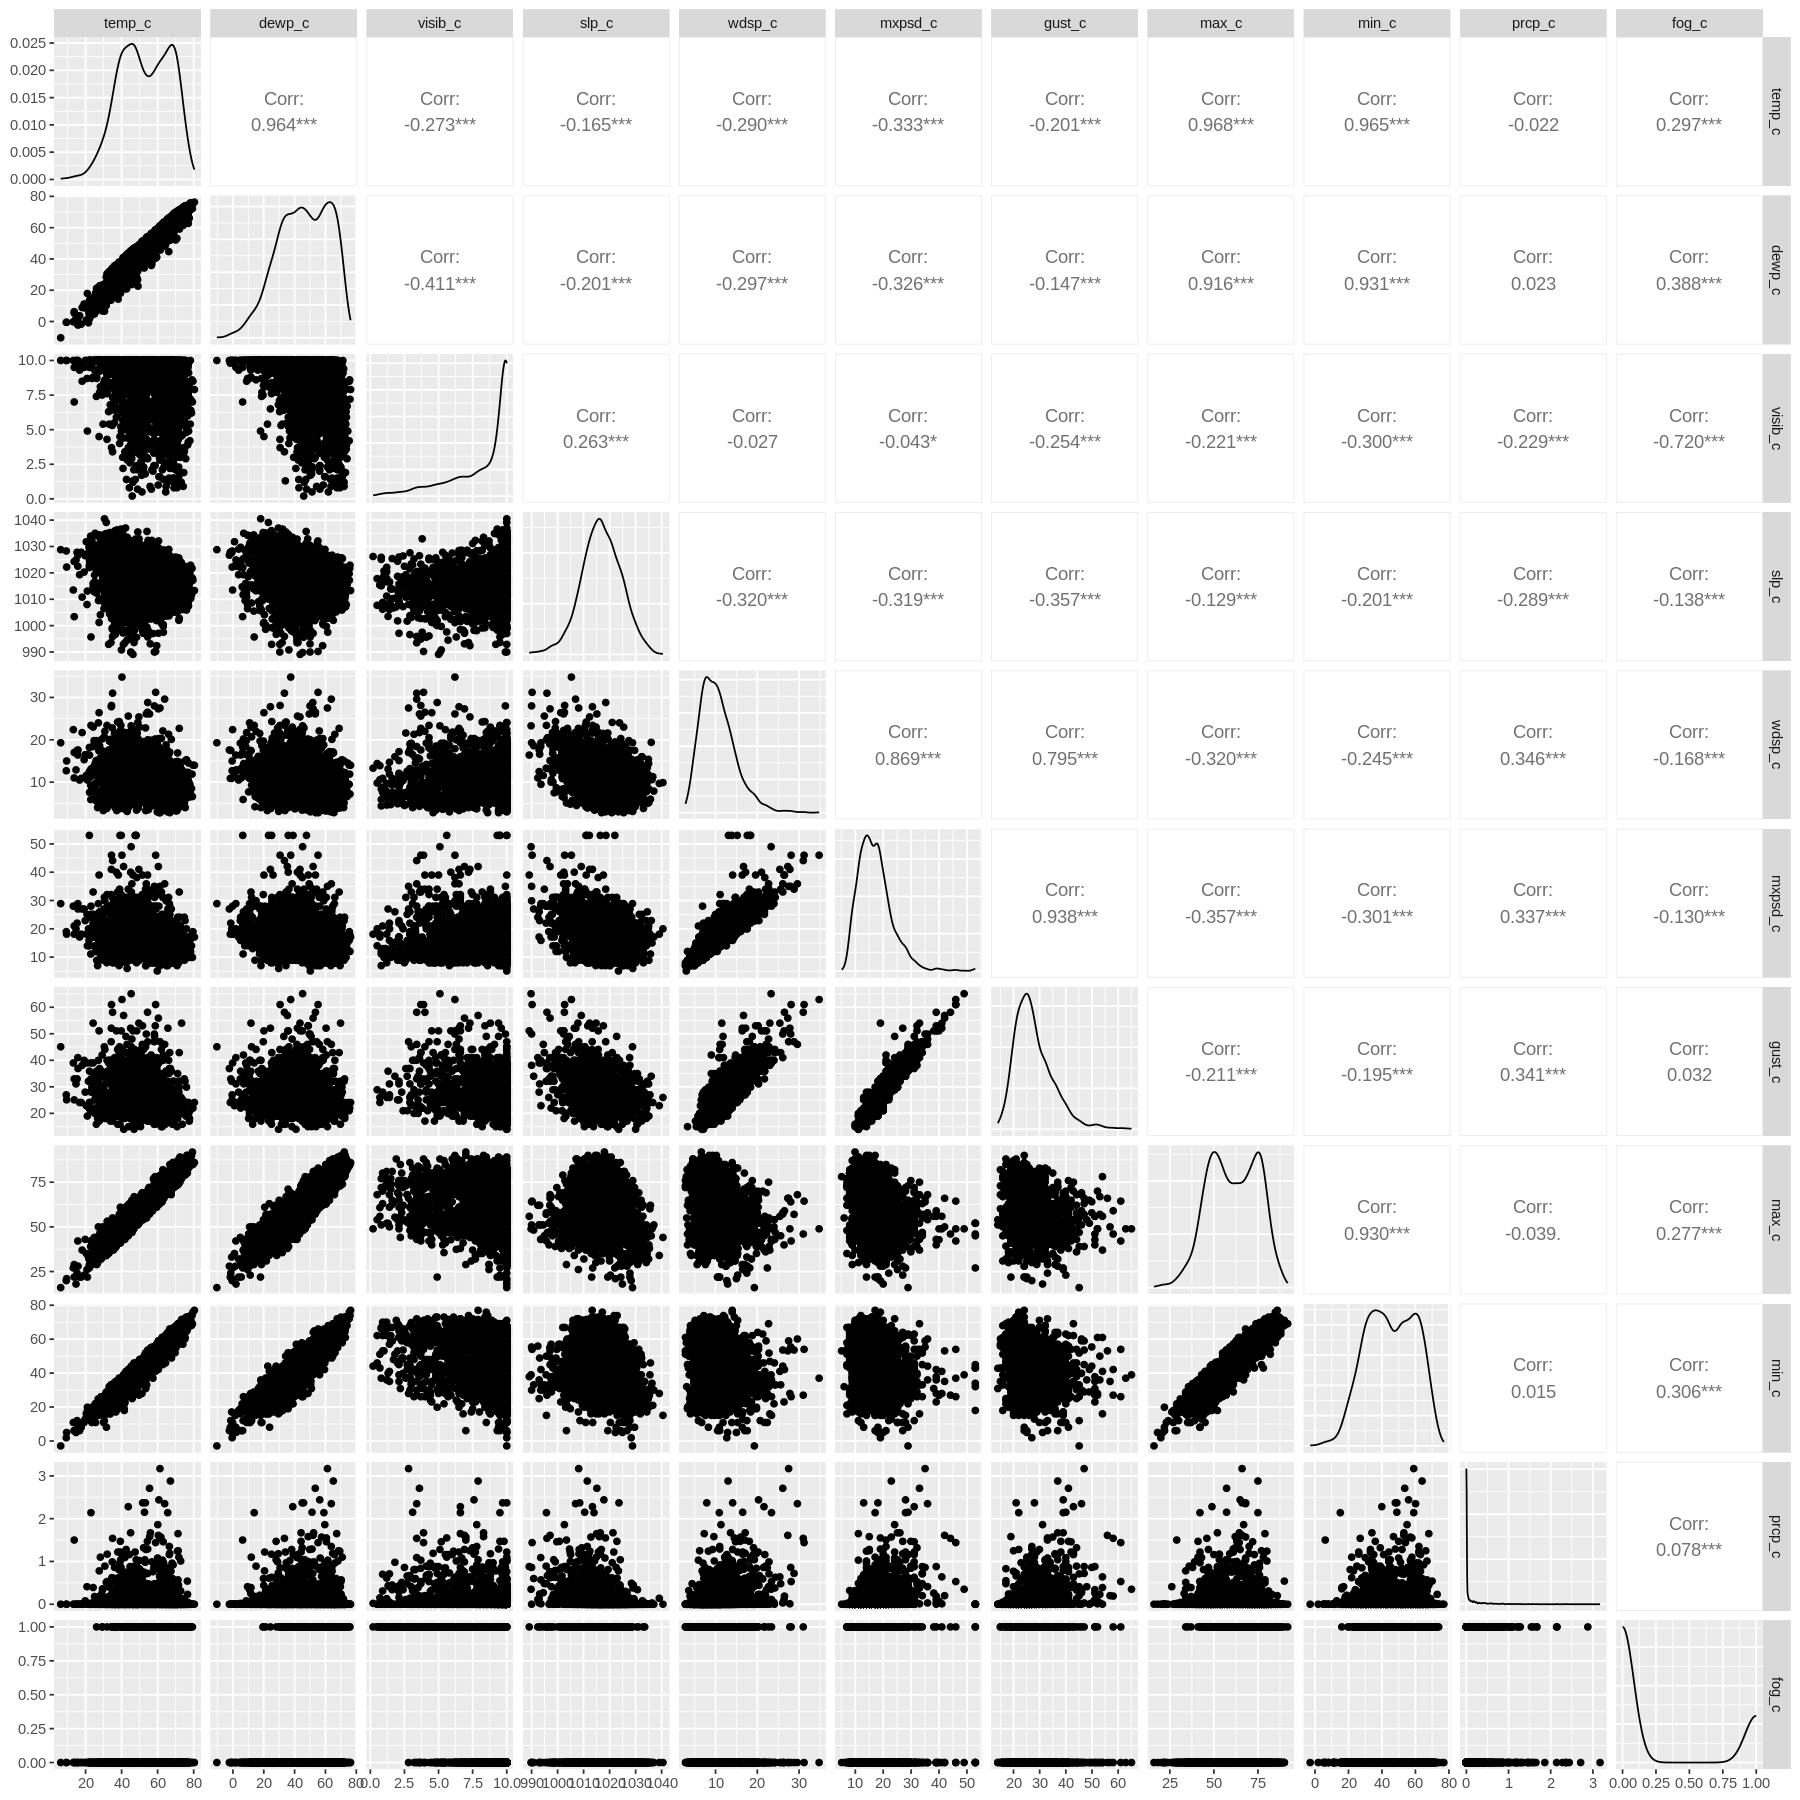

In [23]:
# create correlation matrix
cwt3 %>%
  select(temp_c, dewp_c, visib_c, slp_c, wdsp_c, mxpsd_c, gust_c, max_c, min_c, prcp_c,
          fog_c) %>%
  ggpairs()


Temperature is strongly correlated with dew point (0.964) and the maximum (0.968) and minimum (0.965) temperatures of the day. Whilst windspeed is correlated with the maximum sustained wind (0.869) and maximum wind gust (0.795). Of these, only mean temperature and windspeed were kept and the rest removed.

In [24]:
# table to check snow depth
cwt3 %>%
  group_by(sndp_c) %>%
  summarise(count = n())

sndp_c count
1 NA     2215

None of the selected days reported any snow depth so this will also be excluded from the model. Therefore, only temperature, windspeed, precipitation, visibility, fog and sea level pressure will be considered for the model.



```
CREATE VIEW `uhi-project-398119.assignment_part1.collisions_summary_v2` AS
SELECT EXTRACT(YEAR FROM timestamp) AS year,
  EXTRACT(MONTH FROM timestamp) AS month,
  EXTRACT(DAY FROM timestamp) AS day,
  EXTRACT(DAYOFWEEK FROM timestamp) AS day_of_week,
  EXTRACT(DATE FROM timestamp) as date,
  SUM(number_of_cyclist_injured) AS total_cyclist_injured,
  SUM(number_of_cyclist_killed) AS total_cyclist_killed,
  COUNTIF(number_of_cyclist_injured > 0 OR number_of_cyclist_killed > 0) AS collisions_w_cyclists_inj_kill,
  SUM(number_of_motorist_injured) AS total_motorist_injured,
  SUM(number_of_motorist_killed) AS total_motorist_killed,
  COUNTIF(number_of_motorist_injured > 0 OR number_of_motorist_killed > 0) AS collisions_w_motorists_inj_kill,
  SUM(number_of_pedestrians_injured) AS total_pedestrians_injured,
  SUM(number_of_pedestrians_killed) AS total_pedestrians_killed,
  COUNTIF(number_of_pedestrians_injured > 0 OR number_of_pedestrians_killed > 0) AS collisions_w_pedestrians_inj_kill,
  SUM(number_of_persons_injured) AS total_persons_injured,
  SUM(number_of_persons_killed) AS total_persons_killed,
  COUNTIF(number_of_persons_injured > 0 OR number_of_persons_killed > 0) AS collisions_w_persons_inj_kill,
  COUNTIF(number_of_persons_killed > 0) AS collisions_w_fatalities,
  SUM(number_vehicles_involved) AS total_vehicles_involved,
  COUNT(unique_key) AS total_collisions,
  COUNTIF(contributing_factors LIKE '%Aggressive Driving/Road Rage%') AS aggressive_driving_road_rage,
  COUNTIF(contributing_factors LIKE '%Animals Action%') AS animals_action,
  COUNTIF(contributing_factors LIKE '%Backing Unsafely%') AS backing_unsafely,
  COUNTIF(contributing_factors LIKE '%Driver Inattention/Distraction%') AS driver_inattention_distraction,
  COUNTIF(contributing_factors LIKE '%Driver Inexperience%') AS driver_inexperience,
  COUNTIF(contributing_factors LIKE '%Driver Unwell / Medical%') AS driver_unwell_medical,
  COUNTIF(contributing_factors LIKE '%Environmental Defect / Failure%') AS environmental_defect_failure,
  COUNTIF(contributing_factors LIKE '%Failure to Keep Right%') AS failure_to_keep_right,
  COUNTIF(contributing_factors LIKE '%Failure to Yield Right-of-Way%') AS failure_to_yield_right_of_way,
  COUNTIF(contributing_factors LIKE '%Following Too Closely%') AS following_too_closely,
  COUNTIF(contributing_factors LIKE '%Oversized Vehicle%') AS oversized_vehicle,
  COUNTIF(contributing_factors LIKE '%Passing or Lane Usage Improper%') AS passing_or_lane_usage_improper,
  COUNTIF(contributing_factors LIKE '%Pedestrian/Bicyclist/Other Pedestrian Error/Confusion%') AS pedestrian_bicyclist_other_pedestrian_error_confusion,
  COUNTIF(contributing_factors LIKE '%Physical Disability%') AS physical_disability,
  COUNTIF(contributing_factors LIKE '%Reaction to Uninvolved Vehicle%') AS reaction_to_uninvolved_vehicle,
  COUNTIF(contributing_factors LIKE '%Traffic Control Disregarded%') AS traffic_control_disregarded,
  COUNTIF(contributing_factors LIKE '%Turning Improperly%') AS turning_improperly,
  COUNTIF(contributing_factors LIKE '%Unsafe Speed%') AS unsafe_speed,
  COUNTIF(contributing_factors LIKE '%Vehicle Failure%') AS vehicle_failure,
  COUNTIF(contributing_factors LIKE '%Visual Distraction / Obstruction%') AS visual_distraction_obstruction
FROM `uhi-project-398119.assignment_part1.collisions_wo_location_errors`
  GROUP BY year, month, day, day_of_week, date;
```





```
CREATE TABLE `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v5` AS
  SELECT
    collisions.year, collisions.month, collisions.day, collisions.day_of_week,
    collisions.date, total_cyclist_injured, total_cyclist_killed, collisions_w_cyclists_inj_kill,
    total_motorist_injured, total_motorist_killed, collisions_w_motorists_inj_kill,
    total_pedestrians_injured, total_pedestrians_killed, collisions_w_pedestrians_inj_kill,
    total_persons_injured, total_persons_killed, collisions_w_persons_inj_kill,
    collisions_w_fatalities, total_vehicles_involved,
    total_collisions, aggressive_driving_road_rage, animals_action, backing_unsafely,
    driver_inattention_distraction, driver_inexperience, driver_unwell_medical,
    environmental_defect_failure, failure_to_keep_right, failure_to_yield_right_of_way,
    following_too_closely, oversized_vehicle, passing_or_lane_usage_improper,
    pedestrian_bicyclist_other_pedestrian_error_confusion, physical_disability,
    reaction_to_uninvolved_vehicle, traffic_control_disregarded, turning_improperly,
    unsafe_speed, vehicle_failure, visual_distraction_obstruction,
    temp_c, slp_c, visib_c, wdsp_c, prcp_c, fog_c, avg_speed_all
  FROM `uhi-project-398119.assignment_part1.collisions_summary_v2` AS collisions
  INNER JOIN `uhi-project-398119.assignment_part1.weather_2012_to_2023_wo_missing` AS weather ON collisions.date = weather.date
  INNER JOIN `uhi-project-398119.assignment_part1.traffic_speeds_comparison` AS traffic ON collisions.date = traffic.date
  WHERE collisions.year > 2014
  ORDER BY date;

SELECT * FROM `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v5`;
```



In [25]:
# read in data
cwt5 <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/combined_collisions_weather_traffic_v5.csv")

Rows: 2218 Columns: 47
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (46): year, month, day, day_of_week, total_cyclist_injured, total_cycli...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


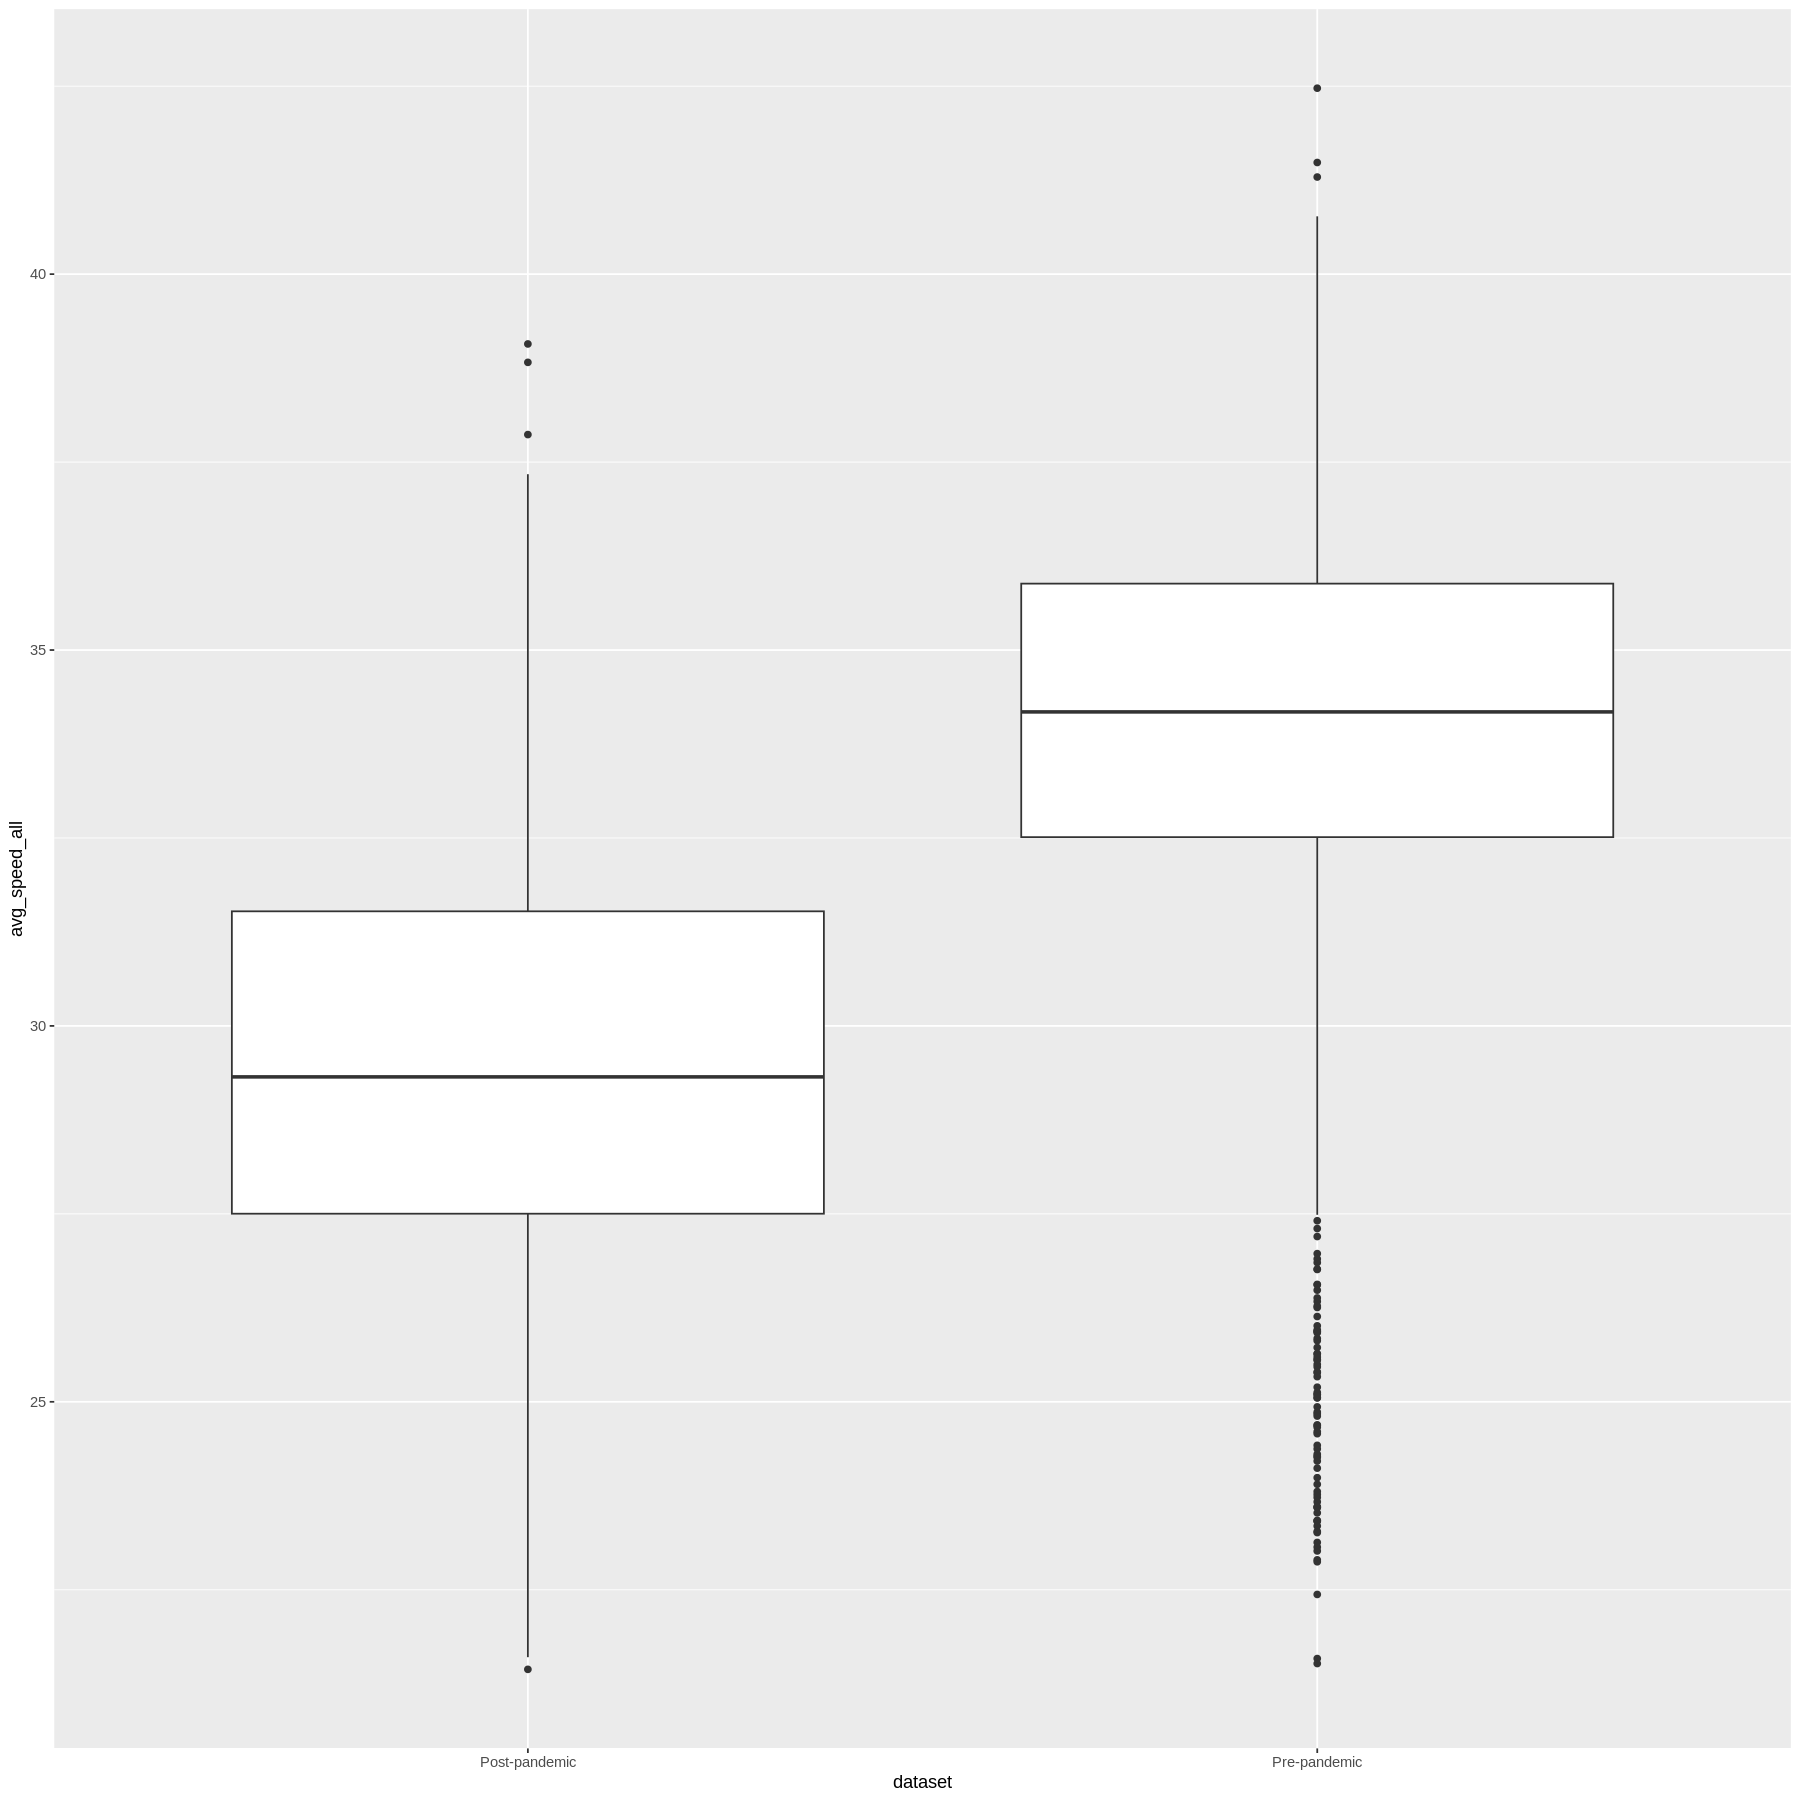

In [26]:
# create plot to compare pre and post pandemic data
cwt5 %>%
  filter(!year %in% c(2020, 2021, 2022)) %>%
  mutate(dataset = if_else(year < 2020, "Pre-pandemic", "Post-pandemic")) %>%
  ggplot(aes(x = dataset, y = avg_speed_all)) +
  geom_boxplot()

One final review shows that like collision volumes, average speeds also decreased post-pandemic (which might not be independent).

Research found new legislation was brought into place in 2022 that decreased speed limits to 25 mph and increased fines for leaving the scene of a car crash without reporting it (New York State Governor’s Office 2022).

Legislation cannot directly impact the weather, but may have impacted driver behaviour. It was concluded that building a model to predict pre-pandemic data, although interesting, would not be beneficial for the emergency services. So any models built should only include post-pandemic data. To mitigate the impact, only data for the year 2023 was selected.



```
CREATE TABLE `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v6` AS
  SELECT *
  FROM `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v5`
  WHERE year = 2023
  ORDER BY date;

SELECT * FROM `uhi-project-398119.assignment_part1.combined_collisions_weather_traffic_v6`;
```



In [27]:
# read in data
cwt6 <- read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/combined_collisions_weather_traffic_v6.csv")

Rows: 335 Columns: 47
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (46): year, month, day, day_of_week, total_cyclist_injured, total_cycli...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Results

Noted during data preparation, the number of collisions fluctuates throughout the year, which could be either because of recreational reasons (e.g. school holidays, weekends) or because of changes in the weather.

Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


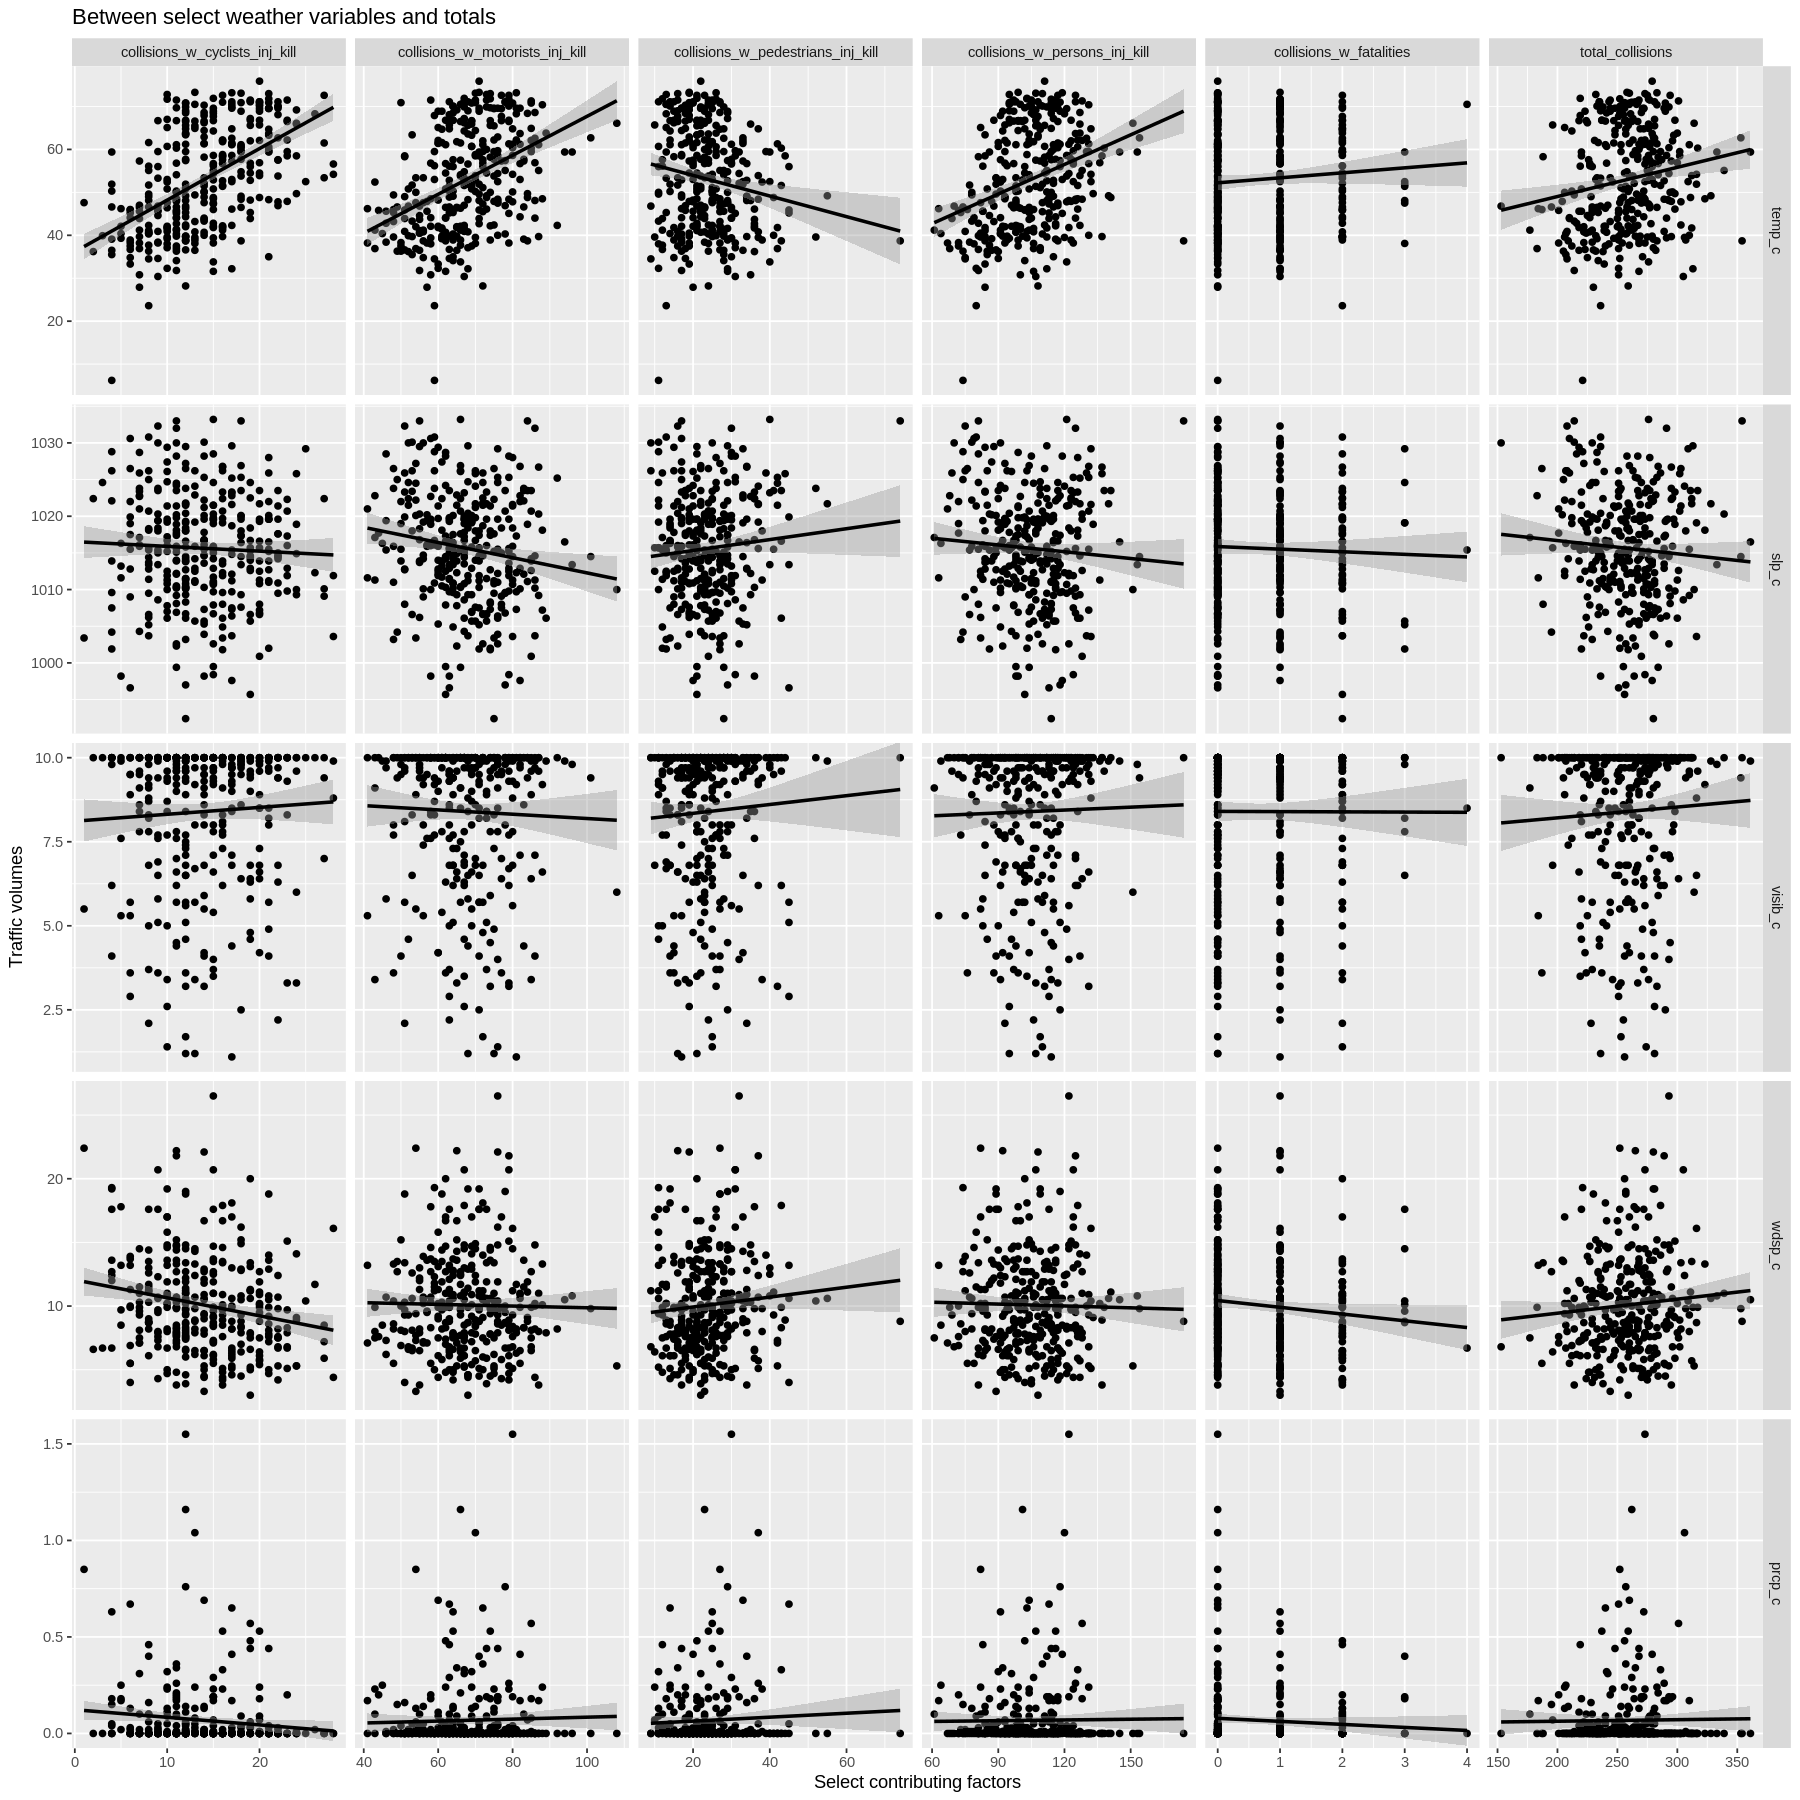

In [28]:
# create list of weather variables
weather_variables <- c("temp_c", "slp_c", "visib_c", "wdsp_c", "prcp_c")

# create list of totals
totals <- c("collisions_w_cyclists_inj_kill", "collisions_w_motorists_inj_kill",
            "collisions_w_pedestrians_inj_kill", "collisions_w_persons_inj_kill",
            "collisions_w_fatalities", "total_collisions")

# plot correlations
ggduo(
  cwt6, totals, weather_variables,
  types = list(continuous = "smooth_lm"),
  title = "Between select weather variables and totals",
  xlab = "Select contributing factors",
  ylab = "Traffic volumes"
)

Comparing weather variables to collision volumes suggests a positive correlation between collisions resulting in cyclists getting injured or killed and the temperature, a weaker positive correlation for collisions resulting in motorists getting injured or killed, but possibly a negative relationship for collisions resulting in pedestrians getting injured or killed. The inverse of all these relationships is suggested when these variables are correlated with windspeed.

Variation might suggest different factors affect the likelihood of varying collision outcomes, throwing doubt on whether simple linear regression can be used to explain the total number of collisions.

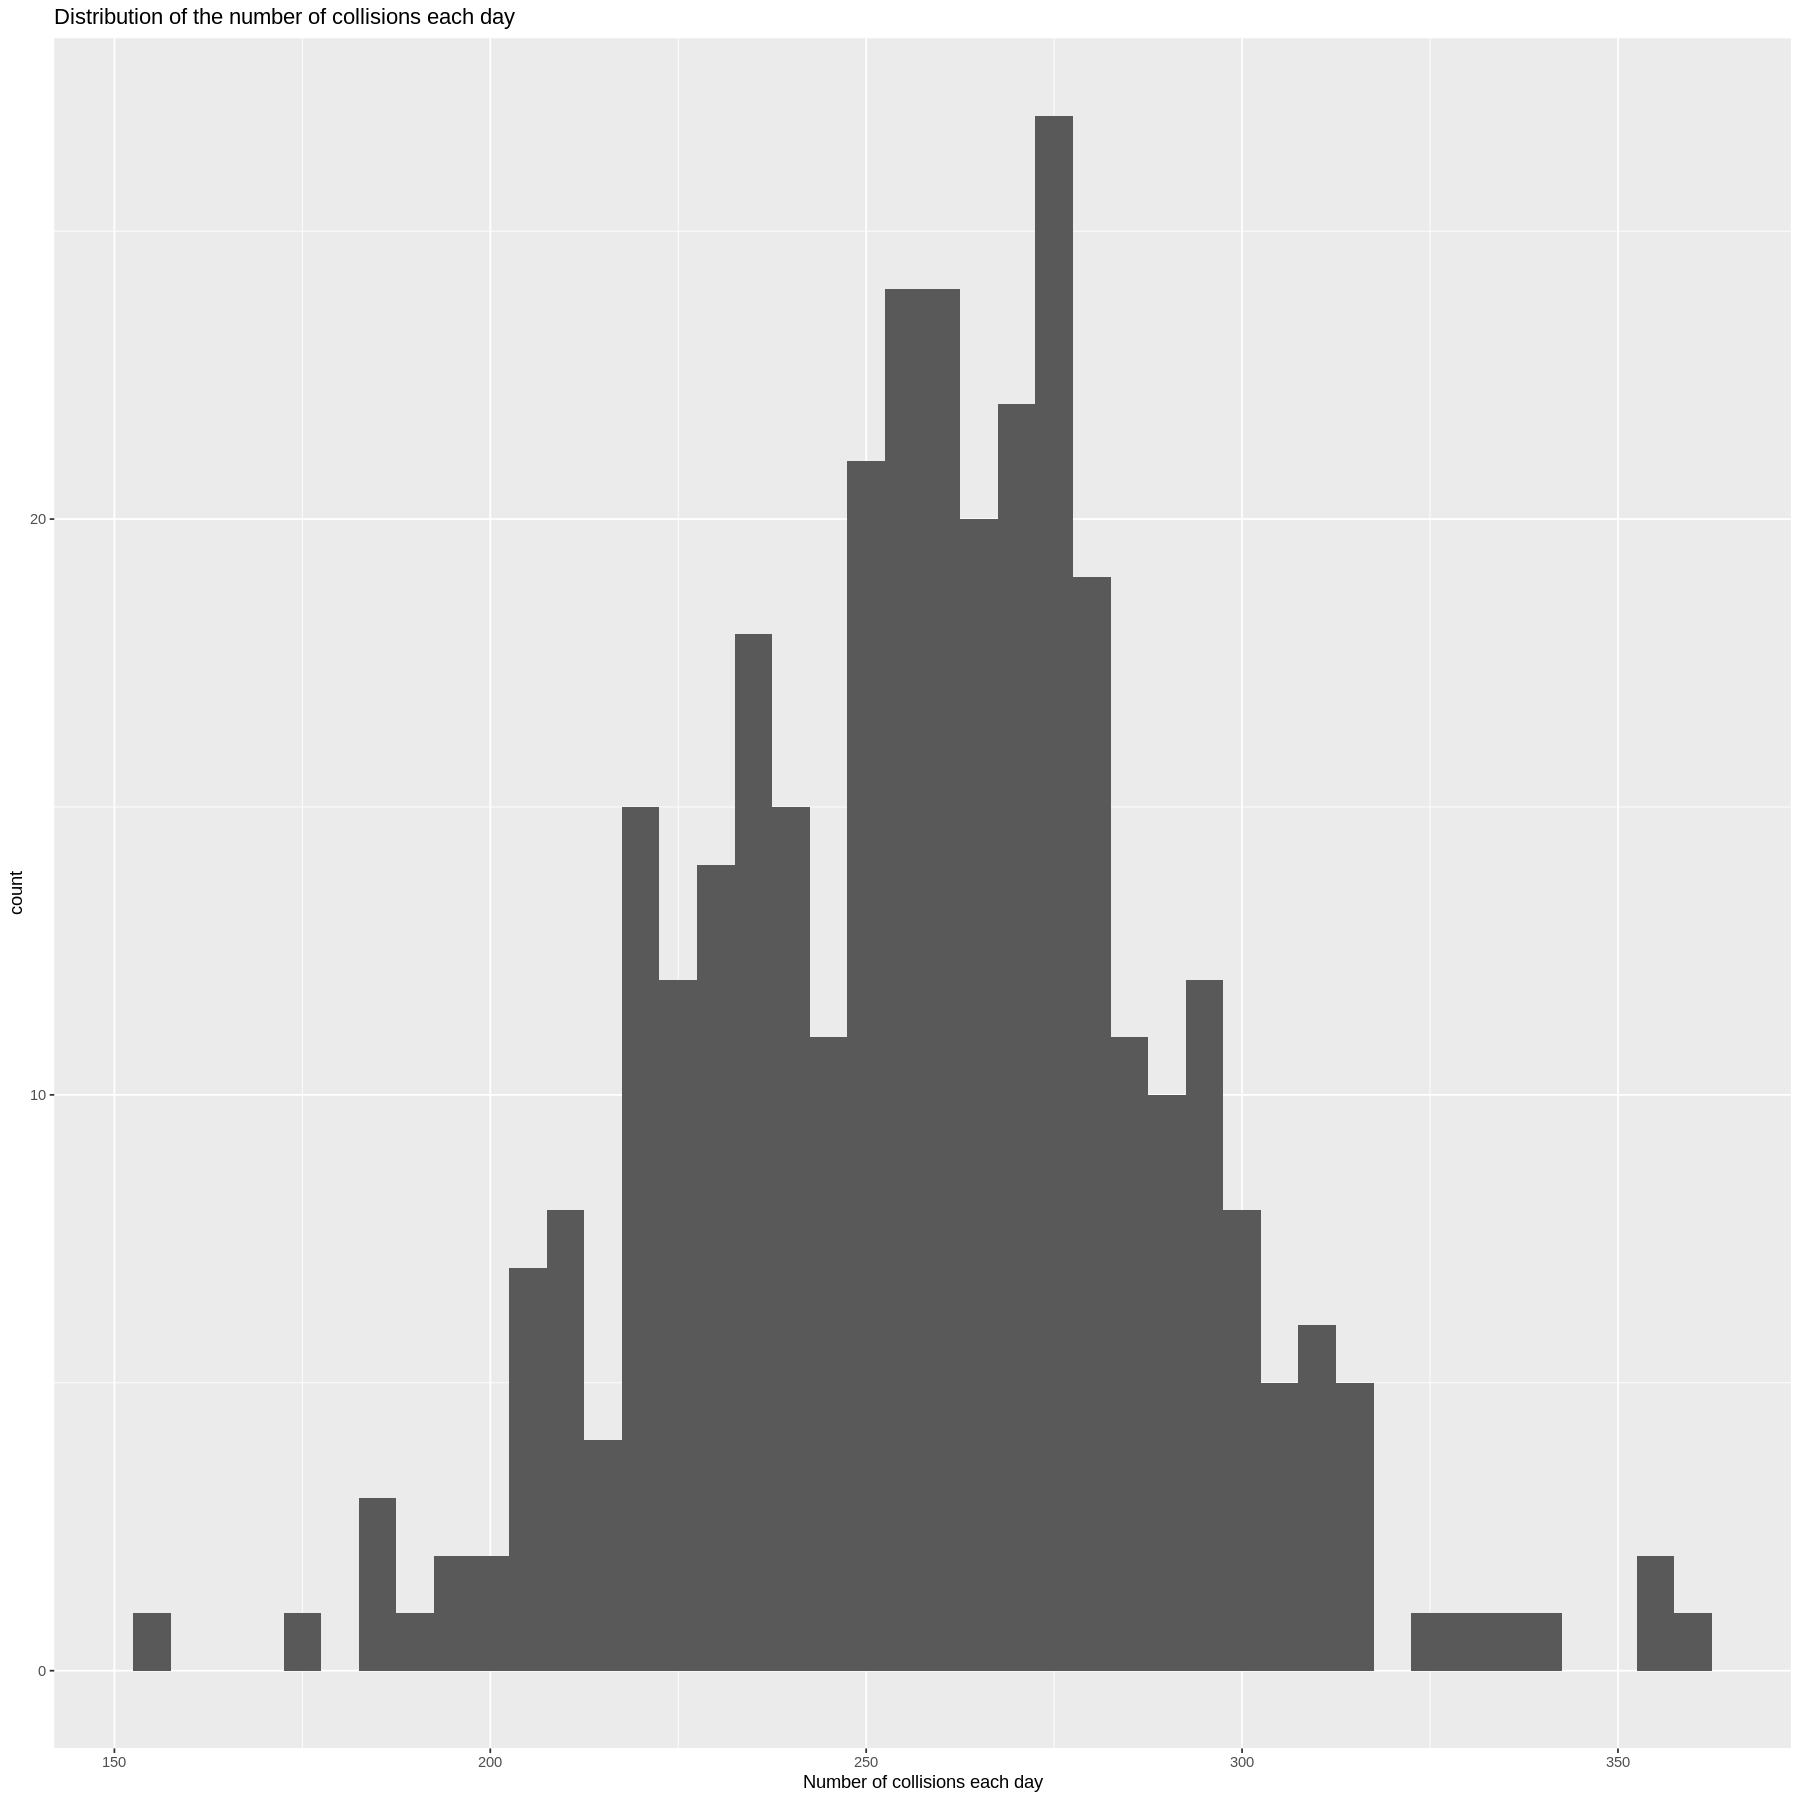

In [29]:
ggplot(cwt6, aes(x = total_collisions)) +
  geom_histogram(binwidth = 5) +
  labs(x = "Number of collisions each day", title = "Distribution of the number of collisions each day")

The histogram suggests a normal distribution of the number of collisions each day, meaning a linear model could be used with independent variables.

In [30]:
# set date information as factor
cwt6_factorised <-
  mutate(cwt6,
          month = as.factor(month),
          day = as.factor(day),
          day_of_week = as.factor(day_of_week))

# create a linear model that uses all variables
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all")

# remove each variable in turn and test for the best fit
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c) %>% glance() %>% mutate(model = "month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + fog_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + temp_c + slp_c + visib_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + day_of_week + temp_c + slp_c + visib_c + prcp_c + fog_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + temp_c + slp_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + day_of_week + temp_c + slp_c + wdsp_c + prcp_c + fog_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + temp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + day_of_week + temp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + day_of_week + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + day_of_week + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ month + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "month + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all")
lm(data = cwt6_factorised, formula = total_collisions ~ day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance() %>% mutate(model = "day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all")


r.squared adj.r.squared sigma    statistic p.value      df logLik   AIC    
1 0.4027916 0.2872029     26.38885 3.484697  6.622694e-12 54 -1537.04 3186.08
  BIC      deviance df.residual nobs
1 3399.503 194287.6 279         334 
  model                                                                                         
1 month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.3568658 0.2351297     27.33577 2.931471  5.456663e-09 53 -1549.412 3208.825
  BIC      deviance df.residual nobs
1 3418.437 209228.5 280         334 
  model                                                                         
1 month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.4011403 0.2877848     26.37808 3.538779  4.597556e-12 53 -1537.501 3185.002
  BIC      deviance df.residual nobs
1 3394.615 194824.8 280         334 
  model                                                                                 
1 month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.4013486 0.2880324     26.37349 3.541848  4.436037e-12 53 -1537.443 3184.886
  BIC      deviance df.residual nobs
1 3394.498 194757.1 280         334 
  model                                                                                
1 month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value      df logLik   AIC     
1 0.3968623 0.2826969     26.47213 3.476206  9.535891e-12 53 -1538.69 3187.379
  BIC      deviance df.residual nobs
1 3396.992 196216.6 280         334 
  model                                                                                
1 month + day + day_of_week + temp_c + slp_c + visib_c + prcp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC    
1 0.4011247 0.2877662     26.37842 3.538549  4.609924e-12 53 -1537.505 3185.01
  BIC      deviance df.residual nobs
1 3394.623 194829.9 280         334 
  model                                                                               
1 month + day + day_of_week + temp_c + slp_c + wdsp_c + prcp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC    
1 0.4027412 0.2900909     26.29588 3.575147  2.927991e-12 53 -1541.155 3192.31
  BIC      deviance df.residual nobs
1 3402.087 194304.1 281         335 
  model                                                                                 
1 month + day + day_of_week + temp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value    df logLik    AIC     
1 0.4027849 0.2897406     26.34183 3.563072  3.4641e-12 53 -1537.042 3184.083
  BIC      deviance df.residual nobs
1 3393.696 194289.8 280         334 
  model                                                                                
1 month + day + day_of_week + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.3515086 0.2422889     27.20754 3.218365  6.685971e-10 48 -1550.798 3201.595
  BIC      deviance df.residual nobs
1 3392.152 210971.3 285         334 
  model                                                                           
1 month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value     df logLik    AIC     
1 0.3289509 0.2768306     26.58016 6.311375  4.43259e-16 24 -1556.508 3165.016
  BIC      deviance df.residual nobs
1 3264.106 218309.9 309         334 
  model                                                                                   
1 month + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.3365653 0.238194      27.28096 3.421376  3.138977e-10 43 -1554.602 3199.204
  BIC      deviance df.residual nobs
1 3370.706 215832.8 290         334 
  model                                                                                 
1 day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all

Using all available weather variables, date information and average speed, the best linear model includes all the available variables, with R^2 = 0.403 (p=6.6e-12). Although the model is statistically significant, the model only fits 40% of the data accurately, without considering over-fitting errors. It was considered whether this could be improved upon to support the emergency services with their planning.

In [31]:
# create model using all contributing factors
lm(data = cwt6, formula = total_collisions ~ aggressive_driving_road_rage +
                            backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance()

r.squared adj.r.squared sigma   statistic p.value       df logLik    AIC     
1 0.8957582 0.8891186     10.3924 134.9114  5.376858e-141 20 -1248.761 2541.522
  BIC      deviance df.residual nobs
1 2625.432 33912.59 314         335

A better fitting model can be produced using all the contributing factors, which will accurately estimate the number of collisions each day 90% of the time.

In [32]:
# remove one contributing factor in turn and compare to see if fit can be improved
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-aggressive_driving_road_rage")
lm(data = cwt6, formula = total_collisions ~ failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-backing_unsafely")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-failure_to_keep_right")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-failure_to_yield_right_of_way")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-following_too_closely")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-passing_or_lane_usage_improper")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-traffic_control_disregarded")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-turning_improperly")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-unsafe_speed")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-driver_inattention_distraction")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-driver_inexperience")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-driver_unwell_medical")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-reaction_to_uninvolved_vehicle")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-oversized_vehicle")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-vehicle_failure")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-animals_action")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            physical_disability + environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-pedestrian_bicyclist_other_pedestrian_error_confusion")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            environmental_defect_failure +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-physical_disability")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability +
                            visual_distraction_obstruction) %>% glance() %>% mutate(model = "-environmental_defect_failure")
lm(data = cwt6, formula = total_collisions ~ backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                            following_too_closely + passing_or_lane_usage_improper +
                            traffic_control_disregarded + turning_improperly +
                            unsafe_speed + driver_inattention_distraction +
                            driver_inexperience + driver_unwell_medical +
                            reaction_to_uninvolved_vehicle + oversized_vehicle +
                            vehicle_failure + animals_action +
                            pedestrian_bicyclist_other_pedestrian_error_confusion +
                            physical_disability + environmental_defect_failure) %>% glance() %>% mutate(model = "-visual_distraction_obstruction")


r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.894638  0.8882828     10.43149 140.7732  2.366207e-141 19 -1250.551
  AIC      BIC      deviance df.residual nobs model                        
1 2543.103 2623.199 34277.05 315         335  -aggressive_driving_road_rage

r.squared adj.r.squared sigma   statistic p.value       df logLik    AIC     
1 0.8912828 0.8850901     10.5795 143.9236  2.623433e-140 18 -1255.802 2551.604
  BIC      deviance df.residual nobs model            
1 2627.887 35368.57 316         335  -backing_unsafely

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8936825 0.8876265     10.46209 147.5683  7.880753e-142 18 -1252.063
  AIC      BIC      deviance df.residual nobs model                 
1 2544.127 2620.409 34587.88 316         335  -failure_to_keep_right

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8483292 0.8396897     12.49589 98.1922   1.247134e-117 18 -1311.573
  AIC      BIC      deviance df.residual nobs model                         
1 2663.146 2739.429 49342.51 316         335  -failure_to_yield_right_of_way

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8774844 0.8705057     11.23083 125.7369  3.665744e-132 18 -1275.816
  AIC      BIC      deviance df.residual nobs model                 
1 2591.633 2667.915 39857.55 316         335  -following_too_closely

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8479869 0.8393279     12.50998 97.93154  1.775087e-117 18 -1311.951
  AIC      BIC      deviance df.residual nobs model                          
1 2663.902 2740.184 49453.88 316         335  -passing_or_lane_usage_improper

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8828909 0.8762201     10.98023 132.3521  3.079431e-135 18 -1268.257
  AIC      BIC      deviance df.residual nobs model                       
1 2576.513 2652.796 38098.69 316         335  -traffic_control_disregarded

r.squared adj.r.squared sigma    statistic p.value       df logLik    AIC    
1 0.8868641 0.8804196     10.79236 137.6167  1.366162e-137 18 -1262.475 2564.95
  BIC      deviance df.residual nobs model              
1 2641.233 36806.1  316         335  -turning_improperly

r.squared adj.r.squared sigma    statistic p.value       df logLik   AIC    
1 0.8878091 0.8814185     10.74719 138.9238  3.660721e-138 18 -1261.07 2562.14
  BIC      deviance df.residual nobs model        
1 2638.423 36498.65 316         335  -unsafe_speed

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.7790612 0.7664761     15.08176 61.90336  4.118434e-92 18 -1374.582 2789.164
  BIC      deviance df.residual nobs model                          
1 2865.447 71877.21 316         335  -driver_inattention_distraction

r.squared adj.r.squared sigma    statistic p.value       df logLik   AIC     
1 0.8863121 0.8798362     10.81865 136.8633  2.932944e-137 18 -1263.29 2566.581
  BIC      deviance df.residual nobs model               
1 2642.863 36985.67 316         335  -driver_inexperience

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8842704 0.8776782     10.91537 134.139   4.794697e-136 18 -1266.272
  AIC      BIC      deviance df.residual nobs model                 
1 2572.544 2648.826 37649.91 316         335  -driver_unwell_medical

r.squared adj.r.squared sigma   statistic p.value       df logLik    AIC     
1 0.8905561 0.8843219     10.6148 142.8513  7.468601e-140 18 -1256.918 2553.836
  BIC      deviance df.residual nobs model                          
1 2630.119 35605    316         335  -reaction_to_uninvolved_vehicle

r.squared adj.r.squared sigma    statistic p.value       df logLik    AIC    
1 0.8945914 0.8885871     10.41727 148.9922  2.046126e-142 18 -1250.625 2541.25
  BIC      deviance df.residual nobs model             
1 2617.533 34292.19 316         335  -oversized_vehicle

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8910785 0.8848741     10.58944 143.6206  3.523137e-140 18 -1256.117
  AIC      BIC      deviance df.residual nobs model           
1 2552.233 2628.516 35435.04 316         335  -vehicle_failure

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8946006 0.8885968     10.41682 149.0066  2.018471e-142 18 -1250.611
  AIC      BIC      deviance df.residual nobs model          
1 2541.221 2617.504 34289.22 316         335  -animals_action

r.squared adj.r.squared sigma statistic p.value       df logLik    AIC     
1 0.8922977 0.8861628     10.53 145.4452  6.014728e-141 18 -1254.231 2548.462
  BIC      deviance df.residual nobs
1 2624.745 35038.39 316         335 
  model                                                 
1 -pedestrian_bicyclist_other_pedestrian_error_confusion

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8941671 0.8881386     10.43822 148.3243  3.845857e-142 18 -1251.298
  AIC      BIC      deviance df.residual nobs model               
1 2542.596 2618.879 34430.24 316         335  -physical_disability

r.squared adj.r.squared sigma    statistic p.value       df logLik   
1 0.8764288 0.8693899     11.27911 124.5128  1.408392e-131 18 -1277.253
  AIC      BIC      deviance df.residual nobs model                        
1 2594.507 2670.789 40200.98 316         335  -environmental_defect_failure

r.squared adj.r.squared sigma    statistic p.value       df logLik    AIC    
1 0.8826891 0.8760068     10.98969 132.0942  4.034743e-135 18 -1268.545 2577.09
  BIC      deviance df.residual nobs model                          
1 2653.373 38164.34 316         335  -visual_distraction_obstruction

This is extremely well fitted and cannot be improved by removing any of the contributing factors.

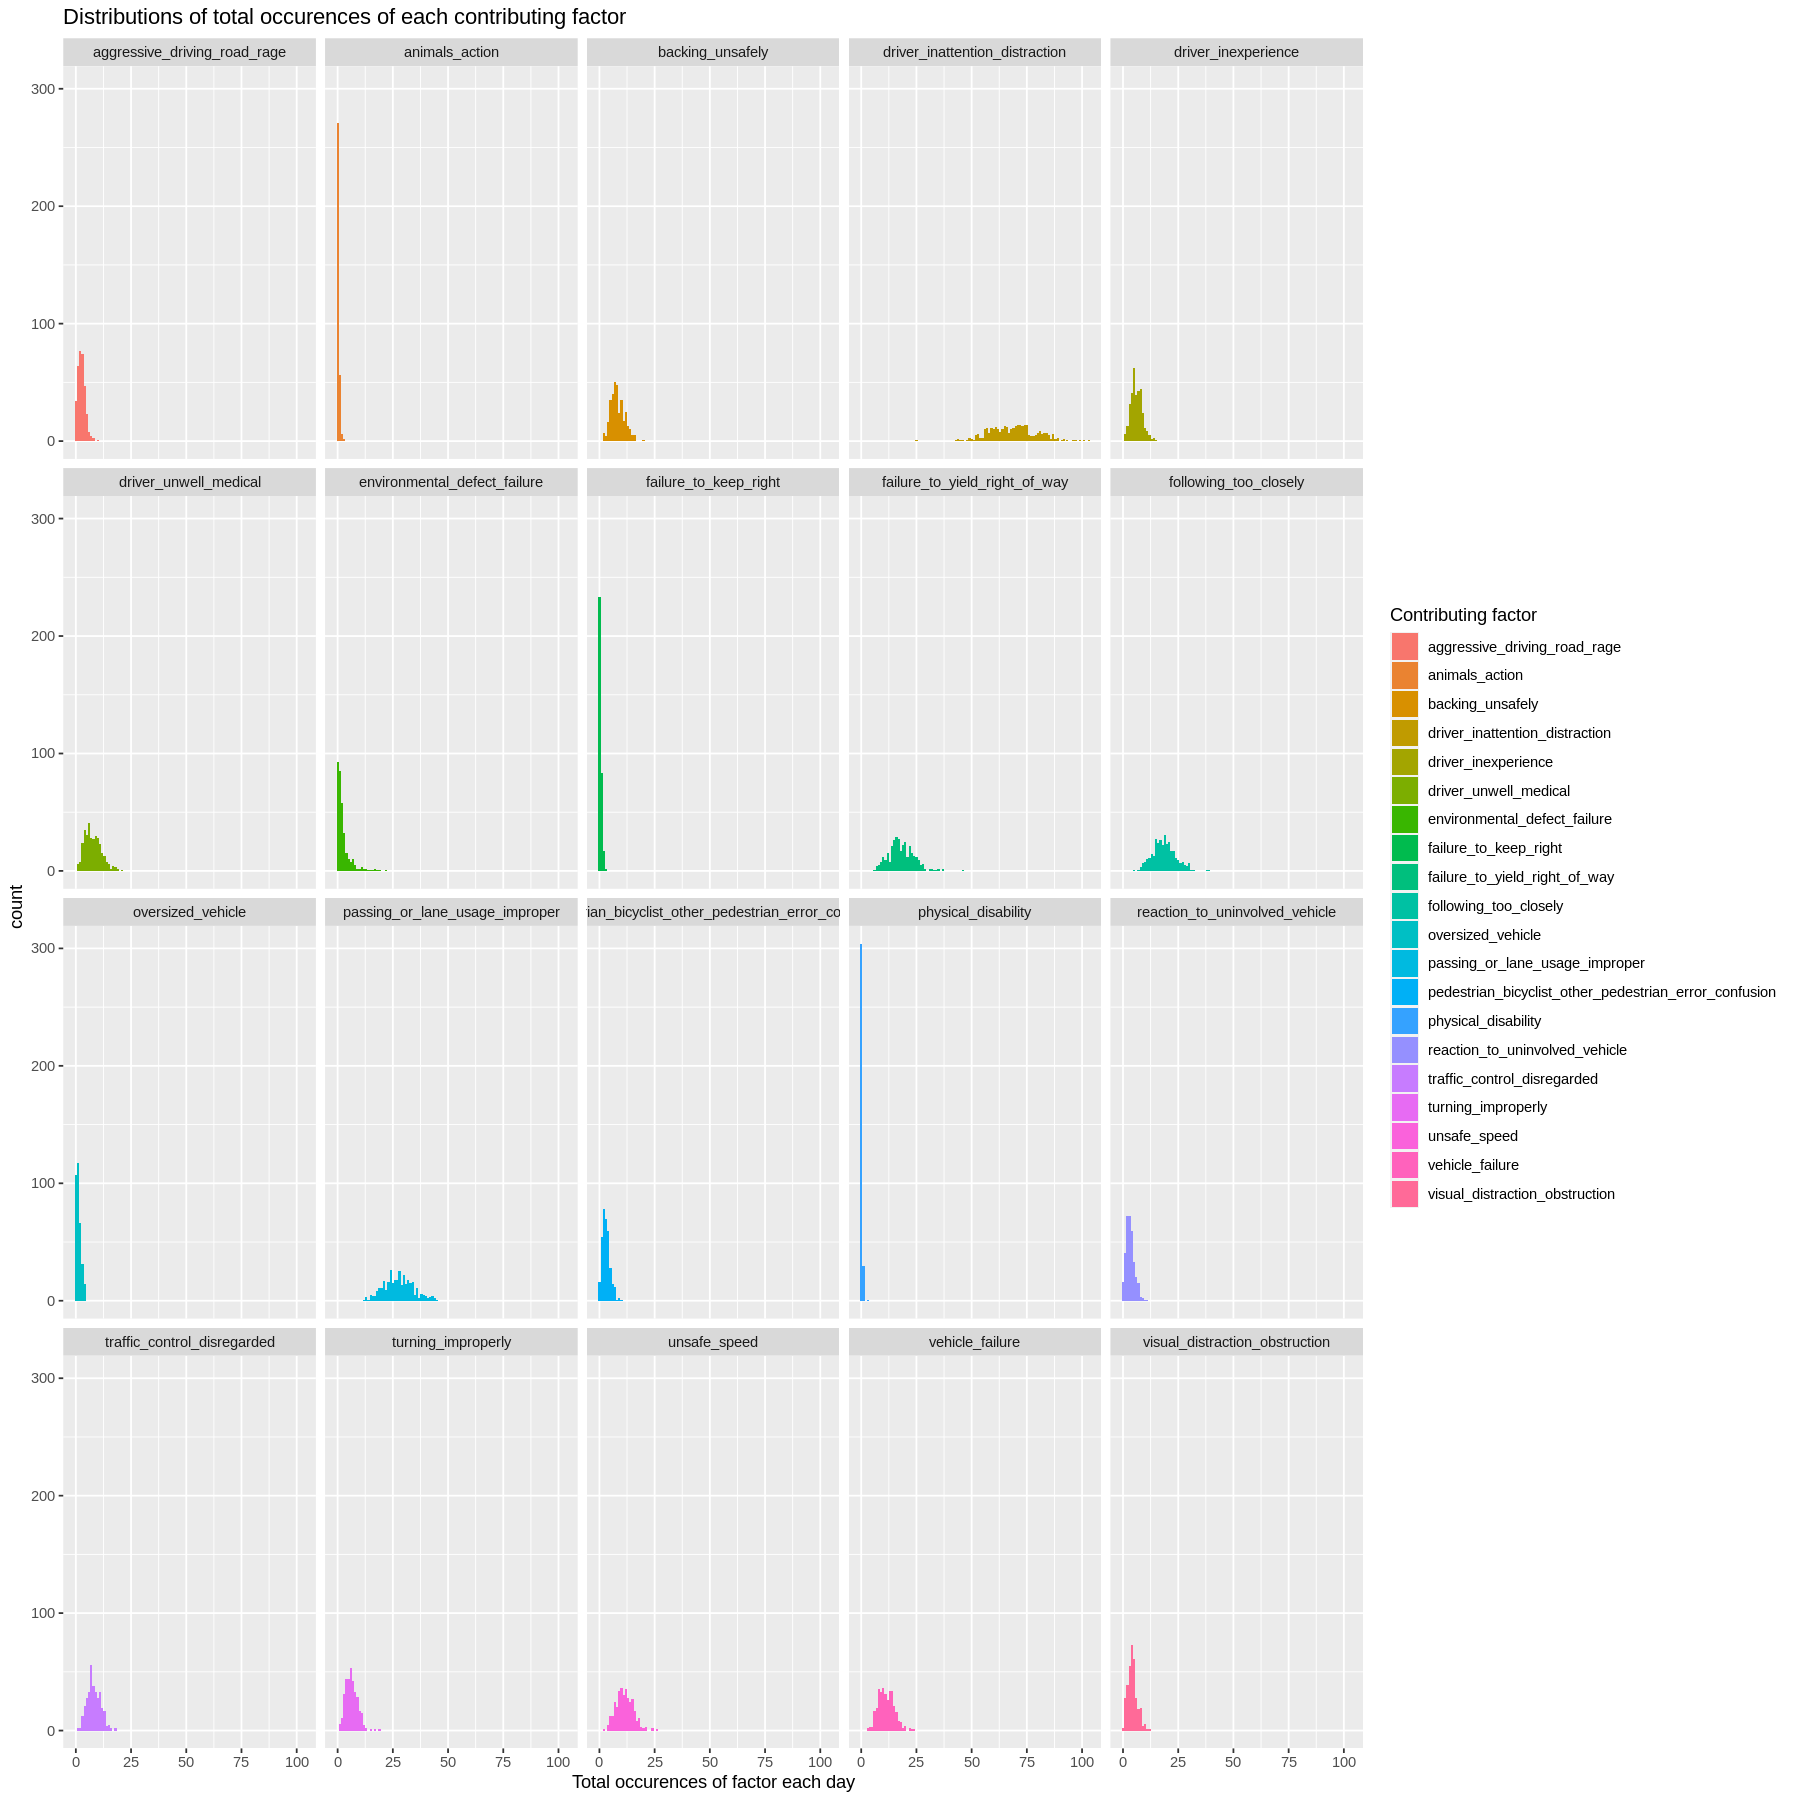

In [33]:
# create plot to show distributions of each contributing factor
cwt6 %>%
  pivot_longer(cols = c(aggressive_driving_road_rage, animals_action, backing_unsafely,
    driver_inattention_distraction, driver_inexperience, driver_unwell_medical,
    environmental_defect_failure, failure_to_keep_right, failure_to_yield_right_of_way,
    following_too_closely, oversized_vehicle, passing_or_lane_usage_improper,
    pedestrian_bicyclist_other_pedestrian_error_confusion, physical_disability,
    reaction_to_uninvolved_vehicle, traffic_control_disregarded, turning_improperly,
    unsafe_speed, vehicle_failure, visual_distraction_obstruction),
    names_to = "contributing_factor",
    values_to = "count") %>%
    ggplot(aes(x = count, fill = contributing_factor)) +
    geom_histogram(binwidth = 1) +
    facet_wrap(~contributing_factor) +
    labs(x = "Total occurences of factor each day",
          title = "Distributions of total occurences of each contributing factor",
          fill = "Contributing factor")

Reviewing the distibution of each contributing factor, it appears each factor contributes to a collision at a different rate. This will be tested with a Poisson distribution as the number of times the factor results in a collision can be counted, the average number of collisions per day can be calculated, and it is assumed that each factor causing a collision is independent from others - e.g. one driver making an error in an oversized car is independent from another.

Starting with the most prevalent factor (driver inattention), a generalised linear model will be calculated using a Poisson distribution to see if the number of collisions can be estimated.

In [34]:
# create a table and sort by p-value to find the most prevalent factor
lm(data = cwt6, formula = total_collisions ~ aggressive_driving_road_rage +
                                backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                                following_too_closely + passing_or_lane_usage_improper +
                                traffic_control_disregarded + turning_improperly +
                                unsafe_speed + driver_inattention_distraction +
                                driver_inexperience + driver_unwell_medical +
                                reaction_to_uninvolved_vehicle + oversized_vehicle +
                                vehicle_failure + animals_action +
                                pedestrian_bicyclist_other_pedestrian_error_confusion +
                                physical_disability + environmental_defect_failure +
                                visual_distraction_obstruction) %>%
  tidy() %>%
  arrange(p.value)

term                                                  estimate   std.error 
1  driver_inattention_distraction                         1.1398819 0.06139879
2  passing_or_lane_usage_improper                         1.1968729 0.10061425
3  failure_to_yield_right_of_way                          1.3204186 0.11153244
4  (Intercept)                                           37.0415977 4.58747234
5  environmental_defect_failure                           1.3579257 0.17903997
6  following_too_closely                                  0.8397007 0.11953835
7  traffic_control_disregarded                            1.1686902 0.19434250
8  visual_distraction_obstruction                         1.6313116 0.28231988
9  driver_unwell_medical                                  0.9502709 0.16847081
10 driver_inexperience                                    1.1247631 0.22699823
11 turning_improperly                                     1.0568359 0.21769813
12 unsafe_speed                                           0.7242034 0.16204425
13 reaction_to_uninvolved_vehicle                         1.0651518 0.30766800
14 backing_unsafely                                       0.6371200 0.19733528
15 vehicle_failure                                        0.5629066 0.17596089
16 pedestrian_bicyclist_other_pedestrian_error_confusion  0.8979274 0.33879099
17 aggressive_driving_road_rage                           0.6298925 0.34289191
18 failure_to_keep_right                                  1.4402825 0.95666099
19 physical_disability                                    2.1487048 1.76654547
20 oversized_vehicle                                      0.1975824 0.54437135
21 animals_action                                         0.3891594 1.18592180
   statistic  p.value     
1  18.5652167 1.905018e-52
2  11.8956595 3.453535e-27
3  11.8388752 5.517115e-27
4   8.0745114 1.462497e-14
5   7.5844834 3.810102e-13
6   7.0245298 1.337677e-11
7   6.0135595 5.040412e-09
8   5.7782387 1.818345e-08
9   5.6405668 3.783225e-08
10  4.9549422 1.184941e-06
11  4.8545937 1.904910e-06
12  4.4691706 1.097754e-05
13  3.4620169 6.104574e-04
14  3.2286170 1.375462e-03
15  3.1990439 1.519625e-03
16  2.6503875 8.447311e-03
17  1.8370002 6.715484e-02
18  1.5055307 1.331929e-01
19  1.2163314 2.247722e-01
20  0.3629552 7.168825e-01
21  0.3281493 7.430175e-01

In [35]:
# ensure no nulls
driver_inattention_distraction_not_null <-
  cwt6_factorised %>%
    filter(!is.na(driver_inattention_distraction),
            !is.na(temp_c),
            !is.na(slp_c),
            !is.na(visib_c),
            !is.na(wdsp_c),
            !is.na(prcp_c),
            !is.na(fog_c),
            !is.na(avg_speed_all)
    ) %>%
    mutate(id = row_number())

# set seed for repeatability
set.seed(7)

# create a training set
train_did <- driver_inattention_distraction_not_null %>% sample_frac(0.70)

# create a testing set
test_did <- anti_join(driver_inattention_distraction_not_null, train_did, by = 'id')

# build a model with all
m1 <- glm(driver_inattention_distraction ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=train_did, family=poisson('log'))

# build models removing one variable in turn and anlyse to see if fit can be improved
m2 <- glm(driver_inattention_distraction ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + month, data=train_did, family=poisson('log'))
m3 <- glm(driver_inattention_distraction ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + avg_speed_all + day, data=train_did, family=poisson('log'))
m4 <- glm(driver_inattention_distraction ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + fog_c + avg_speed_all + day_of_week, data=train_did, family=poisson('log'))
m5 <- glm(driver_inattention_distraction ~ month + day + day_of_week + temp_c + slp_c + visib_c + prcp_c + fog_c + avg_speed_all + temp_c, data=train_did, family=poisson('log'))
m6 <- glm(driver_inattention_distraction ~ month + day + day_of_week + temp_c + slp_c + wdsp_c + prcp_c + fog_c + avg_speed_all + slp_c, data=train_did, family=poisson('log'))
m7 <- glm(driver_inattention_distraction ~ month + day + day_of_week + temp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + visib_c, data=train_did, family=poisson('log'))
m8 <- glm(driver_inattention_distraction ~ month + day + day_of_week + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + wdsp_c, data=train_did, family=poisson('log'))
m9 <- glm(driver_inattention_distraction ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + prcp_c, data=train_did, family=poisson('log'))
m10 <- glm(driver_inattention_distraction ~ month + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + fog_c, data=train_did, family=poisson('log'))
m11 <- glm(driver_inattention_distraction ~ day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + fog_c, data=train_did, family=poisson('log'))
anova(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, test = "Chisq")

Resid. Df Resid. Dev Df  Deviance     Pr(>Chi)    
1  179       270.1080    NA           NA           NA
2  180       287.6429    -1 -17.53496689 2.820721e-05
3  180       270.1587     0  17.48424568           NA
4  180       270.1111     0   0.04755755           NA
5  180       270.2909     0  -0.17975346           NA
6  180       270.1996     0   0.09127950           NA
7  180       270.7261     0  -0.52651976           NA
8  180       270.2839     0   0.44218141           NA
9  185       290.2132    -5 -19.92929706 1.288489e-03
10 209       324.6997   -24 -34.48650931 7.638643e-02
11 220       349.9562   -11 -25.25647150 8.360139e-03

The best fitting model is still estimated to be the one explained by all variables, with the lowest residual deviance (270.1).

correct count
1 0       95   
2 1        5

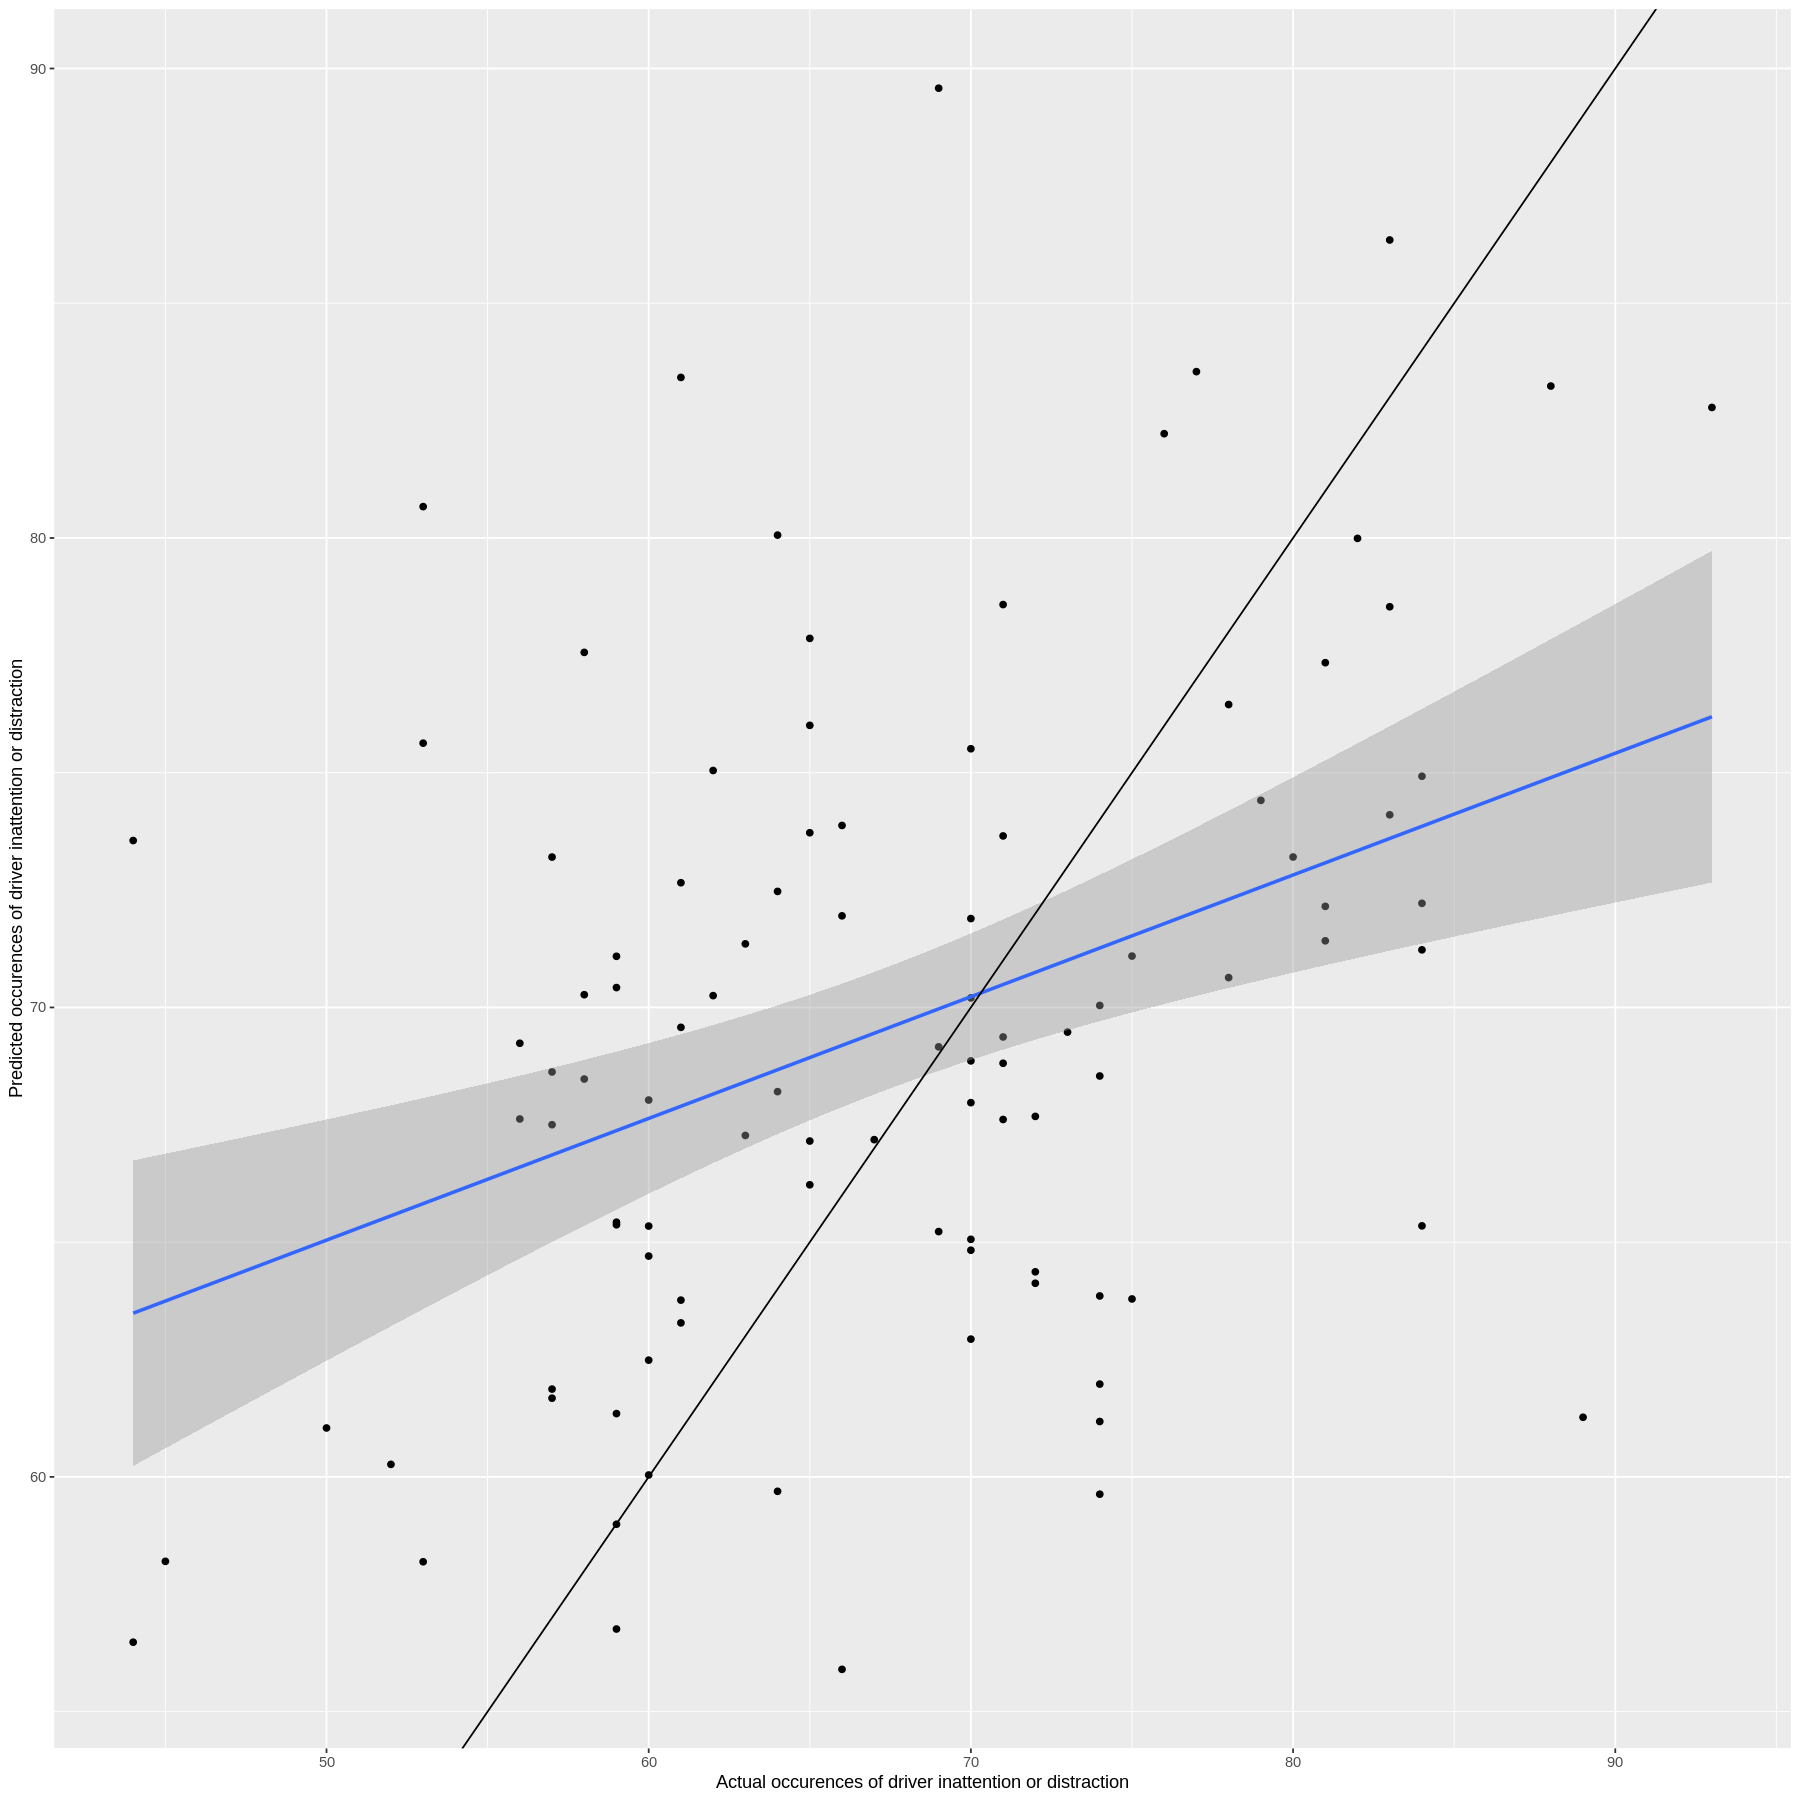

In [36]:
# use model to predict number of occurences
driver_inattention_distraction_not_null_predictions <-
  test_did %>%
  augment(x=m1, newdata = test_did, type.predict = "response")

# plot actuals versus predictions
ggplot(driver_inattention_distraction_not_null_predictions, aes(x = driver_inattention_distraction, y = .fitted)) +
  geom_point() +
  geom_smooth(method = 'lm', formula = 'y~x') +
  geom_abline(slope = 1) +
  labs(x = "Actual occurences of driver inattention or distraction",
        y = "Predicted occurences of driver inattention or distraction")

# count how many are correct (prediction is rounded)
driver_inattention_distraction_not_null_predictions %>%
  mutate(.fitted = round(.fitted, 0),
          correct = if_else(.fitted == driver_inattention_distraction, 1, 0)) %>%
  group_by(correct) %>%
  summarise(count = n())

However, when applied to the test data set, it rarely accurately predicts the number of collisions caused by driver inattention or distraction (only 5%).

This is likely insufficiently accurate to use. However, this will be compared to the linear model.

Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”


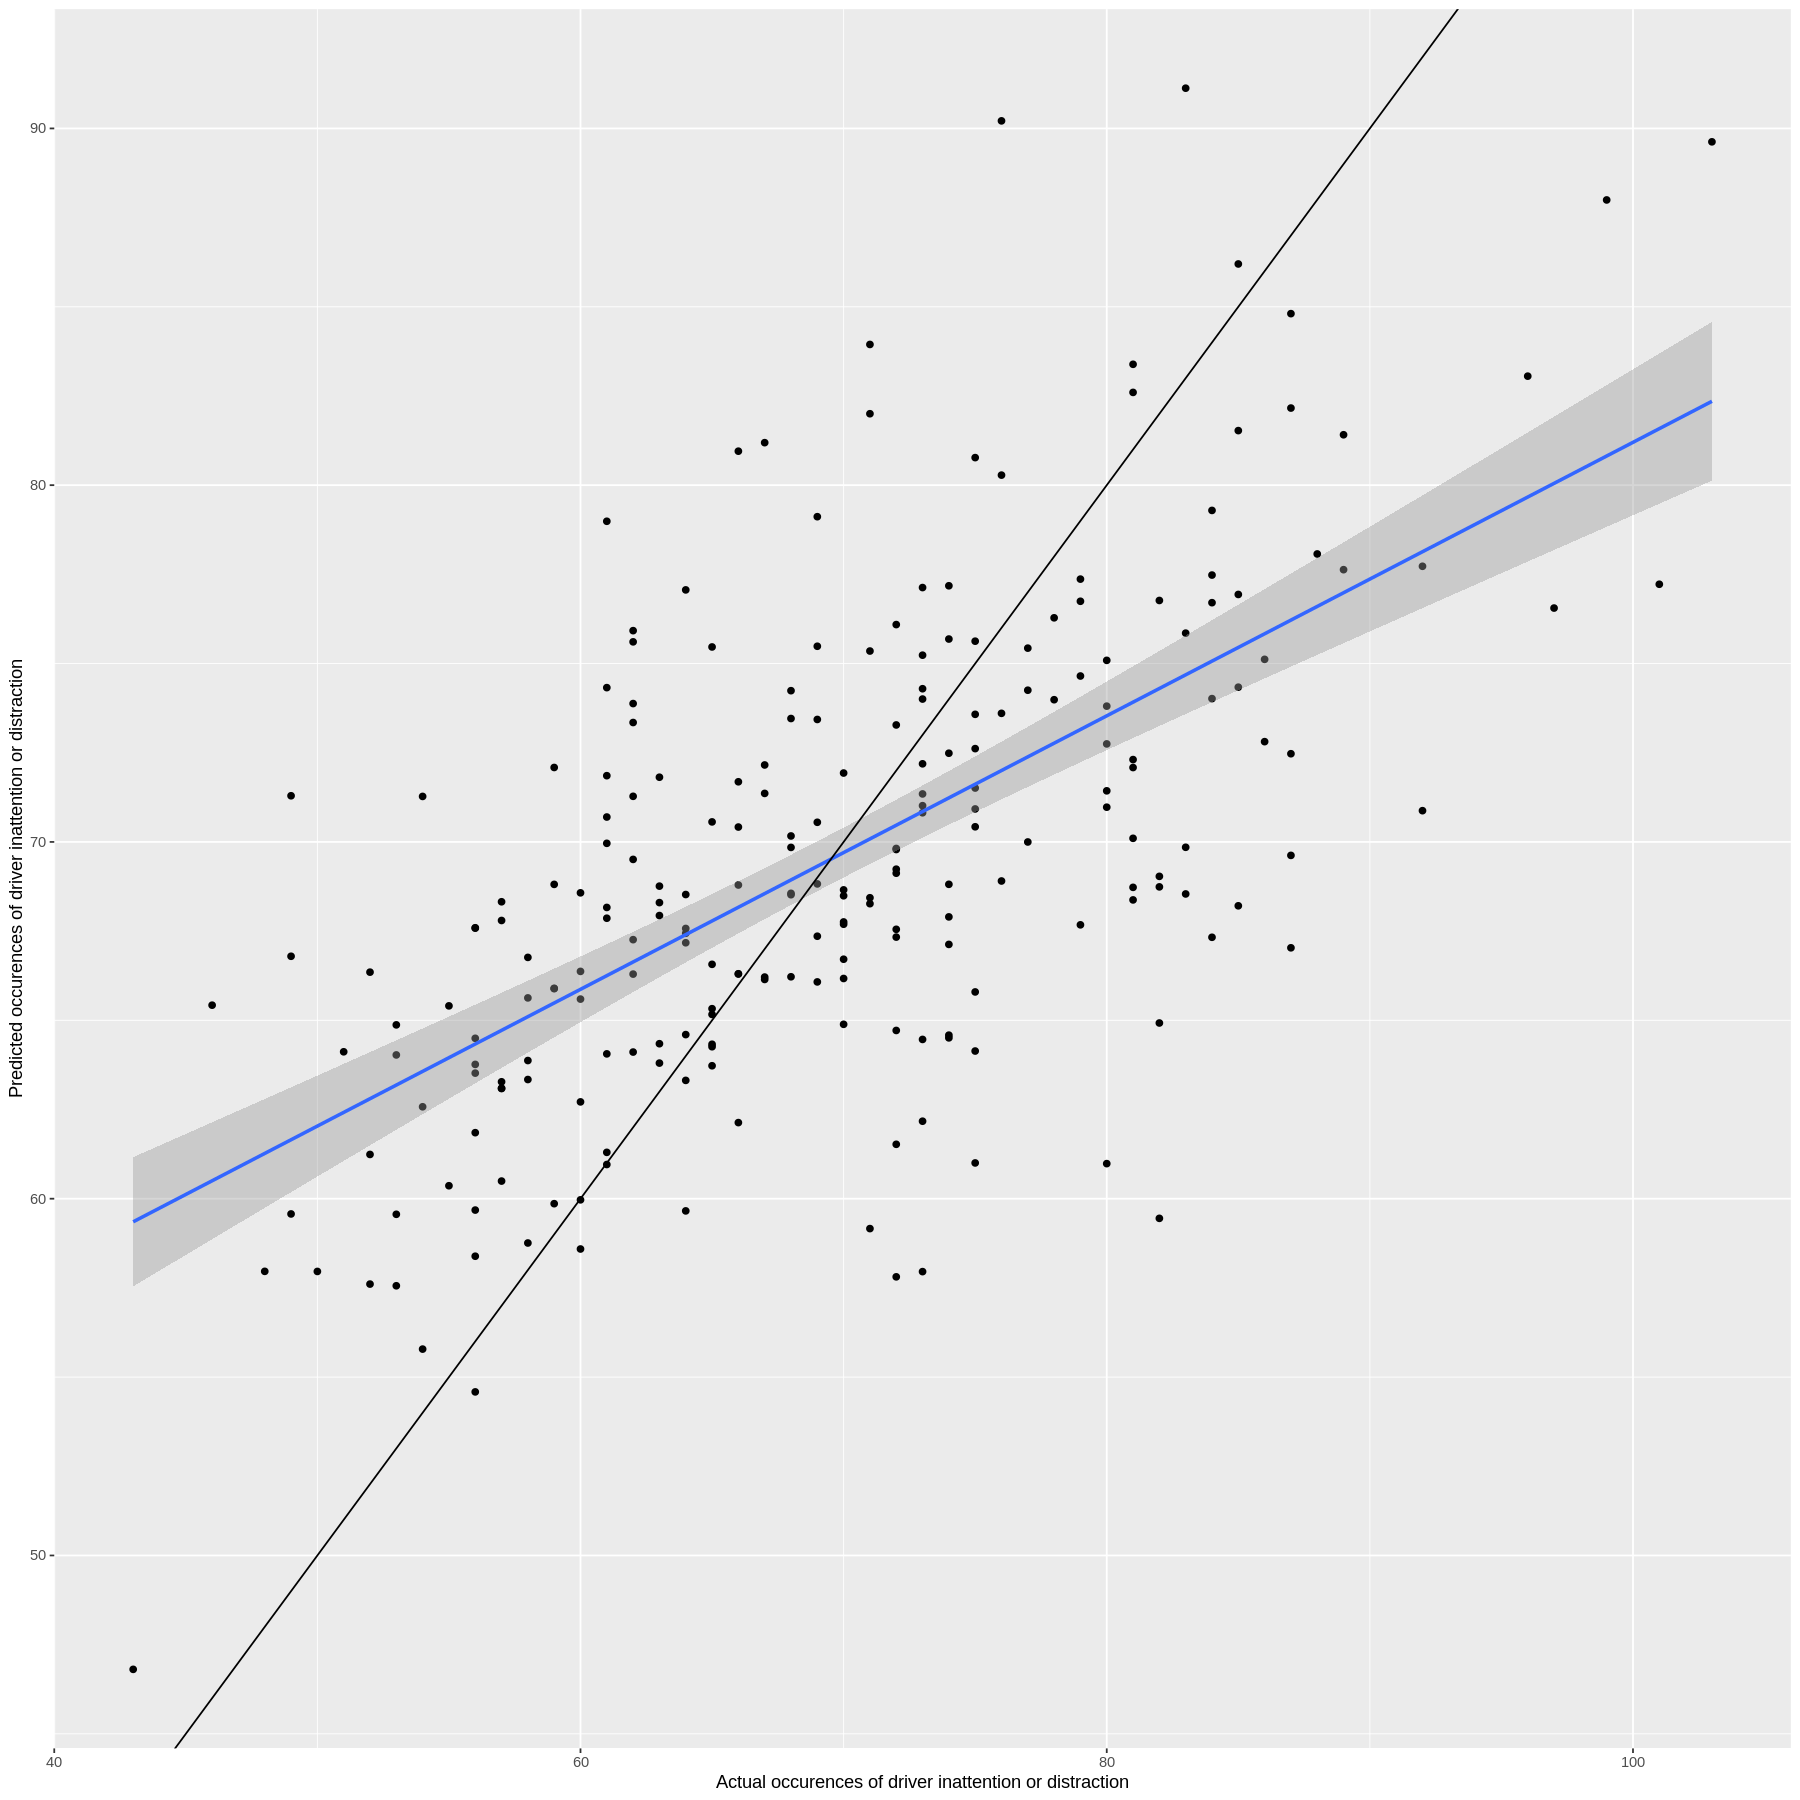

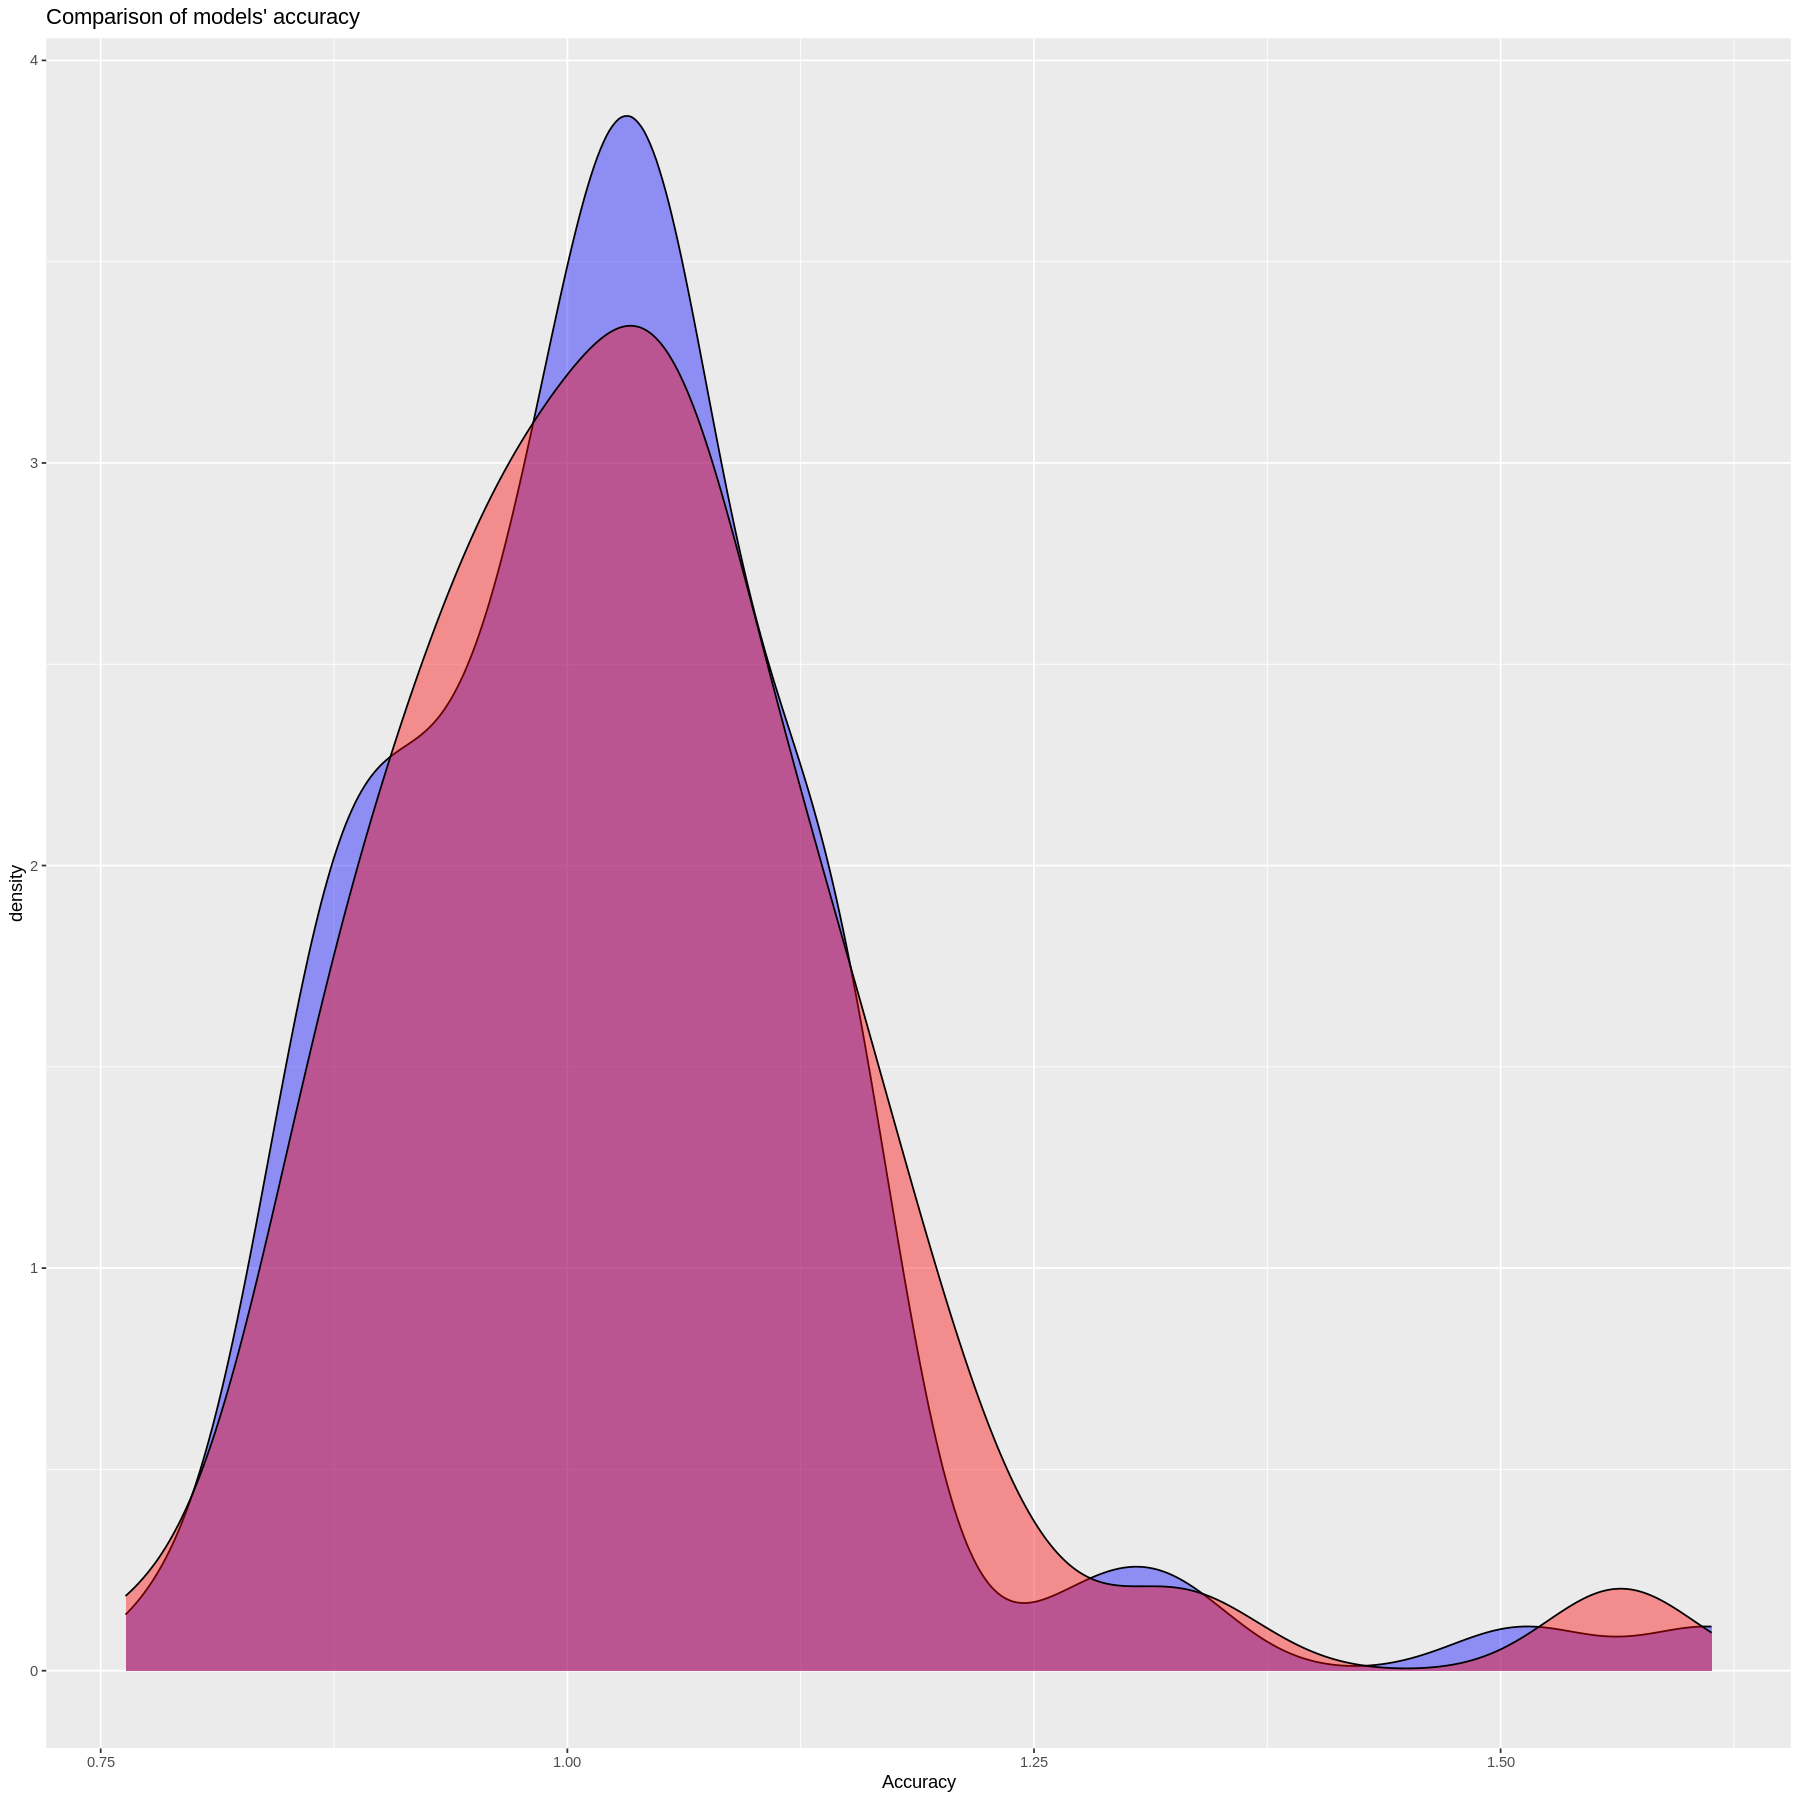

In [37]:
# create test and train datasets
cwt6_factorised <- mutate(cwt6_factorised, id = row_number())
set.seed(7)
cwt6_factorised_train <- cwt6_factorised %>% sample_frac(0.70)
cwt6_factorised_test <- anti_join(cwt6_factorised, cwt6_factorised_train, by = 'id')

# train
lm1 <- lm(data = cwt6_factorised_train, formula = total_collisions ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all)
glm1 <- glm(formula = driver_inattention_distraction ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))

# add modelled driver_inattention_distraction
cwt6_factorised_train <-
  cwt6_factorised_train %>%
  augment(x=glm1, newdata = cwt6_factorised_train, type.predict = "response") %>%
  mutate(driver_inattention_distraction_actual = driver_inattention_distraction,
          driver_inattention_distraction = .fitted)

# draw plot comparing predictions to actuals
ggplot(cwt6_factorised_train, aes(x = driver_inattention_distraction_actual, y = driver_inattention_distraction)) +
  geom_point() +
  geom_smooth(method = 'lm', formula = 'y~x') +
  geom_abline(slope = 1) +
  labs(x = "Actual occurences of driver inattention or distraction",
        y = "Predicted occurences of driver inattention or distraction")

# train
lm2 <- lm(data = cwt6_factorised_train, formula = total_collisions ~ driver_inattention_distraction)

# test
cwt6_factorised_lm1_predictions <-
  cwt6_factorised_test %>%
  augment(x=lm1, newdata = cwt6_factorised_test, type.predict = "response") %>%
  mutate(original_accuracy = .fitted/total_collisions)

cwt6_factorised_glm1_predictions <-
  cwt6_factorised_lm1_predictions %>%
  augment(x=glm1, newdata = cwt6_factorised_lm1_predictions, type.predict = "response") %>%
  mutate(driver_inattention_distraction_actual = driver_inattention_distraction,
          driver_inattention_distraction = .fitted)

cwt6_factorised_lm2_predictions <-
  cwt6_factorised_glm1_predictions %>%
  augment(x=lm2, newdata = cwt6_factorised_glm1_predictions, type.predict = "response") %>%
  mutate(glm_accuracy = .fitted/total_collisions)

# compare distribution of accuracy
cwt6_factorised_lm2_predictions %>%
  ggplot() +
  geom_density(aes(x = original_accuracy), fill = "blue", alpha = 0.4) +
  geom_density(aes(x = glm_accuracy), fill = "red", alpha = 0.4) +
  labs(x = "Accuracy", title = "Comparison of models' accuracy")

In [38]:
glance(lm1)
glance(lm2)

r.squared adj.r.squared sigma    statistic p.value      df logLik   AIC    
1 0.4081923 0.2296582     27.10417 2.286354  2.600998e-05 54 -1072.81 2257.62
  BIC      deviance df.residual nobs
1 2451.118 131499.9 179         234

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.314558  0.3116035     25.62204 106.4677  8.680084e-21 1  -1089.995 2185.991
  BIC      deviance df.residual nobs
1 2196.357 152305.4 232         234

Although the distribution of the accuracy of both models looks comparable, statistically the linear model using the weather variables was better fitted than the model based on a Poisson distribution (R^2=0.41 to R^2=0.31). However, the model should improve in fit, by adding additional estimated factors.

First, it was checked whether any of the factors were strongly correlated with each other. The chart below did not reveal any concerns.

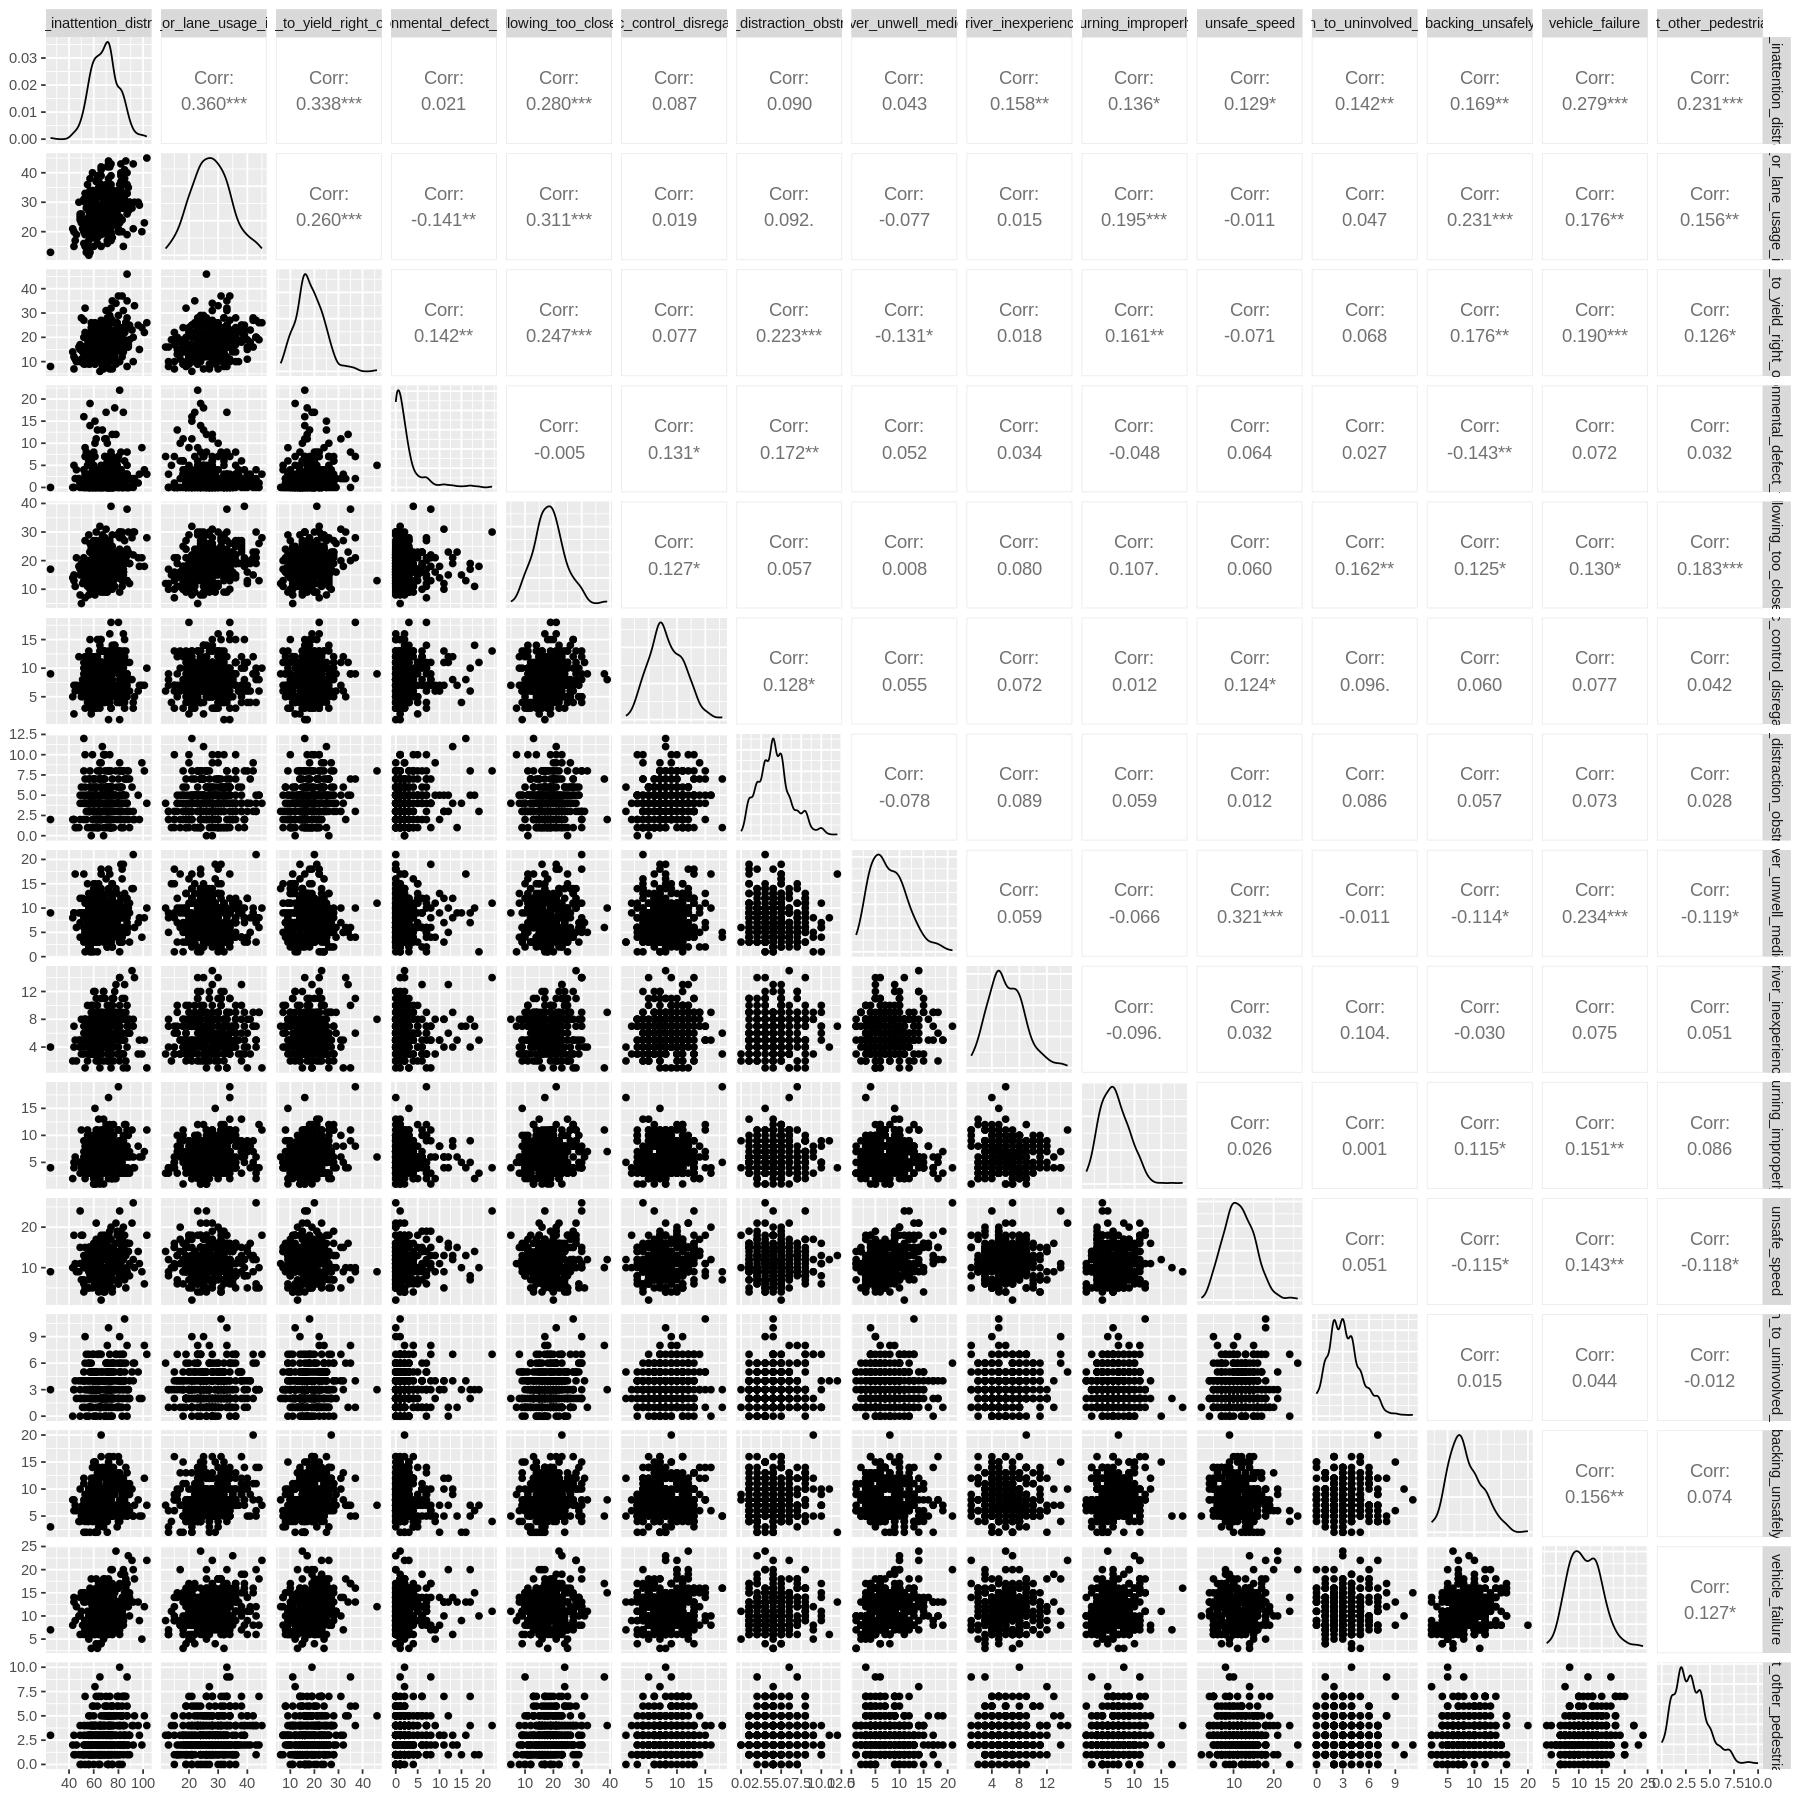

In [39]:
cwt6 %>%
  select("driver_inattention_distraction", "passing_or_lane_usage_improper",
              "failure_to_yield_right_of_way", "environmental_defect_failure", "following_too_closely",
              "traffic_control_disregarded", "visual_distraction_obstruction", "driver_unwell_medical",
              "driver_inexperience", "turning_improperly", "unsafe_speed", "reaction_to_uninvolved_vehicle",
              "backing_unsafely", "vehicle_failure", "pedestrian_bicyclist_other_pedestrian_error_confusion") %>%
  ggpairs()

Then the optimal GLM was calculated for an additional factor: Improper lane usage.

In [40]:
m1 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=train_did, family=poisson('log'))
m2 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + month, data=train_did, family=poisson('log'))
m3 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + avg_speed_all + day, data=train_did, family=poisson('log'))
m4 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + fog_c + avg_speed_all + day_of_week, data=train_did, family=poisson('log'))
m5 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + slp_c + visib_c + prcp_c + fog_c + avg_speed_all + temp_c, data=train_did, family=poisson('log'))
m6 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + slp_c + wdsp_c + prcp_c + fog_c + avg_speed_all + slp_c, data=train_did, family=poisson('log'))
m7 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + visib_c, data=train_did, family=poisson('log'))
m8 <- glm(passing_or_lane_usage_improper ~ month + day + day_of_week + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + wdsp_c, data=train_did, family=poisson('log'))
m9 <- glm(passing_or_lane_usage_improper ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + prcp_c, data=train_did, family=poisson('log'))
m10 <- glm(passing_or_lane_usage_improper ~ month + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + fog_c, data=train_did, family=poisson('log'))
m11 <- glm(passing_or_lane_usage_improper ~ day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all + fog_c, data=train_did, family=poisson('log'))
anova(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, test = "Chisq")

Resid. Df Resid. Dev Df  Deviance    Pr(>Chi)    
1  179       223.6838    NA          NA           NA
2  180       227.1165    -1  -3.4327024 6.391743e-02
3  180       225.2979     0   1.8185388           NA
4  180       223.6844     0   1.6135237           NA
5  180       227.2650     0  -3.5805812           NA
6  180       235.1168     0  -7.8517835           NA
7  180       224.1841     0  10.9326745           NA
8  180       223.6919     0   0.4921561           NA
9  185       251.5080    -5 -27.8161029 3.953871e-05
10 209       258.5330   -24  -7.0249523 9.997018e-01
11 220       294.0491   -11 -35.5160756 2.036119e-04

Again the best model, with the lowest residual deviance (223.68) uses all of the variables.

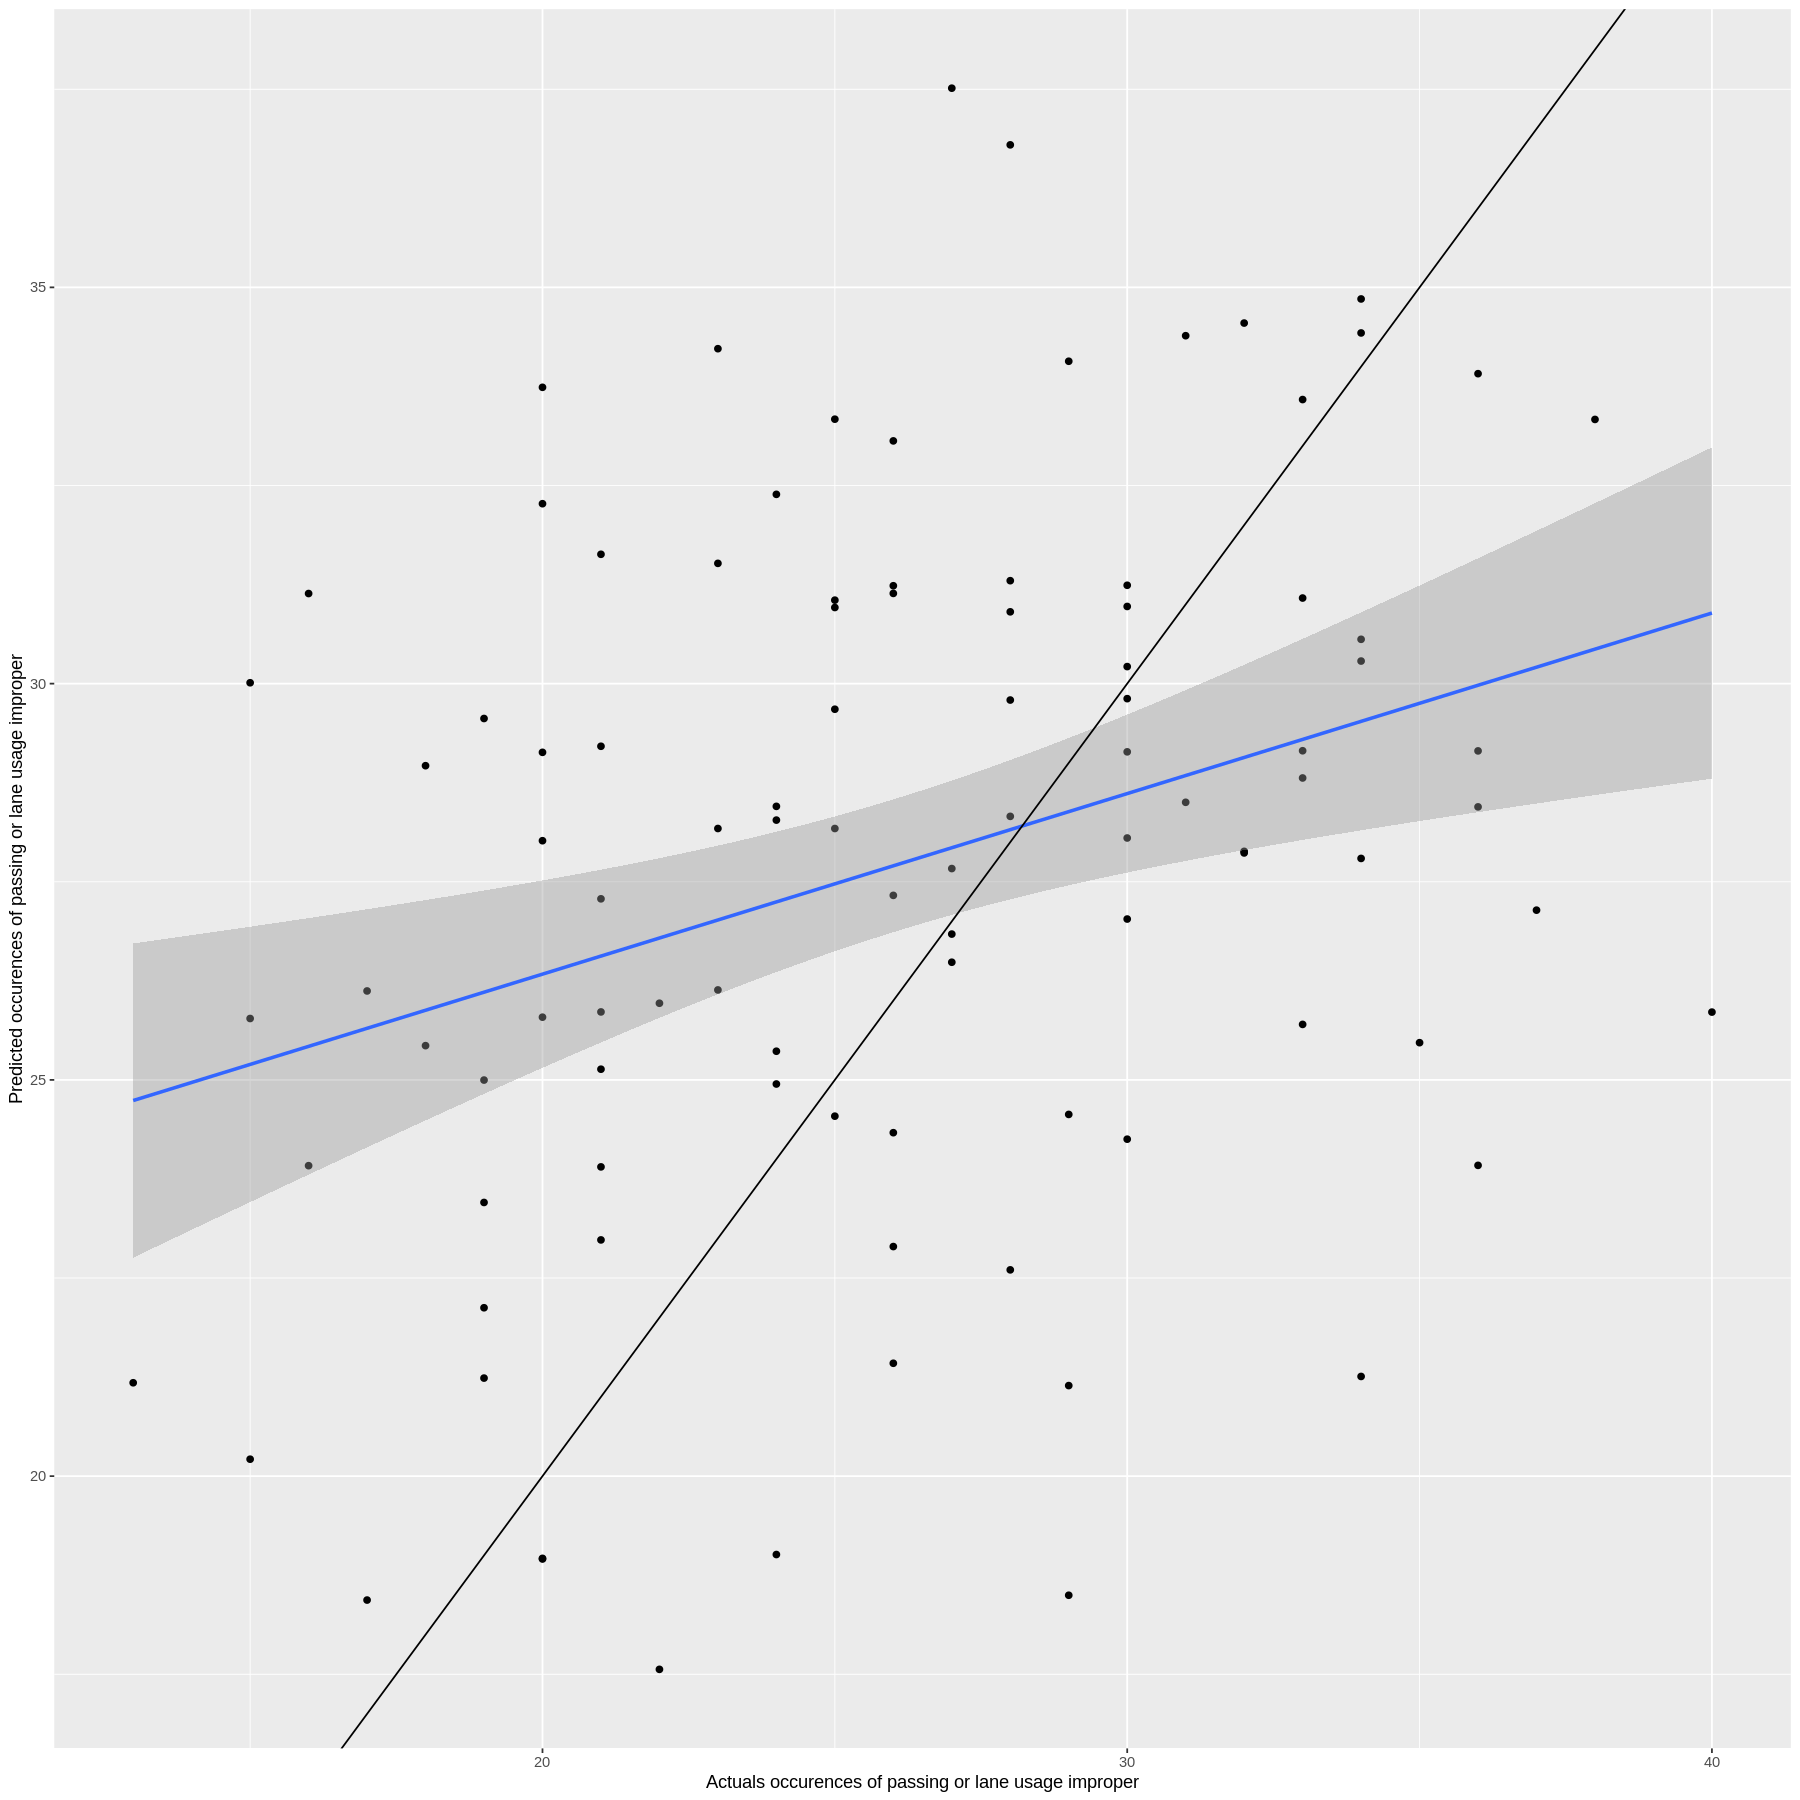

In [41]:
passing_or_lane_usage_improper_predictions <-
  test_did %>%
  augment(x=m1, newdata = test_did, type.predict = "response")

ggplot(passing_or_lane_usage_improper_predictions, aes(x = passing_or_lane_usage_improper, y = .fitted)) +
  geom_point() +
  geom_smooth(method = 'lm', formula = 'y~x') +
  geom_abline(slope = 1) +
  labs(x = "Actuals occurences of passing or lane usage improper",
        y = "Predicted occurences of passing or lane usage improper")

Testing the model suggests that it is again not very accurate.

Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”


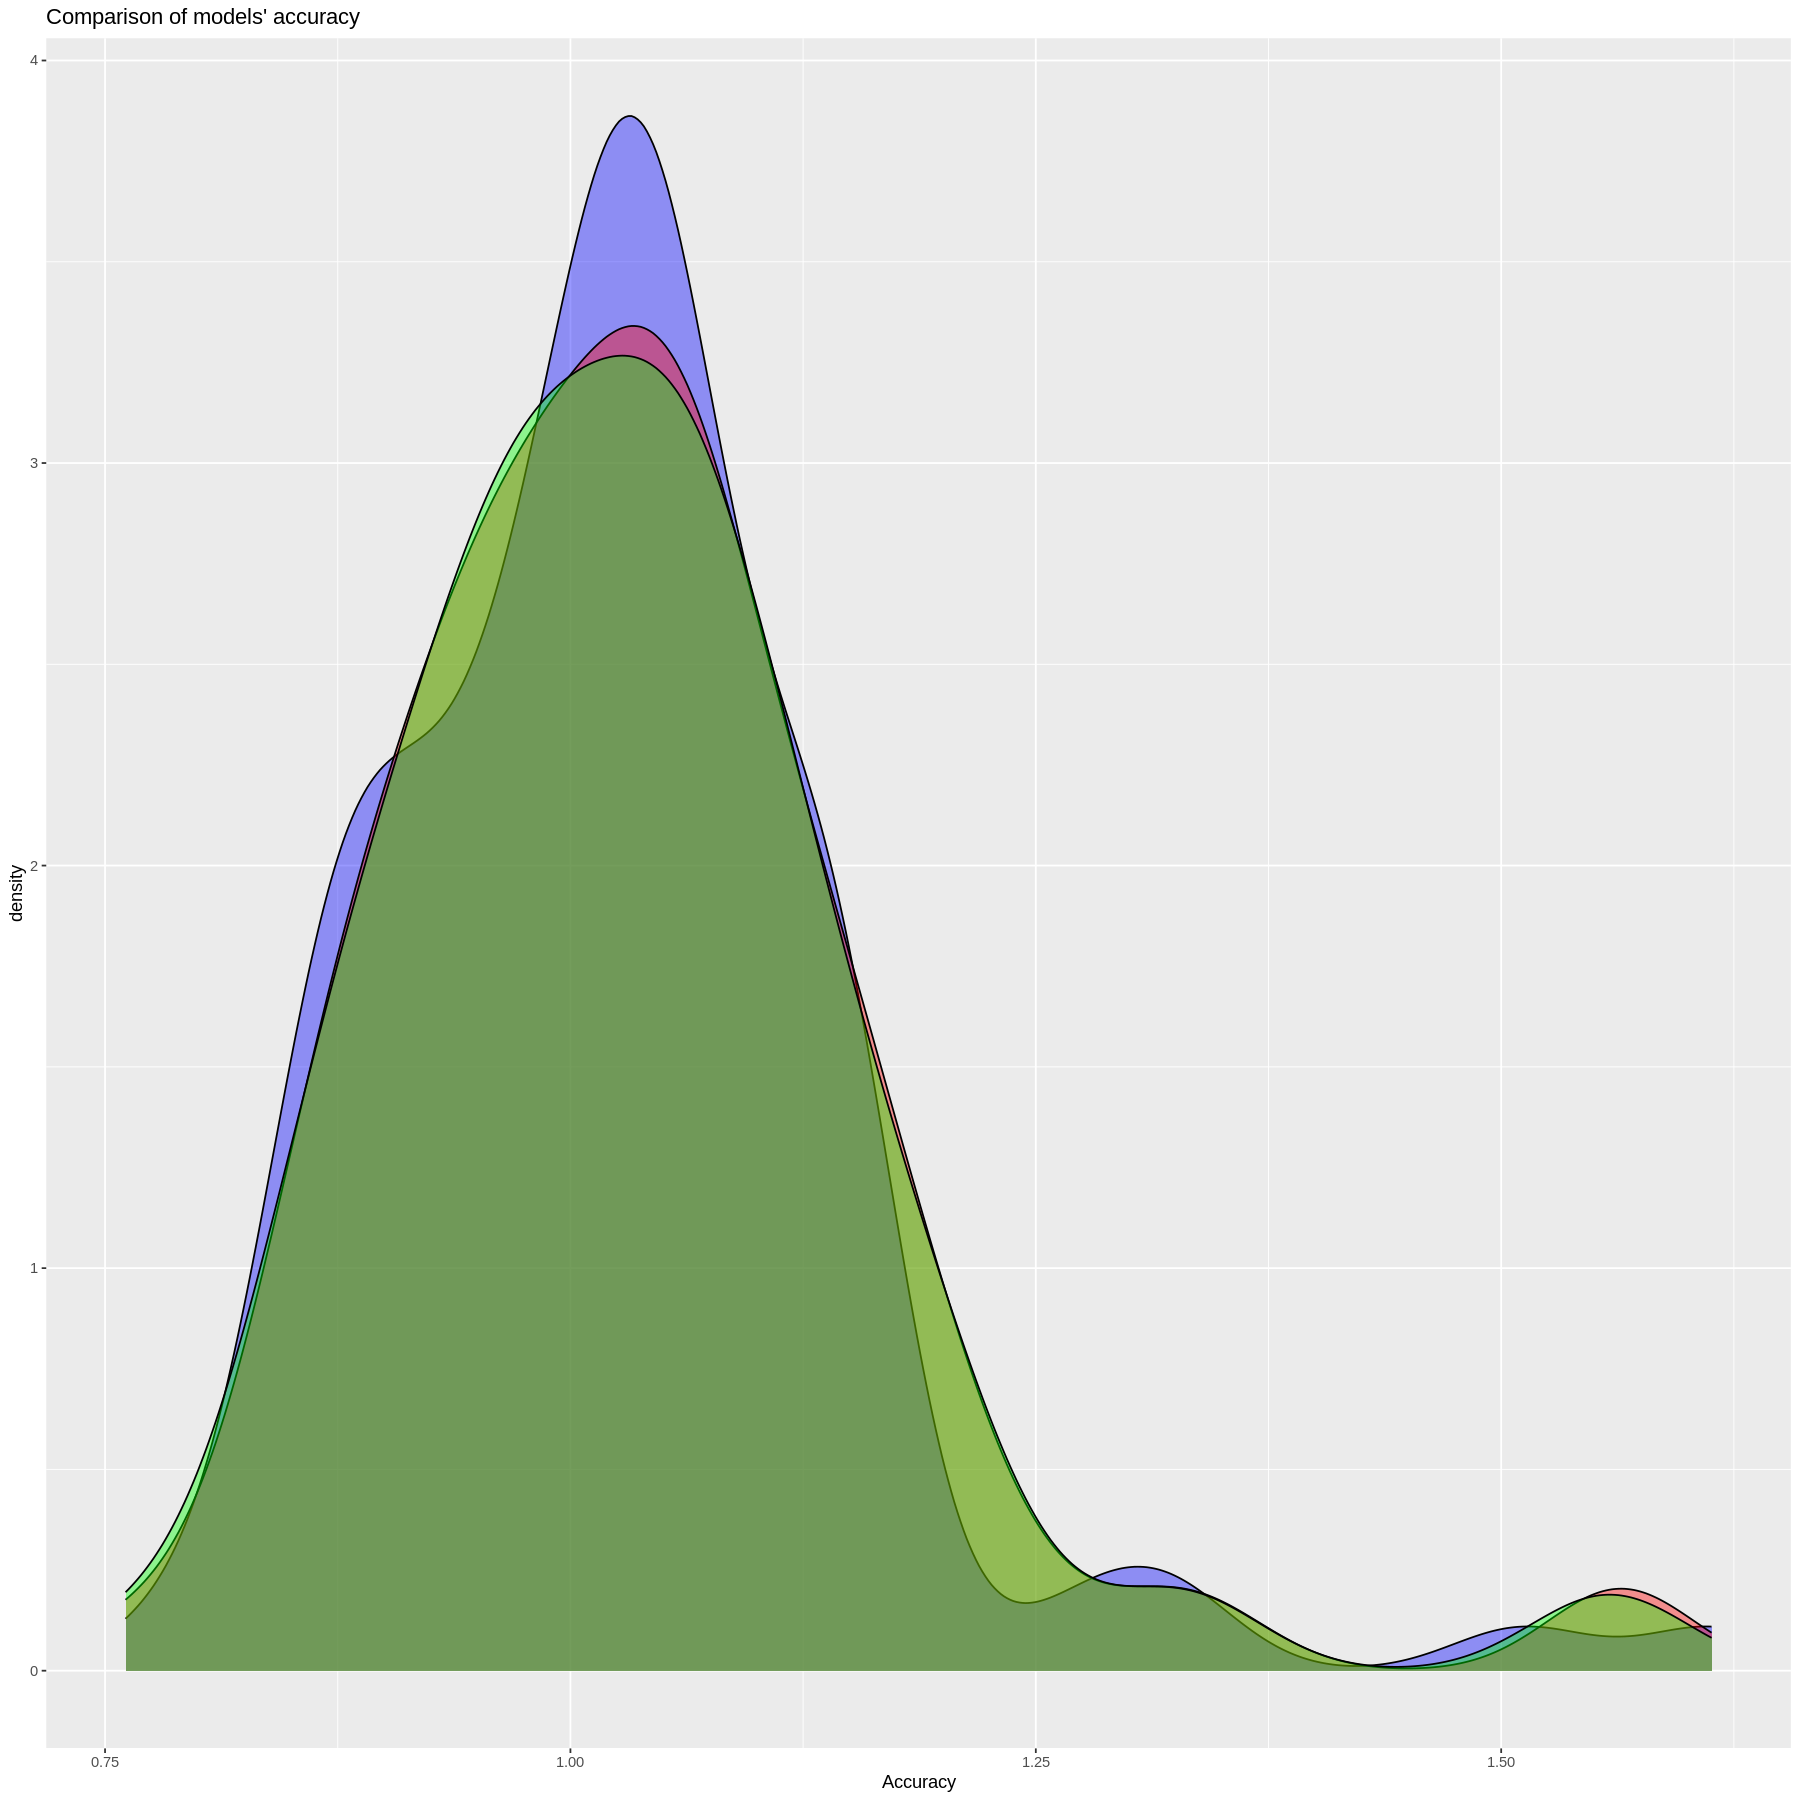

In [42]:
# train
glm2 <- glm(formula = passing_or_lane_usage_improper ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))

# add modelled passing_or_lane_usage_improper
cwt6_factorised_train <-
  augment(x=glm2, newdata = cwt6_factorised_train, type.predict = "response") %>%
  mutate(passing_or_lane_usage_improper_actual = passing_or_lane_usage_improper,
          passing_or_lane_usage_improper = .fitted)

lm3 <- lm(data = cwt6_factorised_train, formula = total_collisions ~ driver_inattention_distraction + passing_or_lane_usage_improper)

# test
cwt6_factorised_glm2_predictions <-
  augment(x=glm2, newdata = cwt6_factorised_lm2_predictions, type.predict = "response") %>%
  mutate(passing_or_lane_usage_improper_actual = passing_or_lane_usage_improper,
          passing_or_lane_usage_improper = .fitted)

cwt6_factorised_lm3_predictions <-
  augment(x=lm3, newdata = cwt6_factorised_glm2_predictions, type.predict = "response") %>%
  mutate(glm2_accuracy = .fitted/total_collisions)

# plot accuracy
cwt6_factorised_lm3_predictions %>%
  ggplot() +
  geom_density(aes(x = original_accuracy), fill = "blue", alpha = 0.4) +
  geom_density(aes(x = glm_accuracy), fill = "red", alpha = 0.4) +
  geom_density(aes(x = glm2_accuracy), fill = "green", alpha = 0.4) +
  labs(x = "Accuracy", title = "Comparison of models' accuracy")

In [43]:
glance(lm1)
glance(lm2)
glance(lm3)

r.squared adj.r.squared sigma    statistic p.value      df logLik   AIC    
1 0.4081923 0.2296582     27.10417 2.286354  2.600998e-05 54 -1072.81 2257.62
  BIC      deviance df.residual nobs
1 2451.118 131499.9 179         234

r.squared adj.r.squared sigma    statistic p.value      df logLik    AIC     
1 0.314558  0.3116035     25.62204 106.4677  8.680084e-21 1  -1089.995 2185.991
  BIC      deviance df.residual nobs
1 2196.357 152305.4 232         234

r.squared adj.r.squared sigma    statistic p.value     df logLik    AIC     
1 0.3199452 0.3140573     25.57634 54.33926  4.55847e-20 2  -1089.072 2186.144
  BIC      deviance df.residual nobs
1 2199.966 151108.4 231         234

The increase in model fit from 0.315 to 0.320 is very small, with little change to the charted model accuracies. To help assess if this idea is worth pursuing, it is assumed that for each of the factors, the best model uses all the available variables and a model with factors was trained and tested.

Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_density()`).”


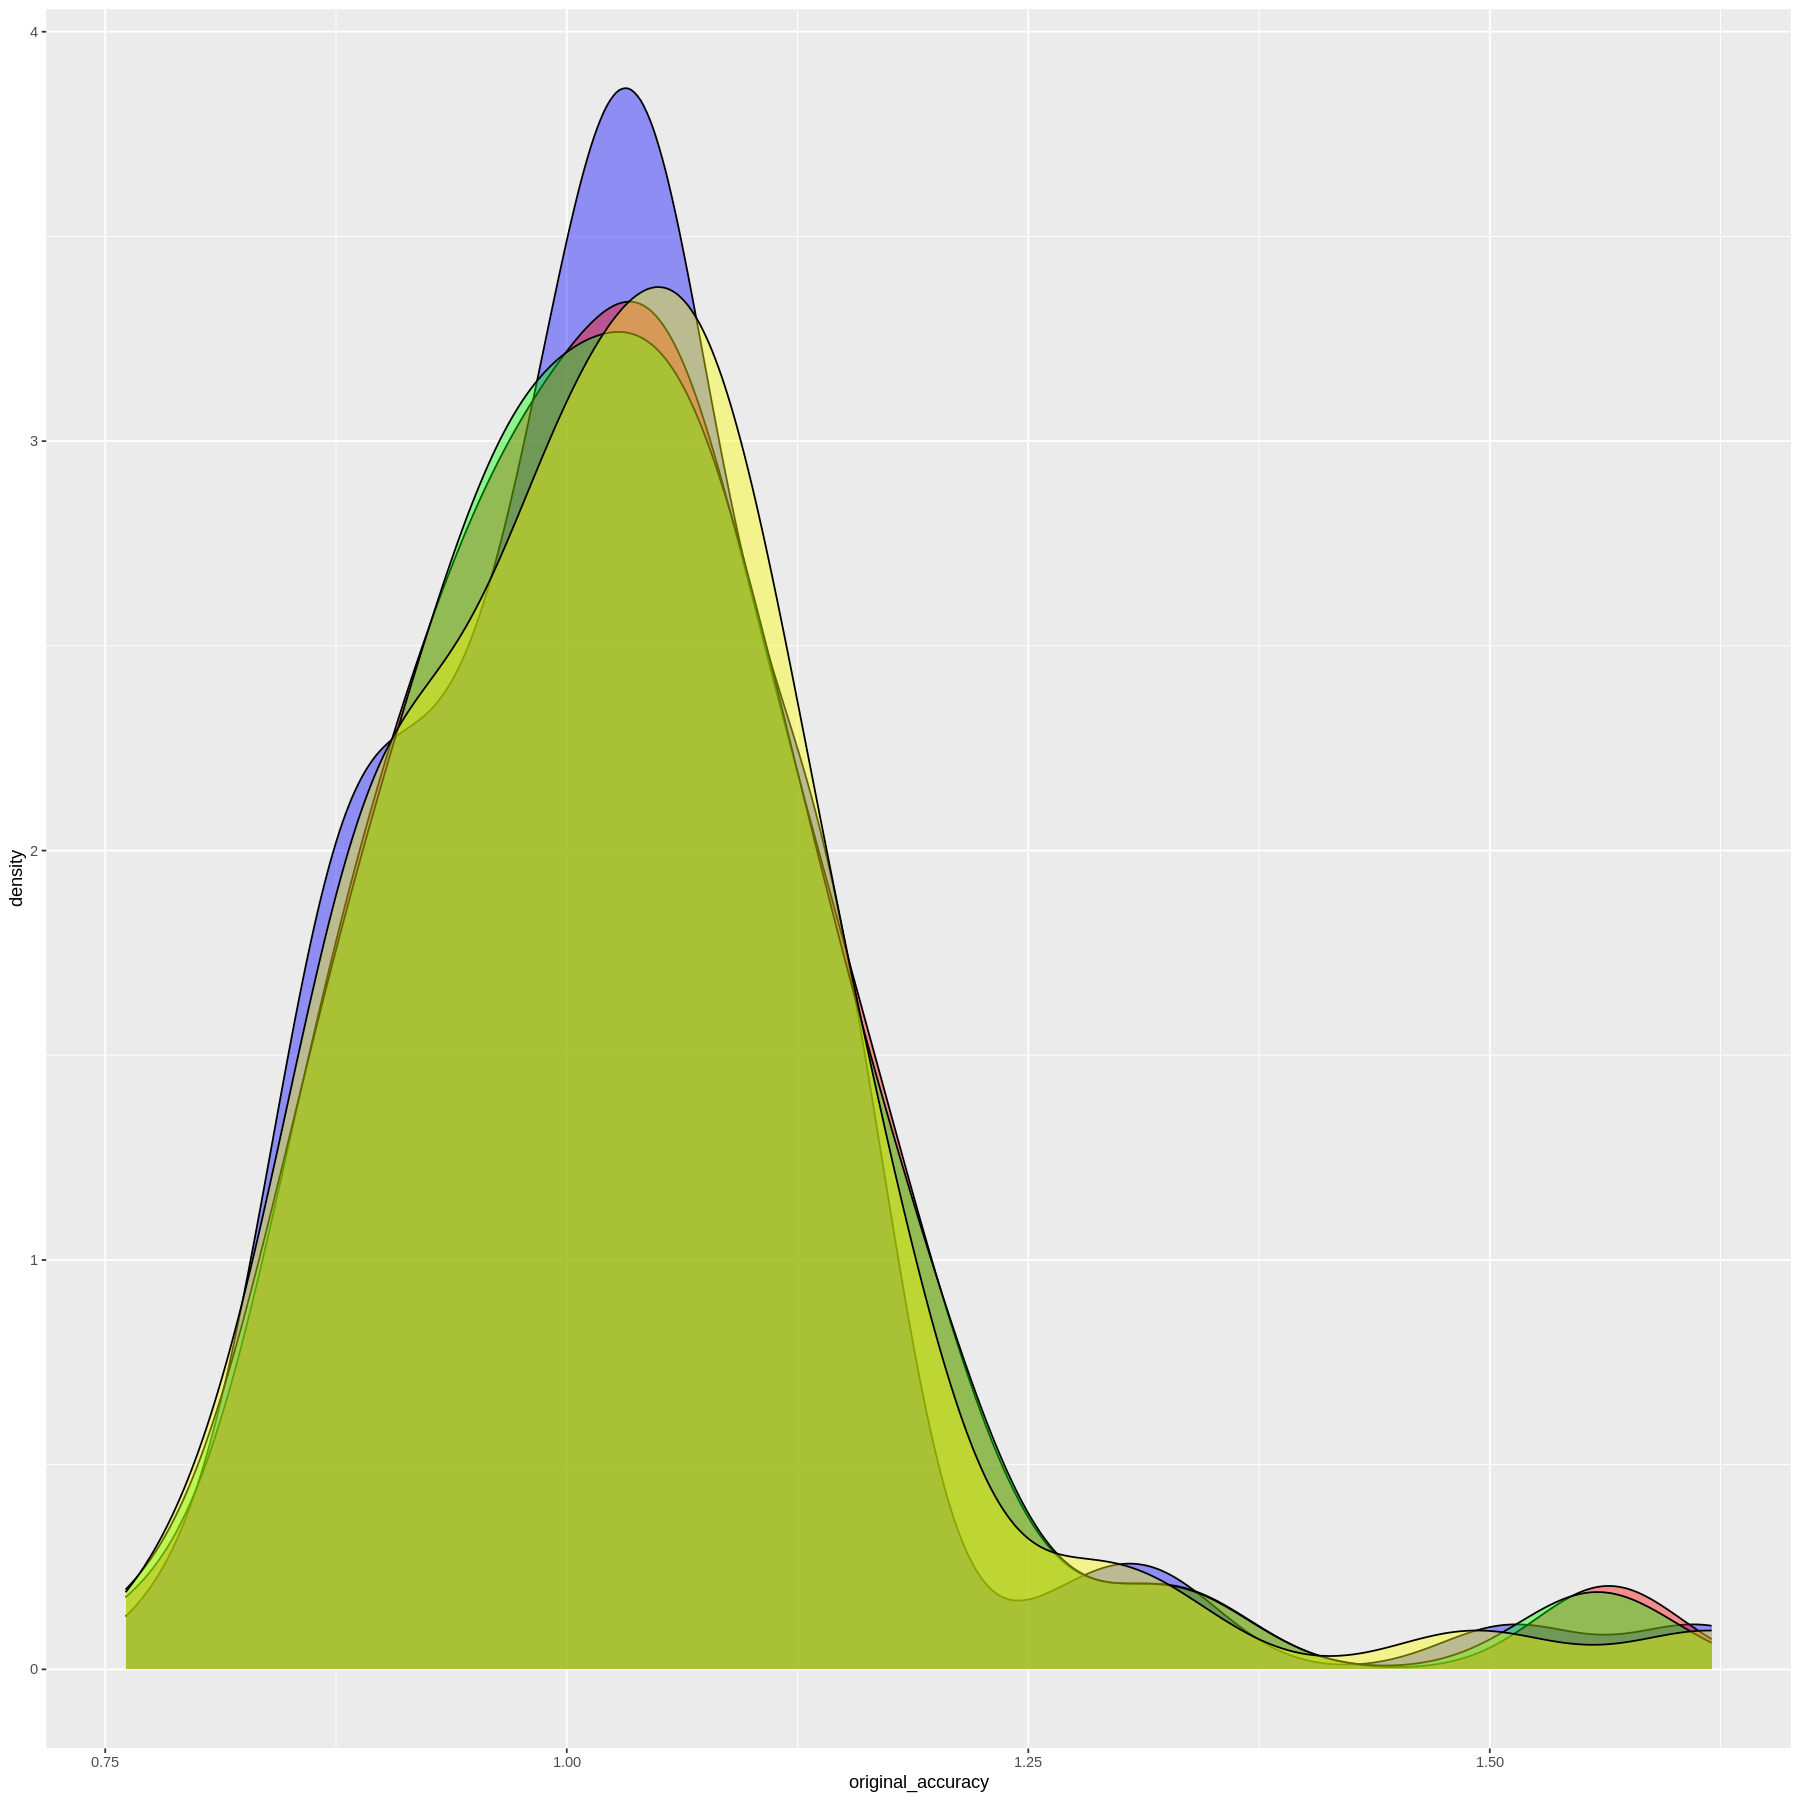

In [44]:
# train
glm3 <- glm(formula = aggressive_driving_road_rage ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm4 <- glm(formula = backing_unsafely ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm5 <- glm(formula = failure_to_keep_right ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm6 <- glm(formula = failure_to_yield_right_of_way ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm7 <- glm(formula = following_too_closely ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm8 <- glm(formula = traffic_control_disregarded ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm9 <- glm(formula = turning_improperly ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm10 <- glm(formula = unsafe_speed ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm11 <- glm(formula = driver_inexperience ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm12 <- glm(formula = reaction_to_uninvolved_vehicle ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm13 <- glm(formula = driver_unwell_medical ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm14 <- glm(formula = oversized_vehicle ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm15 <- glm(formula = vehicle_failure ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm16 <- glm(formula = animals_action ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm17 <- glm(formula = pedestrian_bicyclist_other_pedestrian_error_confusion ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm18 <- glm(formula = physical_disability ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm19 <- glm(formula = environmental_defect_failure ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))
glm20 <- glm(formula = visual_distraction_obstruction ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data=cwt6_factorised_train, family=poisson('log'))

# add modelled variables to training set
cwt6_train_glm3_predictions <-
  augment(x=glm3, newdata = cwt6_factorised_train, type.predict = "response") %>%
  mutate(aggressive_driving_road_rage = .fitted)

cwt6_train_glm4_predictions <-
  augment(x=glm4, newdata = cwt6_train_glm3_predictions, type.predict = "response") %>%
  mutate(backing_unsafely = .fitted)

cwt6_train_glm5_predictions <-
  augment(x=glm5, newdata = cwt6_train_glm4_predictions, type.predict = "response") %>%
  mutate(failure_to_keep_right = .fitted)

cwt6_train_glm6_predictions <-
  augment(x=glm6, newdata = cwt6_train_glm5_predictions, type.predict = "response") %>%
  mutate(failure_to_yield_right_of_way = .fitted)

cwt6_train_glm7_predictions <-
  augment(x=glm7, newdata = cwt6_train_glm6_predictions, type.predict = "response") %>%
  mutate(following_too_closely = .fitted)

cwt6_train_glm8_predictions <-
  augment(x=glm8, newdata = cwt6_train_glm7_predictions, type.predict = "response") %>%
  mutate(traffic_control_disregarded = .fitted)

cwt6_train_glm9_predictions <-
  augment(x=glm9, newdata = cwt6_train_glm8_predictions, type.predict = "response") %>%
  mutate(turning_improperly = .fitted)

cwt6_train_glm10_predictions <-
  augment(x=glm10, newdata = cwt6_train_glm9_predictions, type.predict = "response") %>%
  mutate(unsafe_speed = .fitted)

cwt6_train_glm11_predictions <-
  augment(x=glm11, newdata = cwt6_train_glm10_predictions, type.predict = "response") %>%
  mutate(driver_inexperience = .fitted)

cwt6_train_glm12_predictions <-
  augment(x=glm12, newdata = cwt6_train_glm11_predictions, type.predict = "response") %>%
  mutate(reaction_to_uninvolved_vehicle = .fitted)

cwt6_train_glm13_predictions <-
  augment(x=glm13, newdata = cwt6_train_glm12_predictions, type.predict = "response") %>%
  mutate(driver_unwell_medical = .fitted)

cwt6_train_glm14_predictions <-
  augment(x=glm14, newdata = cwt6_train_glm13_predictions, type.predict = "response") %>%
  mutate(oversized_vehicle = .fitted)

cwt6_train_glm15_predictions <-
  augment(x=glm15, newdata = cwt6_train_glm14_predictions, type.predict = "response") %>%
  mutate(vehicle_failure = .fitted)

cwt6_train_glm16_predictions <-
  augment(x=glm16, newdata = cwt6_train_glm15_predictions, type.predict = "response") %>%
  mutate(animals_action = .fitted)

cwt6_train_glm17_predictions <-
  augment(x=glm17, newdata = cwt6_train_glm16_predictions, type.predict = "response") %>%
  mutate(pedestrian_bicyclist_other_pedestrian_error_confusion = .fitted)

cwt6_train_glm18_predictions <-
  augment(x=glm18, newdata = cwt6_train_glm17_predictions, type.predict = "response") %>%
  mutate(physical_disability = .fitted)

cwt6_train_glm19_predictions <-
  augment(x=glm19, newdata = cwt6_train_glm18_predictions, type.predict = "response") %>%
  mutate(environmental_defect_failure = .fitted)

cwt6_train_glm20_predictions <-
  augment(x=glm20, newdata = cwt6_train_glm19_predictions, type.predict = "response") %>%
  mutate(visual_distraction_obstruction = .fitted)

# train linear model
lm4 <- lm(data = cwt6_factorised_train, formula = total_collisions ~ aggressive_driving_road_rage +
                                backing_unsafely + failure_to_keep_right + failure_to_yield_right_of_way +
                                following_too_closely + passing_or_lane_usage_improper +
                                traffic_control_disregarded + turning_improperly +
                                unsafe_speed + driver_inattention_distraction +
                                driver_inexperience + driver_unwell_medical +
                                reaction_to_uninvolved_vehicle + oversized_vehicle +
                                vehicle_failure + animals_action +
                                pedestrian_bicyclist_other_pedestrian_error_confusion +
                                physical_disability + environmental_defect_failure +
                                visual_distraction_obstruction)

# test
cwt6_factorised_glm3_predictions <-
  augment(x=glm3, newdata = cwt6_factorised_lm3_predictions, type.predict = "response") %>%
  mutate(aggressive_driving_road_rage = .fitted)

cwt6_factorised_glm4_predictions <-
  augment(x=glm4, newdata = cwt6_factorised_glm3_predictions, type.predict = "response") %>%
  mutate(backing_unsafely = .fitted)

cwt6_factorised_glm5_predictions <-
  augment(x=glm5, newdata = cwt6_factorised_glm4_predictions, type.predict = "response") %>%
  mutate(failure_to_keep_right = .fitted)

cwt6_factorised_glm6_predictions <-
  augment(x=glm6, newdata = cwt6_factorised_glm5_predictions, type.predict = "response") %>%
  mutate(failure_to_yield_right_of_way = .fitted)

cwt6_factorised_glm7_predictions <-
  augment(x=glm7, newdata = cwt6_factorised_glm6_predictions, type.predict = "response") %>%
  mutate(following_too_closely = .fitted)

cwt6_factorised_glm8_predictions <-
  augment(x=glm8, newdata = cwt6_factorised_glm7_predictions, type.predict = "response") %>%
  mutate(traffic_control_disregarded = .fitted)

cwt6_factorised_glm9_predictions <-
  augment(x=glm9, newdata = cwt6_factorised_glm8_predictions, type.predict = "response") %>%
  mutate(turning_improperly = .fitted)

cwt6_factorised_glm10_predictions <-
  augment(x=glm10, newdata = cwt6_factorised_glm9_predictions, type.predict = "response") %>%
  mutate(unsafe_speed = .fitted)

cwt6_factorised_glm11_predictions <-
  augment(x=glm11, newdata = cwt6_factorised_glm10_predictions, type.predict = "response") %>%
  mutate(driver_inexperience = .fitted)

cwt6_factorised_glm12_predictions <-
  augment(x=glm12, newdata = cwt6_factorised_glm11_predictions, type.predict = "response") %>%
  mutate(reaction_to_uninvolved_vehicle = .fitted)

cwt6_factorised_glm13_predictions <-
  augment(x=glm13, newdata = cwt6_factorised_glm12_predictions, type.predict = "response") %>%
  mutate(driver_unwell_medical = .fitted)

cwt6_factorised_glm14_predictions <-
  augment(x=glm14, newdata = cwt6_factorised_glm13_predictions, type.predict = "response") %>%
  mutate(oversized_vehicle = .fitted)

cwt6_factorised_glm15_predictions <-
  augment(x=glm15, newdata = cwt6_factorised_glm14_predictions, type.predict = "response") %>%
  mutate(vehicle_failure = .fitted)

cwt6_factorised_glm16_predictions <-
  augment(x=glm16, newdata = cwt6_factorised_glm15_predictions, type.predict = "response") %>%
  mutate(animals_action = .fitted)

cwt6_factorised_glm17_predictions <-
  augment(x=glm17, newdata = cwt6_factorised_glm16_predictions, type.predict = "response") %>%
  mutate(pedestrian_bicyclist_other_pedestrian_error_confusion = .fitted)

cwt6_factorised_glm18_predictions <-
  augment(x=glm18, newdata = cwt6_factorised_glm17_predictions, type.predict = "response") %>%
  mutate(physical_disability = .fitted)

cwt6_factorised_glm19_predictions <-
  augment(x=glm19, newdata = cwt6_factorised_glm18_predictions, type.predict = "response") %>%
  mutate(environmental_defect_failure = .fitted)

cwt6_factorised_glm20_predictions <-
  augment(x=glm20, newdata = cwt6_factorised_glm19_predictions, type.predict = "response") %>%
  mutate(visual_distraction_obstruction = .fitted)


# add linear model predictions
cwt6_factorised_lm4_predictions <-
  augment(x=lm4, newdata = cwt6_factorised_glm20_predictions, type.predict = "response") %>%
  mutate(glm3_accuracy = .fitted/total_collisions)


cwt6_factorised_lm4_predictions %>%
  ggplot() +
  geom_density(aes(x = original_accuracy), fill = "blue", alpha = 0.4) +
  geom_density(aes(x = glm_accuracy), fill = "red", alpha = 0.4) +
  geom_density(aes(x = glm2_accuracy), fill = "green", alpha = 0.4) +
  geom_density(aes(x = glm3_accuracy), fill = "yellow", alpha = 0.4)

In [45]:
lm4 %>% glance()

r.squared adj.r.squared sigma   statistic p.value     df logLik    AIC     
1 0.7549156 0.731903      15.9897 32.80442  5.49277e-54 20 -969.6653 1983.331
  BIC      deviance df.residual nobs
1 2059.348 54457.84 213         234

Although the model was much better fitting (R^2=0.75), it is suspect that this the result of overfitting as the accuracy (as shown by the yellow area in the chart) does not show much improvement. As such this methodology will be abandoned and instead the data reassessed for further points of consideration.

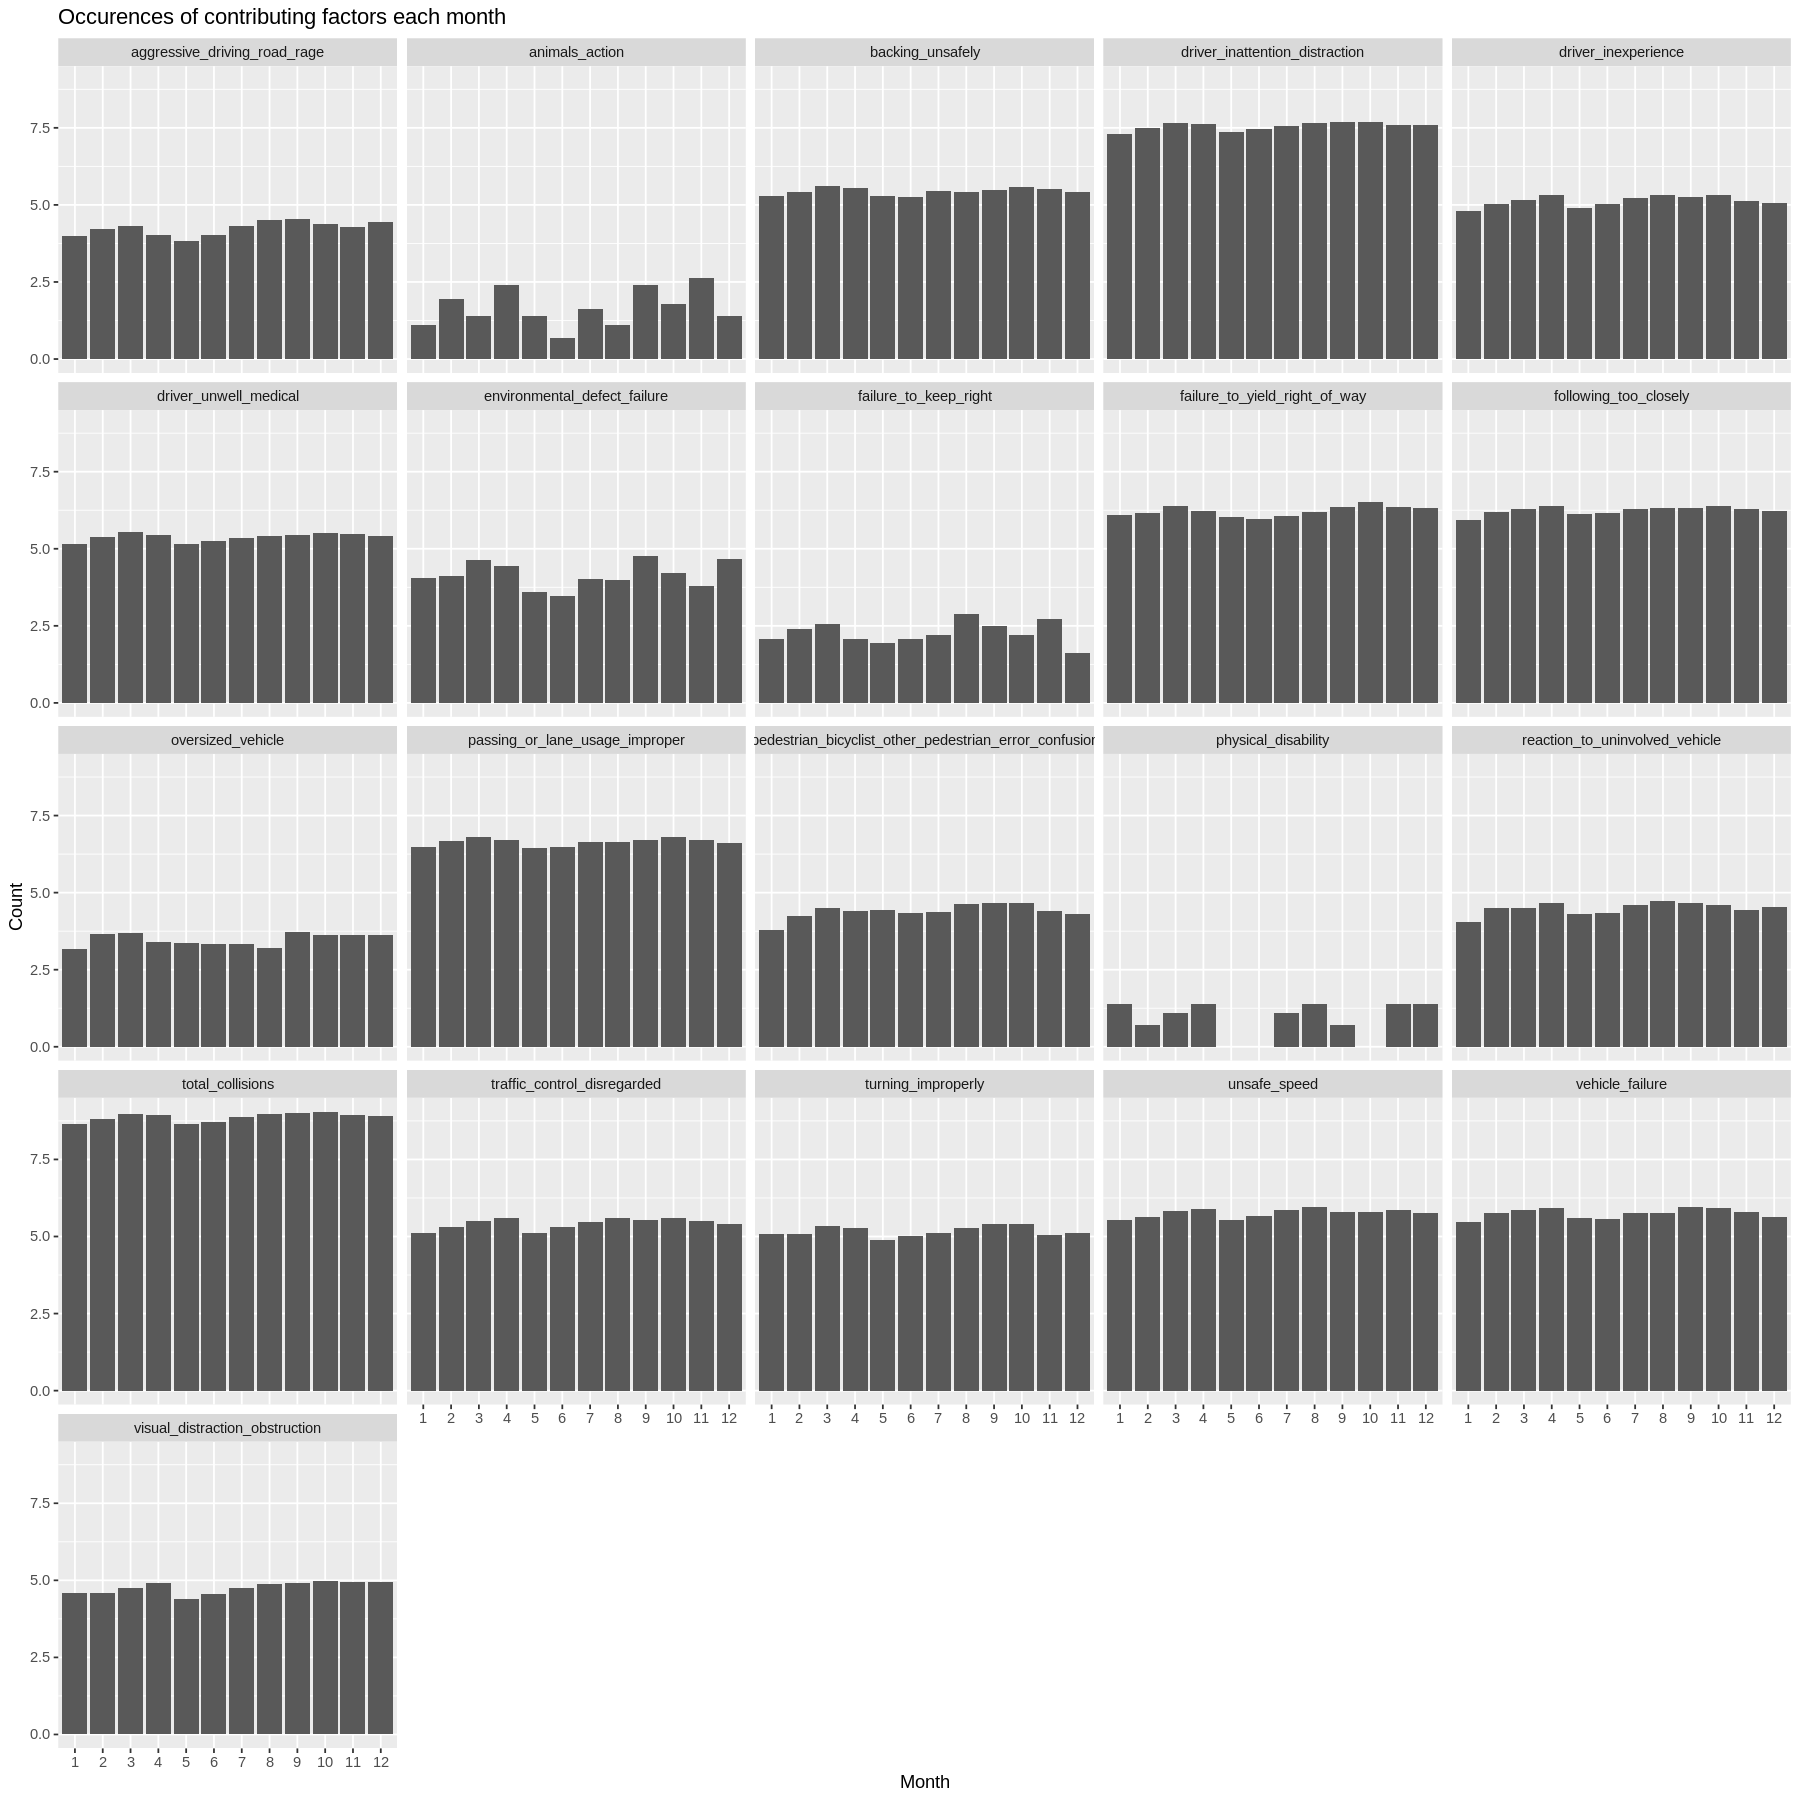

In [46]:
# plot contributing factor by month
cwt6_factorised %>%
  pivot_longer(cols = c(total_collisions, aggressive_driving_road_rage, backing_unsafely,
                        failure_to_keep_right, failure_to_yield_right_of_way,
                        following_too_closely, passing_or_lane_usage_improper,
                        traffic_control_disregarded, turning_improperly,
                        unsafe_speed, driver_inattention_distraction,
                        driver_inexperience, driver_unwell_medical,
                        reaction_to_uninvolved_vehicle, oversized_vehicle,
                        vehicle_failure, animals_action,
                        pedestrian_bicyclist_other_pedestrian_error_confusion,
                        physical_disability, environmental_defect_failure,
                        visual_distraction_obstruction),
                names_to = "dimension",
                values_to = "count") %>%
  group_by(month, dimension) %>%
  summarise(count = sum(count), .groups = "drop") %>%
  ggplot(aes(x = month, y = log(count))) +
  geom_col() +
  facet_wrap(~dimension) +
  labs(x = "Month", y = "Count", title = "Occurences of contributing factors each month")


Nothing of particular interest was noted in the charts by month.

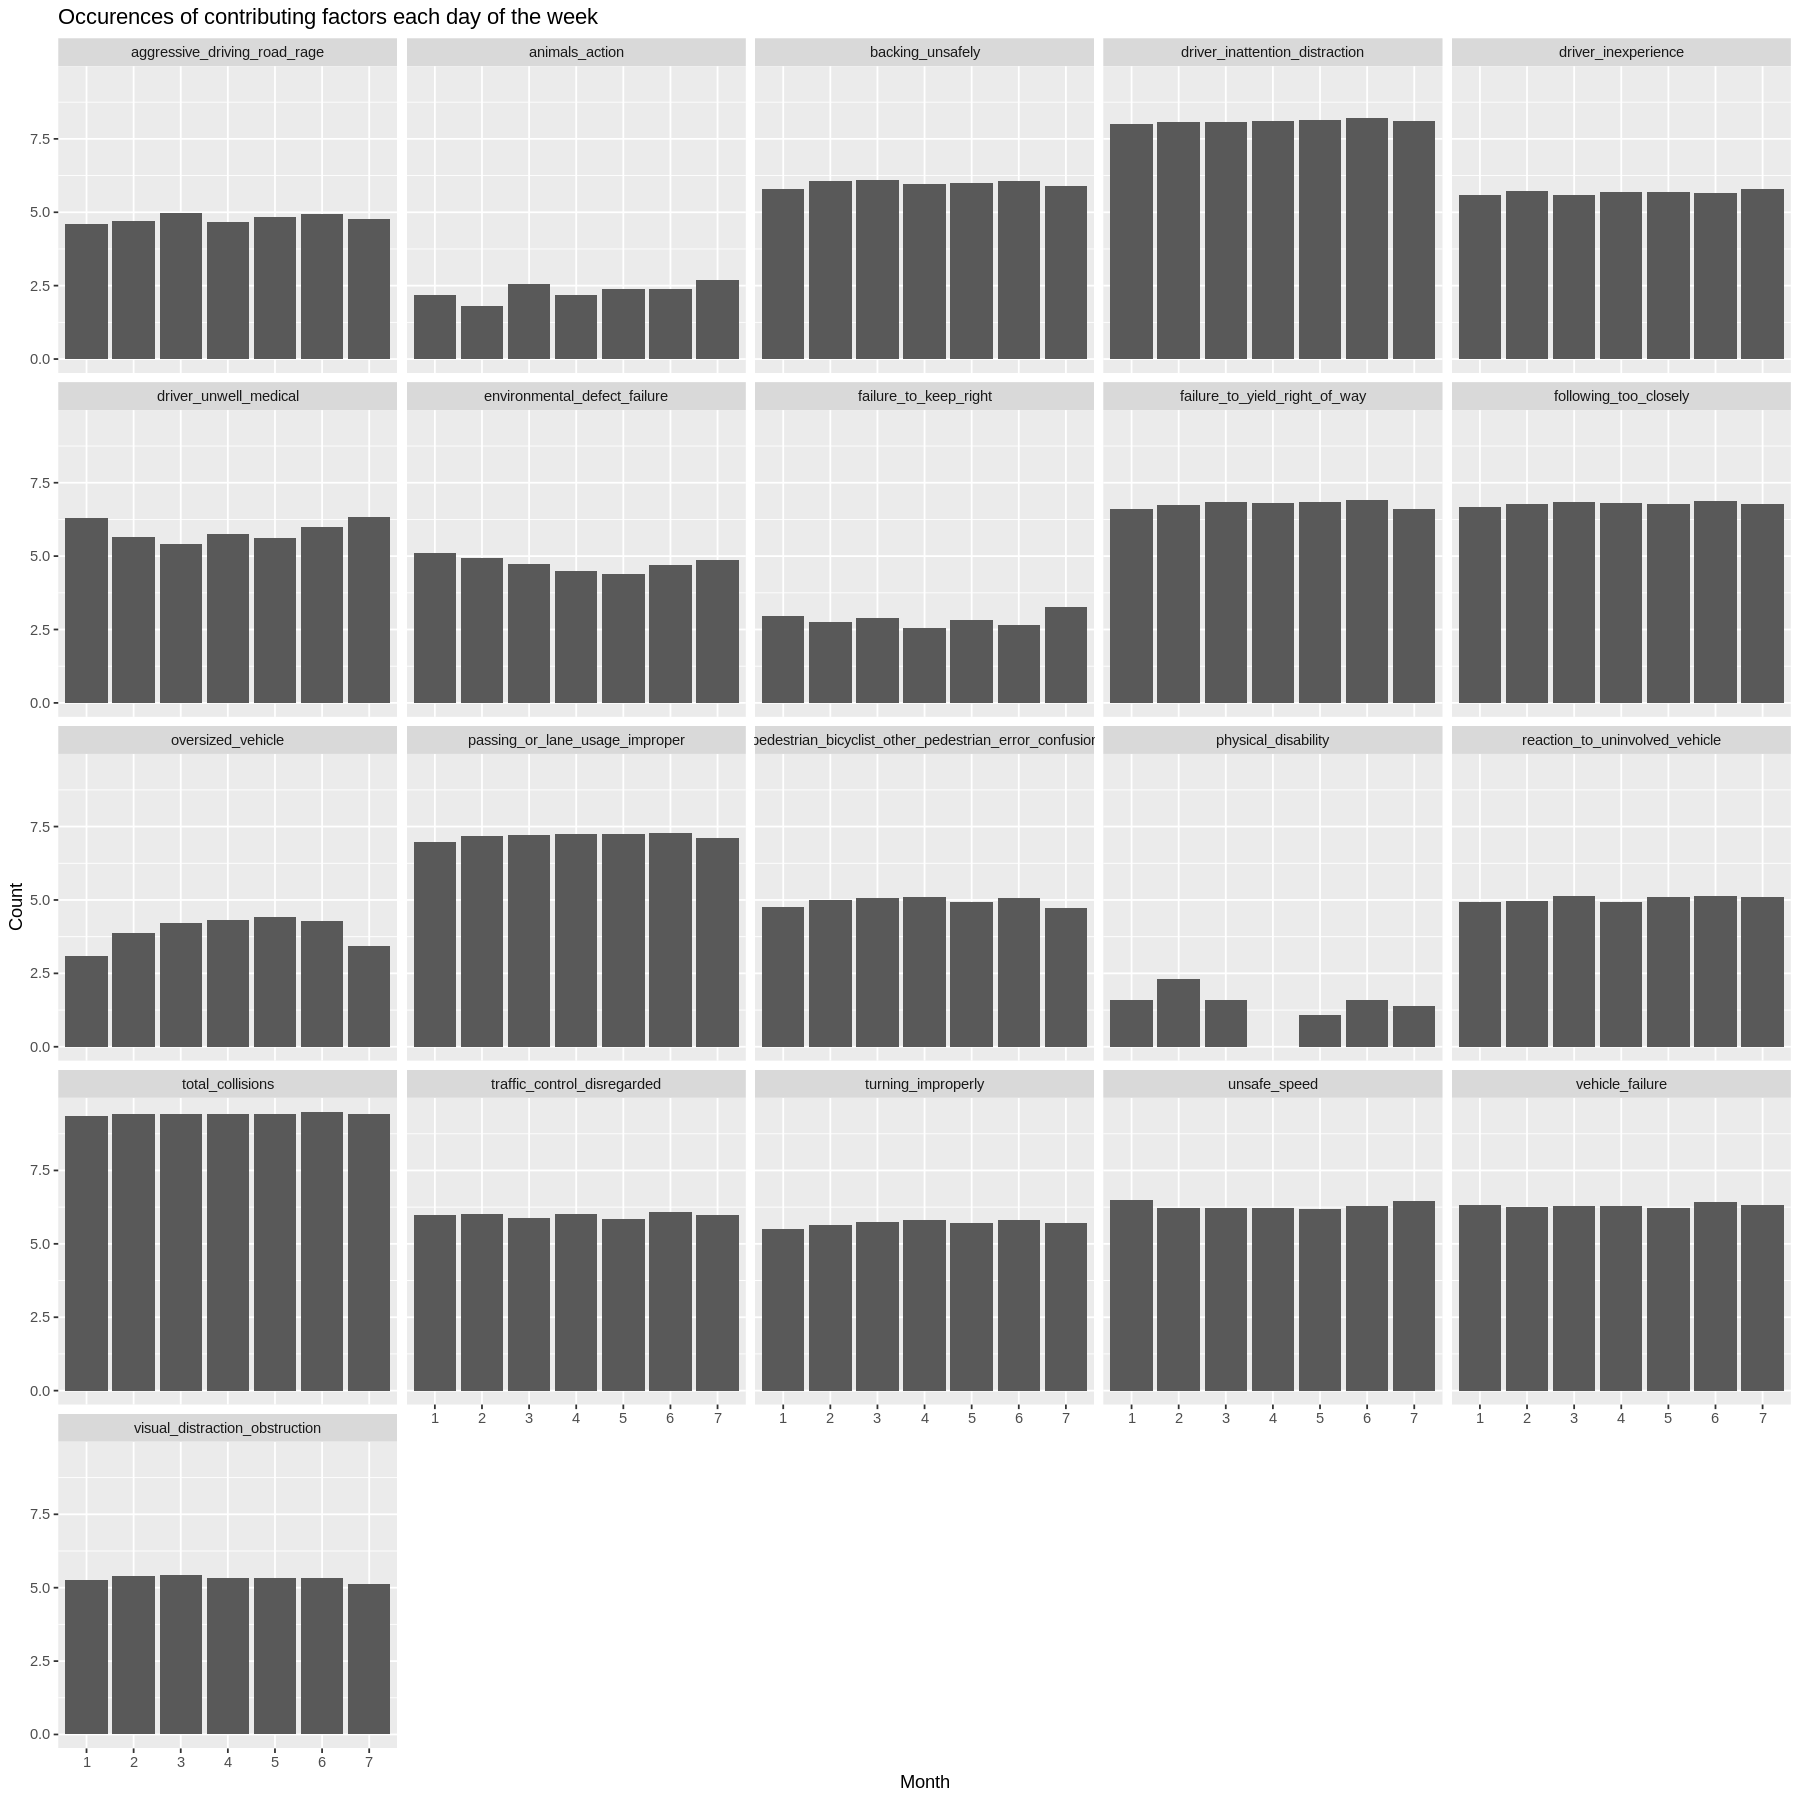

In [47]:
cwt6_factorised %>%
  pivot_longer(cols = c(total_collisions, aggressive_driving_road_rage, backing_unsafely,
                        failure_to_keep_right, failure_to_yield_right_of_way,
                        following_too_closely, passing_or_lane_usage_improper,
                        traffic_control_disregarded, turning_improperly,
                        unsafe_speed, driver_inattention_distraction,
                        driver_inexperience, driver_unwell_medical,
                        reaction_to_uninvolved_vehicle, oversized_vehicle,
                        vehicle_failure, animals_action,
                        pedestrian_bicyclist_other_pedestrian_error_confusion,
                        physical_disability, environmental_defect_failure,
                        visual_distraction_obstruction),
                names_to = "dimension",
                values_to = "count") %>%
  group_by(day_of_week, dimension) %>%
  summarise(count = sum(count), .groups = "drop") %>%
  ggplot(aes(x = day_of_week, y = log(count))) +
  geom_col() +
  facet_wrap(~dimension) +
  labs(x = "Month", y = "Count", title = "Occurences of contributing factors each day of the week")

However, there were some interesting variations noted from the graphs for each day of the week.

In general, Sunday has had the fewest collisions and Friday the most. The remaining days have had broadly the same number of days. But collisions caused by unsafe speeds, unwell drivers, vehicle failures and environmental defects tended to occur at weekends as opposed to weekdays.

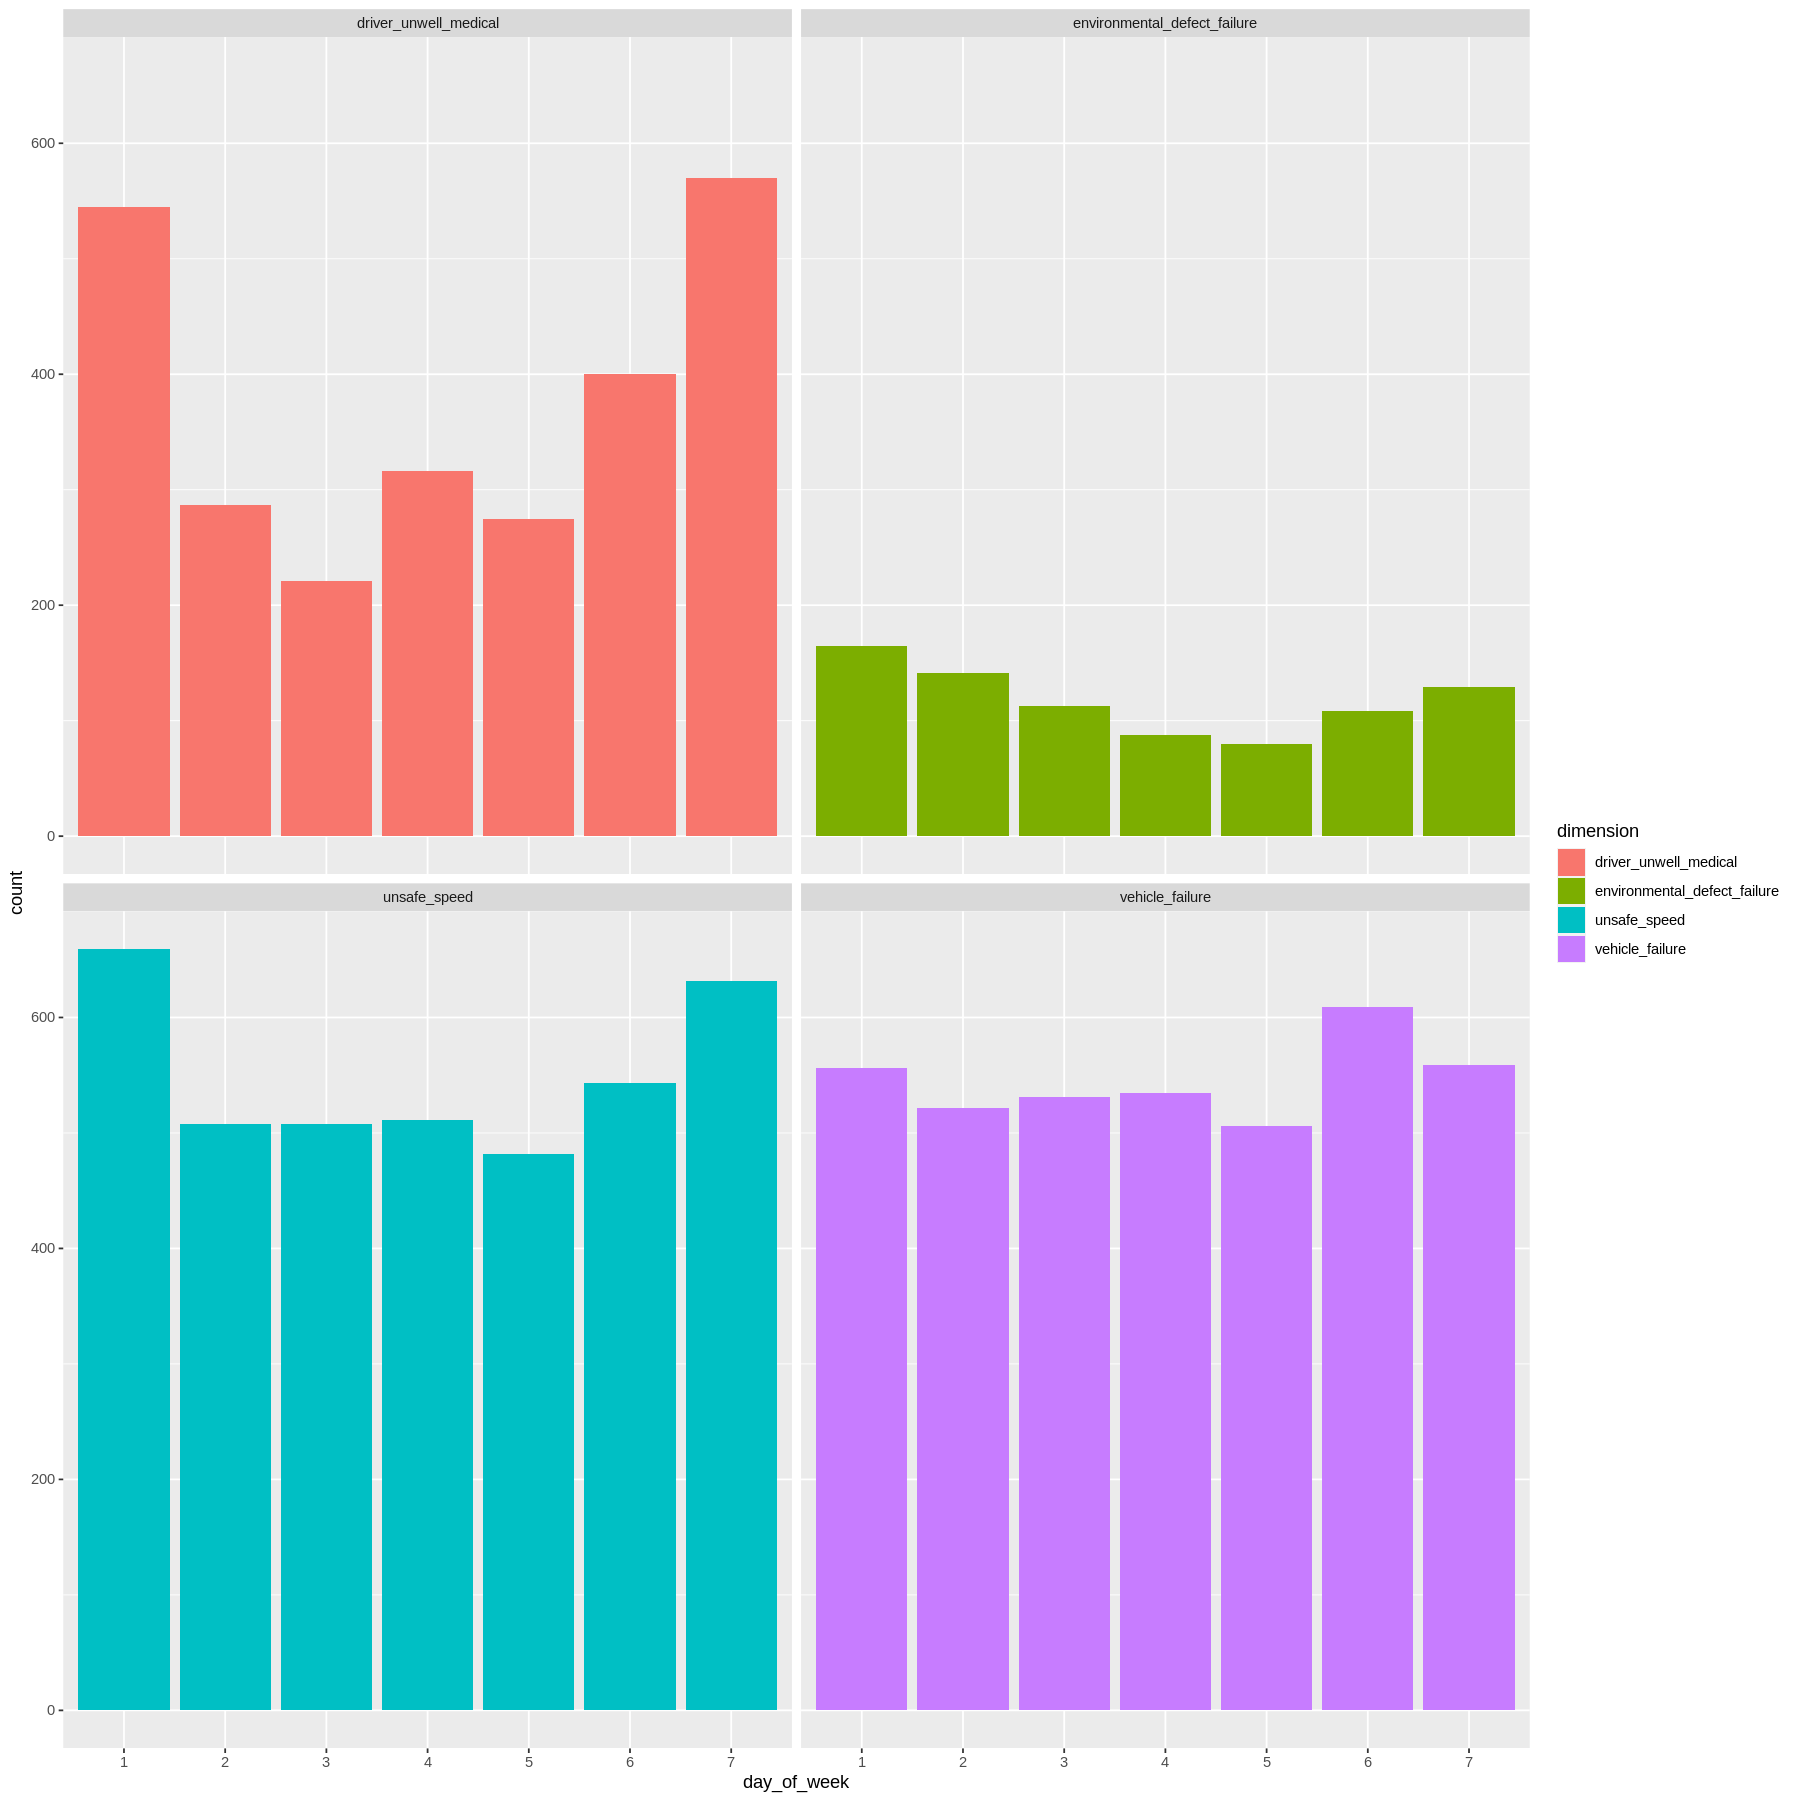

In [48]:
cwt6_factorised %>%
  pivot_longer(cols = c(unsafe_speed, driver_unwell_medical,
                        vehicle_failure, environmental_defect_failure),
                names_to = "dimension",
                values_to = "count") %>%
  group_by(day_of_week, dimension) %>%
  summarise(count = sum(count), .groups = "drop") %>%
  ggplot(aes(x = day_of_week, y = count, fill = dimension)) +
  geom_col() +
  facet_wrap(~dimension)

Why this might be, can only be speculated: It is possible that lifestyle variations lead to variations in the risks drivers are prepared to take.

However, these variations suggest that models for each day of the week may be better fitting than one model. This was explored.

In [49]:
# create model for each day of the week using all variables
lm(data = cwt6_factorised, total_collisions ~ month + day + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()
lm(data = filter(cwt6_factorised, day_of_week == 1), total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()
lm(data = filter(cwt6_factorised, day_of_week == 2), total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()
lm(data = filter(cwt6_factorised, day_of_week == 3), total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()
lm(data = filter(cwt6_factorised, day_of_week == 4), total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()
lm(data = filter(cwt6_factorised, day_of_week == 5), total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()
lm(data = filter(cwt6_factorised, day_of_week == 6), total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()
lm(data = filter(cwt6_factorised, day_of_week == 7), total_collisions ~ month + day + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all) %>% glance()

r.squared adj.r.squared sigma    statistic p.value      df logLik   AIC    
1 0.4027916 0.2872029     26.38885 3.484697  6.622694e-12 54 -1537.04 3186.08
  BIC      deviance df.residual nobs
1 3399.503 194287.6 279         334

r.squared adj.r.squared sigma    statistic p.value   df logLik   AIC     
1 0.8521618 0.1499304     25.95463 1.213506  0.4133542 38 -178.127 436.2539
  BIC      deviance df.residual nobs
1 510.2598 5389.143 8           47

r.squared adj.r.squared sigma    statistic p.value  df logLik    AIC     
1 0.8067922 -0.1350959    34.65759 0.8565691 0.657082 39 -195.2916 472.5832
  BIC      deviance df.residual nobs
1 549.3025 9609.186 8           48

r.squared adj.r.squared sigma    statistic p.value   df logLik    AIC     
1 0.7793947 -0.2960559    33.45585 0.7247145 0.7643557 39 -193.5977 469.1954
  BIC      deviance df.residual nobs
1 545.9146 8954.349 8           48

r.squared adj.r.squared sigma    statistic p.value   df logLik    AIC     
1 0.7828478 -0.275769     27.89556 0.7395007 0.7522673 39 -184.8733 451.7465
  BIC      deviance df.residual nobs
1 528.4658 6225.3   8           48

r.squared adj.r.squared sigma    statistic p.value   df logLik    AIC    
1 0.9336174 0.554288      19.74138 2.461231  0.1072699 40 -165.0725 414.145
  BIC      deviance df.residual nobs
1 492.7354 2728.056 7           48

r.squared adj.r.squared sigma    statistic p.value    df logLik    AIC     
1 0.9386511 0.5880858     20.53301 2.677536  0.08763832 40 -166.9597 417.9194
  BIC      deviance df.residual nobs
1 496.5098 2951.231 7           48

r.squared adj.r.squared sigma    statistic p.value   df logLik    AIC    
1 0.9274369 0.5231566     22.91879 2.294044  0.1264728 39 -169.1425 420.285
  BIC      deviance df.residual nobs
1 496.1411 3676.897 7           47

The models suggest that creating a model for each individual day of the week, even without checking if they are the best fitting models, will be significantly more successful in forecasting the number of collisions each day. This was tested, however, as the data sample sizes are small, a different testing approach was used.

In [50]:
#First split the data by day_of_week
data1 <- filter(cwt6_factorised, day_of_week == 1)
data2 <- filter(cwt6_factorised, day_of_week == 2)
data3 <- filter(cwt6_factorised, day_of_week == 3)
data4 <- filter(cwt6_factorised, day_of_week == 4)
data5 <- filter(cwt6_factorised, day_of_week == 5)
data6 <- filter(cwt6_factorised, day_of_week == 6)
data7 <- filter(cwt6_factorised, day_of_week == 7)

# set seed for repeatability
set.seed(7)

#create models using leave-one-out cross validataion
lm1 <- train(total_collisions ~ month + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = data1, method = "lm", trControl = trainControl(method = "LOOCV"))
lm2 <- train(total_collisions ~ month + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = data2, method = "lm", trControl = trainControl(method = "LOOCV"))
lm3 <- train(total_collisions ~ month + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = data3, method = "lm", trControl = trainControl(method = "LOOCV"))
lm4 <- train(total_collisions ~ month + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = data4, method = "lm", trControl = trainControl(method = "LOOCV"))
lm5 <- train(total_collisions ~ month + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = data5, method = "lm", trControl = trainControl(method = "LOOCV"))
lm6 <- train(total_collisions ~ month + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = data6, method = "lm", trControl = trainControl(method = "LOOCV"))
lm7 <- train(total_collisions ~ month + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = data7, method = "lm", trControl = trainControl(method = "LOOCV"), na.action=na.exclude)

# re-create original model using leave-one-out cross validation
lmOrig <- train(total_collisions ~ month + day_of_week + temp_c + slp_c + visib_c + wdsp_c + prcp_c + fog_c + avg_speed_all, data = cwt6_factorised, method = "lm", trControl = trainControl(method = "LOOCV"), na.action=na.exclude)

# show results
lm1
lm2
lm3
lm4
lm5
lm6
lm7
lmOrig

Linear Regression 

47 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 46, 46, 46, 46, 46, 46, ... 
Resampling results:

  RMSE      Rsquared    MAE     
  32.67256  0.07223621  26.77674

Tuning parameter 'intercept' was held constant at a value of TRUE

Linear Regression 

48 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 47, 47, 47, 47, 47, 47, ... 
Resampling results:

  RMSE      Rsquared     MAE     
  41.68729  0.006211564  33.16484

Tuning parameter 'intercept' was held constant at a value of TRUE

Linear Regression 

48 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 47, 47, 47, 47, 47, 47, ... 
Resampling results:

  RMSE      Rsquared    MAE     
  34.05983  0.05142083  25.50709

Tuning parameter 'intercept' was held constant at a value of TRUE

Linear Regression 

48 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 47, 47, 47, 47, 47, 47, ... 
Resampling results:

  RMSE      Rsquared     MAE     
  32.55603  0.001436836  26.63391

Tuning parameter 'intercept' was held constant at a value of TRUE

Linear Regression 

48 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 47, 47, 47, 47, 47, 47, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  34.7419  0.1332943  26.83529

Tuning parameter 'intercept' was held constant at a value of TRUE

Linear Regression 

48 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 47, 47, 47, 47, 47, 47, ... 
Resampling results:

  RMSE      Rsquared    MAE    
  38.44106  0.03553164  32.0025

Tuning parameter 'intercept' was held constant at a value of TRUE

Linear Regression 

48 samples
 8 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 46, 46, 46, 46, 46, 46, ... 
Resampling results:

  RMSE      Rsquared    MAE     
  36.40814  0.09696569  28.20854

Tuning parameter 'intercept' was held constant at a value of TRUE

Linear Regression 

335 samples
  9 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 333, 333, 333, 333, 333, 333, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  27.6534  0.2256869  21.64595

Tuning parameter 'intercept' was held constant at a value of TRUE

Using leave-one-out cross-validation, the model that produced the lowest root mean squared error and highest R squared value was the original model (27.65 and 0.226 respectively). This makes it the model tested to most closely predict the actual number of collisions each day as opposed to any of the individual day of week models.

# Conclusions

After exploring whether it was possible to create a linear model to predict the total number of collisions based on weather data on a particular day, it was found that the best fitting model was a simple linear model based on temperature, windspeed, sea-level pressure, precipitation, visibility, fog, average speed, and date information.

However, the accuracy of the model (R^2=0.40 when fitted, although R^2=0.23 when tested) suggested that although there is a relationship between the weather and the number of collisions, other factors may be influencing their occurrence. Efforts were made to find a better fitting model.

It was tested whether Poission distributions could be used to determine the occurrence of each of the contributing factors using GLMs. However, the resulting model was believed to be significantly overfitted to the training data (R^2=0.75). Considerably more analysis would be required to see if this could be corrected, which was beyond the scope of this report.

Variations in occurrences of contributing factors between days of the week suggested testing individual linear models, however, although the trained models were better fitted, when tested the accuracy was poorer than the original (R^2 ranged from 0.001 to 0.13 compared to 0.23) and was abandoned. The small volume of data (a seventh of the overall dataset) could be part of the reason for these issues.

To expand upon this research and try and build a more accurate model, it is suggested to increase the size of the dataset. Time data could be used to understand changes throughout the day. The location data could be improved, making it possible to test models in different locations. Additional data to understand cyclist and pedestrian volumes as well as traffic information could also be beneficial in predicting collisions for the emergency services.

# References

New York City Department of Transportation (2023) *Automated Traffic Volume Counts*, NYC OpenData [online]. Available from <https://data.cityofnewyork.us/Transportation/Automated-Traffic-Volume-Counts/7ym2-wayt> [18 December 2023]

New York City Department of Transportation (2024) *DOT Traffic Speeds NBE*, NYC OpenData [online]. Available from <https://data.cityofnewyork.us/Transportation/DOT-Traffic-Speeds-NBE/i4gi-tjb9/> [9 January 2024]

New York State Governor’s Office (2022) *Governor Hochul Signs New Laws to Enhance Street Safety, Prevent Traffic Deaths, and Crack Down on Hit-And-Run Crashes*, New York State [online]. Available from https://www.governor.ny.gov/news/governor-hochul-signs-new-laws-enhance-street-safety-prevent-traffic-deaths-and-crack-down-hit#:~:text=Legislation%20%28A.1007-A%2FS.2021-A%29%20will%20help%20prevent%20traffic-related%20crashes%20and,for%20pedestrians%20in%20the%20event%20of%20a%20crash. [27th January 2024]

The New York Times (2022) *Two years of the Pandemic in New York, step by awful step* [online]. Available from <https://www.nytimes.com/interactive/2022/nyregion/nyc-covid-timeline.html> [22 December 2023]